# El Impacto De Las Condiciones Ambientales
## Entregable 1

---

## Importamos librerías a usar

[texto del vínculo](https://)

In [57]:
#Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import display, HTML
import re
from missingno import matrix, bar, heatmap, dendrogram
from scipy.stats import chi2_contingency

Pandas permite cargar, explorar y manipular datos en estructuras como los DataFrames, que son fundamentales para trabajar con información tabular. numpy se emplea para operaciones numéricas eficientes, como cálculos con arrays y manejo de valores nulos. Para la visualización de datos, se usa matplotlib.pyplot para crear gráficos básicos como líneas, barras o histogramas, mientras que seaborn facilita la generación de gráficos estadísticos más avanzados y estéticos, como mapas de calor o diagramas de caja.

Para el caso de  coordenadas geográficas, folium es útil para construir mapas interactivos que permiten representar datos espaciales. En cuanto a la preparación y modelado con machine learning, train_test_split de sklearn divide los datos en conjuntos de entrenamiento y prueba, lo que es esencial para validar modelos. StandardScaler se encarga de normalizar variables numéricas, LabelEncoder convierte variables categóricas en valores numéricos, y SimpleImputer permite imputar valores faltantes con distintas estrategias.

## Zona de Estudio con GEE

Utiliza imagenes Sentinel-2 corregido atmosféricamente (COPERNICUS/S2_SR).

Filtra imágenes con menos del 20% de nubes

Selecciona la estacion por año (primavera e invierno)

Primero se debe habilitar una APi de GEE version gratuita, luego se procede a armar un proyecto o carpeta en GEE y se habilita para despues seguir con el codigo en Colab

In [ ]:
# Instalar y cargar Earth Engine
!pip install earthengine-api folium geemap --quiet

import ee
import geemap  # <- IMPORTAR geemap aquí

ee.Authenticate()  # Esto abre un enlace para autorizar tu cuenta
ee.Initialize(project='mentorias-463215')  # Solo después de autenticar

# Punto central: Franja costera del Río de La Plata
punto = ee.Geometry.Point([-58.4464023, -34.5375533])
zona = punto.buffer(1000).bounds()

# Función para obtener una imagen limpia por estación y año
def obtener_imagen(estacion, fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)

    vis_params = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}  # RGB
    return coleccion.visualize(**vis_params).set({'title': estacion})

# Crear diccionario con las estaciones
imagenes = {
    'Invierno 2021': obtener_imagen('Invierno 2021', '2021-06-21', '2021-09-21'),
    'Primavera 2021': obtener_imagen('Primavera 2021', '2021-09-22', '2021-12-20'),
    'Invierno 2022': obtener_imagen('Invierno 2022', '2022-06-21', '2022-09-21'),
    'Primavera 2022': obtener_imagen('Primavera 2022', '2022-09-22', '2022-12-20'),
}

# Crear mapa
m = geemap.Map(center=[-34.5375533, -58.4464023], zoom=13)

# Agregar capas al mapa
for nombre, imagen in imagenes.items():
    m.addLayer(imagen, {}, nombre)

m.add_legend(title="Estaciones", labels=list(imagenes.keys()), colors=['#999999']*4)
m  # Mostrar mapa

Las imágenes satelitales correspondientes a invierno y primavera de los años 2021 y 2022 permiten evidenciar condiciones ambientales superficiales en distintas estaciones y años. Las variaciones en la coloración del agua observadas en las escenas pueden reflejar diferencias en la turbidez, en la presencia de sedimentos en suspensión o incluso en posibles floraciones algales, todos ellos considerados indicadores indirectos del estado de la calidad del agua. Además, el contraste entre áreas ribereñas vegetadas y zonas construidas permite inferir el grado de permeabilidad del entorno y su influencia en los procesos de escurrimiento y arrastre de contaminantes hacia el río.

Estas imágenes también permiten interpretar procesos ambientales que afectan directamente la calidad del agua. Por ejemplo, un aumento del verdor costero durante la primavera podría asociarse a una mayor actividad agrícola o a un incremento en la escorrentía de fertilizantes, mientras que la presencia de tonalidades marrones u opacas en el cuerpo de agua puede estar relacionada con una mayor carga de sedimentos o materia orgánica en suspensión, resultado de fenómenos como la erosión del suelo, precipitaciones intensas o vertidos cloacales.

Finalmente, la comparación entre años permite detectar patrones interanuales. Si en una misma estación se observa una mayor degradación visual del agua en un año respecto a otro, es posible vincular esa diferencia con condiciones climáticas particulares (como sequías o lluvias extremas) o con transformaciones en el uso del suelo del entorno inmediato al cauce.

**NDCI, o Índice de Diferencia Normalizada de Clorofila**
 es un índice que se utiliza para estimar la concentración de clorofila-a en aguas productivas y turbias, como estuarios, aguas costeras y lagos de agua dulce. Se calcula utilizando bandas espectrales rojas y de borde rojo, que se encuentran en sensores como Sentinel-2.

In [ ]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='mentorias-463215')

punto = ee.Geometry.Point([-58.4464023, -34.5375533])
zona = punto.buffer(1000).bounds()

def obtener_imagen(fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)
    return coleccion

def calcular_ndci(imagen):
    ndci = imagen.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci

fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
}

m = geemap.Map(center=[-34.5375533, -58.4464023], zoom=13)

# Parámetros visualización NDCI
ndci_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green', 'darkgreen']
}

for estacion, (fecha_ini, fecha_fin) in fechas_estaciones.items():
    imagen = obtener_imagen(fecha_ini, fecha_fin)
    ndci = calcular_ndci(imagen)
    m.addLayer(ndci, ndci_vis, f'NDCI {estacion}')

colores_rgb = [
    (0, 0, 255),        # azul
    (255, 255, 255),    # blanco
    (0, 128, 0),        # verde
    (0, 100, 0)         # verde oscuro
]

m.add_legend(title="NDCI", labels=['Bajo', 'Medio', 'Alto', 'Muy alto'], colors=colores_rgb)

m

En Primavera 2021 y Primavera 2022 se observa una mayor intensidad de verde, indicando una mayor concentración de clorofila y, por ende, una mayor presencia de algas en la zona costera. Esto es coherente con que la primavera suele ser temporada de mayor actividad biológica y crecimiento algal debido a mejores condiciones de luz y temperatura.

En Invierno 2021 y Invierno 2022, la intensidad del verde es menor, mostrando menos concentración de algas. Esto corresponde a la temporada fría, cuando la proliferación algal disminuye por menores temperaturas y condiciones menos favorables para el crecimiento.

## Descripcion básica del dataset

#### Aspectos generales

Al analizar el dataset Conexiones_Transparentes.csv, se observó primero su dimensión general, es decir, cuántas filas y columnas contiene.Se identificó  613 registros distribuidos en 45 columnas. Esto permitió tener una idea inicial del volumen de datos con los que se va a trabajar. Luego, se revisaron los tipos de datos de cada variable, lo cual permite entender si se trata de valores numéricos, texto, fechas u otro tipo de información, y así anticipar qué tipo de análisis será necesario en cada caso.

Finalmente, se visualizaron las primeras filas del dataset, lo que sirvió para conocer cómo están estructurados los datos, si los nombres de las columnas son claros, si hay valores atípicos o mal cargados a simple vista, y empezar a identificar patrones o variables relevantes.

In [173]:
# Configuracion de pandas

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)

# Descripcion del dataset
print("Dimensiones del dataset:")
print(df.shape)

print("\nTipos de datos:")
print(df.dtypes)

print("\nAlgunas filas del dataset:")
# Acá cambio y elijo mostrar un sampleo más grande. La idea es no ver registros contiguos que puedan
    # tener cierta correlación en la falta de datos
display(df.sample(20, random_state=0))

Dimensiones del dataset:
(613, 45)

Tipos de datos:
orden                                                                               float64
sitios                                                                               object
codigo                                                                               object
fecha                                                                                object
año                                                                                  object
campaña                                                                              object
tem_agua                                                                             object
tem_aire                                                                             object
od                                                                                   object
ph                                                                                   object
olores                      

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,gobierno_local,sitio,latitud,longitud,Poblacion_partido,Personas_con_cloacas,Actividad_principal,"Agricultura, ganadería, caza y silvicultura",Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos,Explotación de minas y canteras,Industria Manufacturera,"Electricidad, gas y agua",Construcción,Servicios
453,10.0,Del Arca,SF015,22/2/2023,2023.0,Verano,26,14,5.65,NaN,Ausencia,Ausencia,Ausencia,Presencia,15000,4700,920,5.1,1.2,0.26,0.23,2.1,<30,21,<0.10,<0.005,<0.001,<0.10,2.61,35,Extremadamente deteriorada,San Fernando,Del arca,-34.438.919,-58.536.519,171.616,157.308,"""Actividad náutica""",2.0,7.0,0.0,5.0,7.0,7.0,5.0
52,32.0,Costanera Hudson Calle 63,BZ080,27/10/2021,2021.0,primavera,26,26,11.52,8.94,Ausencia,Ausencia,Ausencia,Ausencia,190000,20000,500,5.4,0.34,0.47,0.19,13,no se midió,50,<100,0.0057,<0.001,0.84016,<0.20,33,Extremadamente deteriorada,Berazategui,Costanera Hudson calle 63,-34.753,-58.108.281,358.712,267.760,"""Agricultura, ganadería, caza y silvicultura""",1.0,2.0,0.0,7.0,6.0,6.0,3.0
535,39.0,Balneario Palo Blanco,BS092,8/4/2024,2024.0,verano,22,22,8.4,8.29,Ausencia,Ausencia,Ausencia,Presencia,23000,20000,4000,6.2,0.99,0.7,s/i,10,s/i,56.2,<0.10,s/i,s/i,10.3,<0.15,36,Extremadamente deteriorada,Berisso,Balneario Palo Blanco,-34.855.808,-57.838.144,100.930,47.630,"""Industria Manufacturera""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,14.0,Perú Puente,SI023,14/11/2023,2023.0,primavera,23,23,4.86,-,Ausencia,Ausencia,Ausencia,Ausencia,28000,20000,10000,14.4,2.1,0.36,<0.20,2.7,<30,6.2,<0.10,<0.005,<0.001,<10.00,<0.15,32,Extremadamente deteriorada,San Isidro,Perú puente,-34.484.169,-5.847.945,297.282,275.528,"""Explotación de minas y canteras con el 11,53%...",0.0,5.0,1.0,6.0,3.0,1.0,1.0
55,NaN,NaN,CA CU03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: marisma canal de...,-34.538.686,-58.445.589,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,19.0,Costanera Norte - Espigón Abanico,CA044,24/2/2021,2021.0,verano,26.1,27.5,4.7,7.4,Ausencia,Ausencia,Ausencia,Ausencia,25000,3800,370,no se midió,1.2,0.64,no se midió,<5,<50,59,<100,<10,0.019,0.001,<0.15,34,Extremadamente deteriorada,CABA,Costanera norte espigón abanico,-34.547.089,-58.430.231,3.121.707,3.049.672,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,5.0,Río Reconquista y Río Lujan,TI004,23/8/2023,2023.0,invierno,15.3,11,5.36,7.13,Presencia,Presencia,Presencia,Presencia,4000,3600,1500,18.6,4.00,1.3,0.53,4.3,40,29,<0.10,<0.005,<0.001,4.54,<0.15,30,Extremadamente deteriorada,Tigre,Canal Villanueva y río Luján,-34.408.061,-58.590.839,446.949,144.834,"""La industria metalúrgica y la actividad mader...",4.0,4.0,4.0,4.0,5.0,3.0,4.0
594,4.0,Río Carapachay y Arroyo Gallo Fiambre,TI003,45623,2024.0,primavera,24.9,23.0,2.6,6.8,Presencia,Ausente,Presencia,Ausente,no se analizó,5900,2300,<1.00,1.2,0.3,no se analizó,3.0,no se analizó,53.8,<0.10,no se analizó,no se analizó,<10.00,<0.15,38,Extremadamente deteriorada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,40.0,Playa La Bagliardi,BS091,22/2/2023,2023.0,Verano,21,25,6.65,7.76,Ausencia,Ausencia,Ausencia,Presencia,4000,500,280,5.6,0.84,0.54,0.41,3.3,70,13,<0.10,<0.005,<0.001,<0.10,>5.00,no se pudo calcular,NaN,Berisso,Playa La Bagliardi,-34.873.061,-57.810.561,100.930,47.630,"""Industria Manufacturera""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,11.0,Espigón La Farola,SI021,14/11/2023,2023.0,primavera,en obra,en obra,en obra,en obra,en obra,en obra,en obra,en obra,en obra,en obra

En la tabla cada fila representa una columna del DataFrame. Esto significa lo siguiente:

Column: el nombre de la columna, por ejemplo, orden, sitios, codigo, etc.

Non-Null Count: cantidad de valores que no están vacíos (no son NaN) en esa columna. Por ejemplo, orden tiene 589 valores no nulos, lo que implica que 24 filas tienen datos faltantes en esa columna (613 - 589 = 24).

Dtype: el tipo de dato que tiene esa columna:

- float64: números decimales.
- object: generalmente texto o una mezcla de tipos (podrían ser números como texto, fechas mal interpretadas, etc.).

Al revisar los tipos de datos, la mayoría de las columnas están clasificadas como objetos (object). Esto indica que dichas variables o bien contienen datos categóricos o que algunos de sus valores numéricos tienen cierta codificación en formato string (como podría ser el caso de valores faltantes o inexistentes). En este caso, observamos que algunas variables numéricas tienen registros a los que se les asigna una cadena de caracteres en lugar de un valor numérico, correspondiendo estos casos a valores faltantes.

Se observa también gran cantidad de valores faltantes en las variables añadidas del CENSO y del Programa de Estudios del Conurbano.

#### Clasificación de las variables

En las siguientes listas clasificamos las variables según su tipo, observando sus valores e interpretaciones.

In [174]:
numericas = [
    'tem_agua',
    'tem_aire',
    'od',
    'ph',
    'colif_fecales_ufc_100ml',
    'escher_coli_ufc_100ml',
    'enteroc_ufc_100ml',
    'nitrato_mg_l',
    'nh4_mg_l',
    'p_total_l_mg_l',
    'fosf_ortofos_mg_l',
    'dbo_mg_l',
    'dqo_mg_l',
    'turbiedad_ntu',
    'hidr_deriv_petr_ug_l',
    'cr_total_mg_l',
    'cd_total_mg_l',
    'clorofila_a_ug_l',
    'microcistina_ug_l',
    'ica',
    'Poblacion_partido',
    'Personas_con_cloacas',
]

categoricas = [
    'orden',
    'sitios',
    'codigo',
    'campaña',
    'olores',
    'color',
    'espumas',
    'mat_susp',
    'calidad_de_agua',
    'gobierno_local',
    'sitio',
    'Actividad_principal',
    'Agricultura, ganadería, caza y silvicultura',
    'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    'Explotación de minas y canteras',
    'Industria Manufacturera',
    'Electricidad, gas y agua',
    'Construcción',
    'Servicios',
    'fecha',
    'año',
    'latitud',
    'longitud',
]

print("Cantidad de:")
print(f"\tVariables numéricas:   {len(numericas)}")
print(f"\tVariables categóricas: {len(categoricas)}")

Cantidad de:
	Variables numéricas:   22
	Variables categóricas: 23


De las variables numéricas, ICA, Poblacion_partido y Personas_con_cloacas son discretas, mientras que al resto podemos considerarlas continuas.

Entre las variables identificadas como categóricas, las siguientes son ordinales:
- orden
- Agricultura, ganadería, caza y silvicultura
- Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos
- Explotación de minas y canteras
- Industria Manufacturera
- Electricidad, gas y agua
- Construcción
- Servicios
- fecha
- año
- calidad_de_agua

Y las siguientes son binarias:
- olores
- color
- espumas
- mat_susp

**Notas:** Las variables categóricas fecha y año pueden ser usadas para crear una variable numérica tiempo que mida el transcurso del tiempo desde la primer medición (o desde alguna otra referencia), es decir, tenemos en estas codificadas información numérica, pero las clasificamos como categóricas.

Veamos la cantidad de valores únicos de cada variable.

In [175]:
# Crear DataFrame para clasificar variables y mostrar en tabla
variables = pd.DataFrame({
    'Variable': df.columns,
    'Tipo': ['Numerica' if col in numericas else 'Categorica' for col in df.columns],
    'Cantidad de valores únicos': [df[col].nunique() for col in df.columns]
})

display(variables)



,Variable,Tipo,Cantidad de valores únicos
0,orden,Categorica,43
1,sitios,Categorica,45
2,codigo,Categorica,50
3,fecha,Categorica,20
4,año,Categorica,6
5,campaña,Categorica,8
6,tem_agua,Numerica,158
7,tem_aire,Numerica,64
8,od,Numerica,373
9,ph,Numerica,240


#### Calidad de los datos

Vemos los porcentajes de valores no numéricos, nulos y vacíos -carácter ""- en las columnas numéricas. 
Además, vemos la cantidad de valores de forma forma '<{n}', con n un número. Estos últimos no son contabilizados
dentro de los valores no numéricos en esta sección.

In [176]:
# Patrón para valores como <n
patron = re.compile(r'^<\d+\.?\d*$')  # Acepta <3, <3.5, etc.

print("Porcentaje de:")
print("Columna\t\t\t\tCeros\tNo numéricos\tCon forma '<x'\tNulos\tVacíos")
print("______________________________________________________________________________________")
for col in numericas:
    # Intentar convertir a numérico
    valores_numericos = pd.to_numeric(df[col], errors='coerce')
    no_numericos = df[col][valores_numericos.isna() & df[col].notna()]
    
    # Contar cantidad de valores ...
    cantidad_no_numericos = len(no_numericos) # no numéricos
    cantidad_ceros = (df[col] == 0).sum() # iguales a cero
    vacios = df[col].str.strip().eq("").sum() # Vacíos -carácter "" o algún tipo de espacio-
    nulos = df[col].isnull().sum() # Nulos
    if cantidad_no_numericos != 0:
        valores_menor_que = no_numericos.apply(lambda x: bool(patron.match(str(x)))).sum() # Valores de forma '<x'
    else:
        valores_menor_que = 0
    
    # Cálculo de porcentajes
    total = len(df)
    porc_ceros = cantidad_ceros*100/total
    porc_no_numericos = (cantidad_no_numericos-valores_menor_que)*100/total
    porc_menores_que = valores_menor_que*100/total
    porc_nulos = nulos*100/total
    porc_vacios = vacios*100/total
    print(f"{col:<{25}}\t{porc_ceros:5.2f}\t   {porc_no_numericos:5.2f}\t    {porc_menores_que:5.2f}\t{porc_nulos:5.2f}\t{porc_vacios:5.2f}")

Porcentaje de:
Columna				Ceros	No numéricos	Con forma '<x'	Nulos	Vacíos
______________________________________________________________________________________
tem_agua                 	 0.00	   12.89	     0.00	 6.69	 0.00
tem_aire                 	 0.00	   12.72	     0.00	 8.48	 0.00
od                       	 0.00	   16.15	     0.00	 6.69	 0.00
ph                       	 0.00	   20.23	     0.00	 7.50	 0.00
colif_fecales_ufc_100ml  	 0.00	   14.36	     0.00	 6.85	 0.00
escher_coli_ufc_100ml    	 0.00	   13.21	     0.00	 6.53	 0.00
enteroc_ufc_100ml        	 0.00	   13.21	     0.00	 6.53	 0.00
nitrato_mg_l             	 0.00	    8.97	     7.83	 6.53	 0.00
nh4_mg_l                 	 0.00	    8.32	     7.34	 6.53	 0.00
p_total_l_mg_l           	 0.00	   13.05	     2.45	 6.69	 0.00
fosf_ortofos_mg_l        	 0.00	   20.39	     7.83	 6.53	 0.00
dbo_mg_l                 	 0.00	   22.68	    15.82	 6.85	 0.00
dqo_mg_l                 	 0.00	   19.41	    37.36	 6.36	 0.00
turbiedad_ntu        

Observamos ahora los porcentajes de valores nulos y vacíos de las variables categóricas

In [177]:
print("Porcentaje de:")
print("Columna\t\t\t\tNulos\tVacíos")
print("______________________________________________________________________________________")
for col in categoricas:
    # Convertir temporalmente a string
    columna_str = df[col].astype(str)
    
    # Contar cantidad de valores ...
    vacios = columna_str.str.strip().eq("").sum() # Vacíos -carácter "" o algún tipo de espacio-
    nulos = df[col].isnull().sum() # Nulos
    
    # Cálculo de porcentajes
    total = len(df)
    porc_nulos = nulos*100/total
    porc_vacios = vacios*100/total
    print(f"{col[:25]:<{25}}\t{porc_nulos:5.2f}\t{porc_vacios:5.2f}")

Porcentaje de:
Columna				Nulos	Vacíos
______________________________________________________________________________________
orden                    	 3.92	 0.00
sitios                   	 3.92	 0.00
codigo                   	 0.00	 0.00
campaña                  	 6.53	 0.00
olores                   	 6.36	 0.00
color                    	 6.36	 0.00
espumas                  	 6.36	 0.00
mat_susp                 	 6.36	 0.00
calidad_de_agua          	11.26	 0.00
gobierno_local           	52.69	 0.00
sitio                    	52.69	 0.00
Actividad_principal      	52.69	 0.00
Agricultura, ganadería, c	72.59	 0.00
Pesca explotación de cria	72.59	 0.00
Explotación de minas y ca	72.59	 0.00
Industria Manufacturera  	72.59	 0.00
Electricidad, gas y agua 	72.59	 0.00
Construcción             	72.59	 0.00
Servicios                	72.59	 0.00
fecha                    	 3.92	 0.00
año                      	 6.53	 0.00
latitud                  	52.69	 0.00
longitud                 	52.69	 0.00


#### Observamos la variable objetivo: ICA

In [178]:
print("Resumen de descripción de la variable objetivo ICA")

col = 'ica'

# Total de valores
total = df[col].shape[0]

# Valores nulos
nulos = df[col].isnull().sum()

# Valores vacíos o espacios en blanco
faltantes = df[col].astype(str).str.strip().replace('', pd.NA).isna().sum()

# Detectar valores mal cargados (no convertibles a numérico, excluyendo nulos)
valores_convertidos = pd.to_numeric(df[col], errors='coerce')
mal_cargados_mask = valores_convertidos.isna() & (~df[col].isnull())
mal_cargados = df.loc[mal_cargados_mask, col]

# Cantidad de valores mal cargados
cant_mal_cargados = mal_cargados.shape[0]

# Crear tabla resumen
resumen = pd.DataFrame({
    'Descripción': ['Total de valores', 'Valores nulos (NaN)', 'Valores vacíos/faltantes', 'Valores mal cargados'],
    'Cantidad': [total, nulos, faltantes, cant_mal_cargados]
})

display(resumen)

# Mostrar tabla con valores mal cargados
print(f"\nValores mal cargados en '{col}':")
display(mal_cargados.reset_index(drop=True))

Resumen de descripción de la variable objetivo ICA


,Descripción,Cantidad
0,Total de valores,613
1,Valores nulos (NaN),53
2,Valores vacíos/faltantes,0
3,Valores mal cargados,51



Valores mal cargados en 'ica':


0             no se midió
1             no se midió
2             no se midió
3             no se midió
4             no se midió
5             no se midió
6             no se midió
7             no se midió
8             no se midió
9             no se midió
10            no se midió
11            no se midió
12            no se midió
13            no se midió
14            no se midió
15            no se midió
16    no se pudo calcular
17    no se pudo calcular
18            inaccesible
19    no se pudo calcular
20    no se pudo calcular
21    no se pudo calcular
22            inaccesible
23    no se pudo calcular
24            no muestreó
25    no se pudo calcular
26            no muestreó
27    no se pudo calcular
28            no muestreó
29            no muestreó
30         no se muestreó
31            no muestreó
32         no se muestreó
33            no muestreó
34         no se muestreó
35            no muestreó
36         no se muestreó
37    no se pudo calcular
38    no se 

Observamos que los valores mal cargados de ICA se corresponden a valores faltantes.

## Analisis exploratorio

La información general del dataset muestra un total de 613 registros distribuidos en 45 columnas. Sin embargo, no todas las columnas tienen la misma cantidad de datos completos. Algunas presentan valores faltantes, como es el caso de tem_aire , lo que indica que ciertas observaciones no fueron medidas o registradas en todas las campañas o estaciones.

Además, se nota que la mayoría de las columnas están tipadas como object, incluso aquellas que deberían contener valores numéricos, como od, nitrato_mg_l, entre otras. Esto sugiere que probablemente haya que hacer una conversión de tipos para poder analizarlas correctamente, ya sea por el uso de comas como separadores decimales o por la presencia de caracteres no numéricos.

Esta revisión general  permite detectar desde el inicio qué variables requieren limpieza o transformación antes de cualquier análisis o modelado más avanzado. También da una idea del nivel de completitud de los datos y de los posibles desafíos que habrá que enfrentar en el preprocesamiento.

Previo a continuar con un análisis más detallado de los datos, se observa que:
- En muchas variabes numéricas tenemos valores dados por cadenas de caracteres como 'no detectados'. Estos corresponden a valores faltantes, por lo que se transformarán en NaN
- Por otro lado, tenemos valores en variables numéricas de la forma '<100', estos corresponden a casos en los que se detectó la sustancia medida, pero no puede determinarse su cantidad al ser esta menor al LOQ. A falta de un mejor criterio, de momento, estos valores se imputarán como 0. Como no hay ceros en las variables numéricas, es seguro haceer esto.
- En la variable fecha tenemos strings como "no se midió" o números como 45623, que no corresponden a fechas válidas. Se interpreta como causa la conversión automática que hace Excel si no se le especifica el formato fecha Se aplica una función de python para detectar dichos casos y convertirlos a formato dd/mm/yyyy. Aquellos valores que no tengan la forma dd/mm/aaaa serán convertidos a null.
- En la variable campaña, tenemos algunos valores con mayúsculas y otros con minúsculas. Se pasan todos a minúscula. Se imputan los valores mal imputados como None.
- En algunas variables categóricas como olores, color, espumas y mat_susp, en las que los valores admitidos son Ausencia o Presencia, tenemos otros valores asignados, como por ejemplo 'en obra', que corresponden a valores faltantes. Estos se imputan como None. Además, uniformizamos los valores para tener sólo "Ausente" o "Presente", puesto que también están presentes las opciones 'Ausencia'/'Presencia' y sus versiones en minúscula.
- Algo similar ocurre en calidad del auga. Se procede de forma similar.

Antes de proseguir con un análisis más detallado, realizamos algunas correcciones sobre el dataset. Luego, durante el análisis, hacemos una comparación entre el dataset original y el obtenido luego de corregir los puntos anteriores.

#### Corrección dataset

Se crea función para identificar casos de fechas del estilo '45623' y se convierten al formato dd/mm/yyyy

In [179]:
from datetime import datetime, timedelta

df1 = df.copy(deep=True)
# Function to convert Excel serial number to date string
def convert_excel_serial_date(value):
    # print(type(value))
    if pd.isna(value):
        return value
    elif value == "31/10/0202":
        return "31/10/2022"
    elif "/" not in value and "no" not in value:
        int(value)
        base_date = datetime(1899, 12, 30)
        after_value = (base_date + timedelta(days=int(value))).strftime("%d/%m/%Y")
        print(f"Converting {value} to {after_value}")
        return after_value
    return value

# Apply fix
df1["fecha"] = df1["fecha"].apply(convert_excel_serial_date)

Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45628 to 02/12/2024
Converting 45628 to 02/12/2024
Converting 45628 to 02/12/2024
Converting 45628 to 02/12/2024
Converting 45628 to 02/12/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024
Converting 45623 to 27/11/2024


In [180]:
# Seteamos a NaT los valores de fecha incorrectos para contabilizar correctamente la cantidad de valores nulos
    # en la columna fecha
# Ejemplo de DataFrame
# 1. Convertir a datetime con formato dd/mm/aaaa, forzando errores a NaN
df2 = df1.copy(deep=True)
df2['fecha'] = pd.to_datetime(df2['fecha'], format='%d/%m/%Y', errors='coerce')

In [181]:
# Reemplazamos los valores no numéricos y de la forma '<x'
df3 = df2.copy(deep=True)

for col in numericas:
    # Convertir valores '<x' a '0'
    valores = df3[col].astype(str)  # Convertir todo a string para comparar
    mascara_menor_que = valores.apply(lambda x: bool(patron.match(x)))
    df3.loc[mascara_menor_que, col] = '0'
    
    # Convertir la columna a numérico (los strings no convertibles irán a NaN)
    df3[col] = pd.to_numeric(df3[col], errors='coerce')

In [182]:
# Veamos cómo queda el df

print("Porcentaje de:")
print("Columna\t\t\t\tCeros (%)\tNulos(%)")
print("______________________________________________________________________________________")
for col in numericas:
    # Intentar convertir a numérico
    valores_numericos = pd.to_numeric(df3[col], errors='coerce')
    no_numericos = df3[col][valores_numericos.isna() & df3[col].notna()]
    
    # Contar cantidad de valores ...
    cantidad_ceros = (df3[col] == 0).sum() # iguales a cero
    nulos = df3[col].isnull().sum() # Nulos
    
    # Cálculo de porcentajes
    total = len(df3)
    porc_ceros = cantidad_ceros*100/total
    porc_nulos = nulos*100/total
    print(f"{col:<{25}}\t{porc_ceros:5.2f}\t\t{porc_nulos:5.2f}")

Porcentaje de:
Columna				Ceros (%)	Nulos(%)
______________________________________________________________________________________
tem_agua                 	 0.00		19.58
tem_aire                 	 0.00		21.21
od                       	 0.00		22.84
ph                       	 0.00		27.73
colif_fecales_ufc_100ml  	 0.00		21.21
escher_coli_ufc_100ml    	 0.00		19.74
enteroc_ufc_100ml        	 0.00		19.74
nitrato_mg_l             	 7.83		15.50
nh4_mg_l                 	 7.34		14.85
p_total_l_mg_l           	 2.45		19.74
fosf_ortofos_mg_l        	 7.83		26.92
dbo_mg_l                 	15.82		29.53
dqo_mg_l                 	37.36		25.77
turbiedad_ntu            	 3.92		15.66
hidr_deriv_petr_ug_l     	73.25		21.86
cr_total_mg_l            	62.81		26.26
cd_total_mg_l            	72.10		26.10
clorofila_a_ug_l         	42.58		15.99
microcistina_ug_l        	68.52		24.80
ica                      	 0.00		16.97
Poblacion_partido        	 0.00		62.81
Personas_con_cloacas     	 0.00		62.81


In [183]:
# Pasamos todos los valores de campaña a minúscula
df4 = df3.copy(deep=True)
df4['campaña'] = df4['campaña'].str.lower().where(df4['campaña'].notna(), None)

print(f"Antes de la transformación:\n {df3['campaña'].unique()}")
print(f"Después de la transformación:\n {df4['campaña'].unique()}")

Antes de la transformación:
 ['verano' 'otoño' 'invierno' 'primavera' nan 'Verano' 'Primavera'
 'no midieron este día' 'no se midió']
Después de la transformación:
 ['verano' 'otoño' 'invierno' 'primavera' None 'no midieron este día'
 'no se midió']


In [184]:
'''
Se convierten a None aquellos valores mal asignados en la columna campaña
'''
print(f"Antes de la transformación:\n {df4['campaña'].unique()}")

col = 'campaña'
patron = re.compile(r'^(verano|otoño|invierno|primavera)', flags=re.IGNORECASE)

df4[col] = df4[col].where(
    df4[col].astype(str).str.contains(patron, na=False)
)
print(f"Después de la transformación:\n {df4['campaña'].unique()}")

Antes de la transformación:
 ['verano' 'otoño' 'invierno' 'primavera' None 'no midieron este día'
 'no se midió']
Después de la transformación:
 ['verano' 'otoño' 'invierno' 'primavera' nan]


/tmp/ipykernel_139779/1947795067.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df4[col].astype(str).str.contains(patron, na=False)


In [185]:
'''
En aquellas columnas que sólo admiten valores Asencia/Presencia, imputamos como None aquellos que no
correspondan a alguna de las correspondientes categorías. Además, uniformamos los valores a 'Ausente'/'Presente'
'''
# Copia del DataFrame
df5 = df4.copy(deep=True)

# Columnas a procesar
cols_a_p = ['olores', 'color', 'espumas', 'mat_susp']

# Patrón para detectar "ausencia/presencia" (ignorando mayúsculas y variantes)
patron = re.compile(r'^(ausen|presen)', flags=re.IGNORECASE)

for col in cols_a_p:
    print(f"Columna: {col}")
    # Extraer la raíz (primeras 5-6 letras) del valor
    raiz_valor = df5[col].astype(str).str.extract(patron)[0]
    
    # Mapear a "Ausente" o "Presente" (y NaN si no coincide)
    df5[col] = raiz_valor.str.lower().map(
        {
            'ausen': 'Ausente',
            'presen': 'Presente'
        }
    )
    print(f"\tAntes:\n\t\t{df4[col].unique()}")
    print(f"\tDespués:\n\t\t{df5[col].unique()}")

Columna: olores
	Antes:
		['Ausencia' 'Ausencia ' 'no se midió' 'Presencia' nan 'Ausente'
 'no midieron este día' 'ausencia' 'inaccesible' 'no muestreó'
 'no se muestreó' 'en obra' 'presencia' 's/i']
	Después:
		['Ausente' nan 'Presente']
Columna: color
	Antes:
		['Ausencia' 'Ausencia ' 'no se midió' 'Presencia' 'ausenca' nan 'Ausente'
 'no midieron este día' 'ausencia' 'inaccesible' 'no muestreó'
 'no se muestreó' 'en obra' 'ausente' 'presencia' 's/i']
	Después:
		['Ausente' nan 'Presente']
Columna: espumas
	Antes:
		['Ausencia' 'Ausencia ' 'no se midió' 'Presencia' nan 'Ausente'
 'no midieron este día' 'ausencia' 'inaccesible' 'no muestreó'
 'no se muestreó' 'en obra' 's/i']
	Después:
		['Ausente' nan 'Presente']
Columna: mat_susp
	Antes:
		['Ausencia' 'Ausencia ' 'Presencia' 'no se midió' nan 'Ausente'
 'no midieron este día' 'ausencia' 'presencia' 'inaccesible' 'no muestreó'
 'no se muestreó' 'en obra' 's/i']
	Después:
		['Ausente' 'Presente' nan]


In [186]:
# Se imputan como None aquellos valores no válidos en calidad_de_agua
df6 = df5.copy()

opciones_validas_calidad = [
    'Apta',
    'Levemente deteriorada',
    'Deteriorada',
    'Muy deteriorada',
    'Extremadamente deteriorada'
]
df6['calidad_de_agua'] = df6['calidad_de_agua'].where(df6['calidad_de_agua'].isin(opciones_validas_calidad))

print(f"Antes de la transformación:\n {df5['calidad_de_agua'].unique()}")
print(f"Después de la transformación:\n {df6['calidad_de_agua'].unique()}")

Antes de la transformación:
 ['Muy deteriorada' 'Extremadamente deteriorada' 'no se midió' nan
 'Deteriorada' 'Levemente deteriorada' 'Muy deteriorada ' 'inaccesible'
 'no muestreó' 'no se muestreó' 'en obra' 's/i']
Después de la transformación:
 ['Muy deteriorada' 'Extremadamente deteriorada' nan 'Deteriorada'
 'Levemente deteriorada']


In [187]:
"""
Por último, observo que los valores de las variables Poblacion_partido y Personas_con_cloacas me quedaron como 
punto flotantes, pues los puntos que separaban cada 3 cifras en español fueron interpretados como comas.
Arreglo este problema
"""
df7 = df6.copy()
for col in ['Poblacion_partido', 'Personas_con_cloacas']:
    max_decimales = df7[col].dropna().apply(lambda x: len(str(x).split('.')[1])).max()
    # Convertir multiplicando por 10^max_decimales
    df7[col] = (df7[col] * (10 ** max_decimales)).astype('Int64')

In [188]:
display(df7.sample(20, random_state=0))

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,gobierno_local,sitio,latitud,longitud,Poblacion_partido,Personas_con_cloacas,Actividad_principal,"Agricultura, ganadería, caza y silvicultura",Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos,Explotación de minas y canteras,Industria Manufacturera,"Electricidad, gas y agua",Construcción,Servicios
453,10.0,Del Arca,SF015,2023-02-22,2023.0,verano,26.00,14.0,5.65,NaN,Ausente,Ausente,Ausente,Presente,15000.0,4700.0,920.00,5.1,1.200,0.26,0.23,2.1,0.0,21.0,0.0,0.0000,0.000,0.00000,2.61,35.0,Extremadamente deteriorada,San Fernando,Del arca,-34.438.919,-58.536.519,171616,157308,"""Actividad náutica""",2.0,7.0,0.0,5.0,7.0,7.0,5.0
52,32.0,Costanera Hudson Calle 63,BZ080,2021-10-27,2021.0,primavera,26.00,26.0,11.52,8.94,Ausente,Ausente,Ausente,Ausente,190000.0,20000.0,500.00,5.4,0.340,0.47,0.19,13.0,NaN,50.0,0.0,0.0057,0.000,0.84016,0.00,33.0,Extremadamente deteriorada,Berazategui,Costanera Hudson calle 63,-34.753,-58.108.281,358712,267760,"""Agricultura, ganadería, caza y silvicultura""",1.0,2.0,0.0,7.0,6.0,6.0,3.0
535,39.0,Balneario Palo Blanco,BS092,2024-04-08,2024.0,verano,22.00,22.0,8.40,8.29,Ausente,Ausente,Ausente,Presente,23000.0,20000.0,4000.00,6.2,0.990,0.70,NaN,10.0,NaN,56.2,0.0,NaN,NaN,10.30000,0.00,36.0,Extremadamente deteriorada,Berisso,Balneario Palo Blanco,-34.855.808,-57.838.144,100930,47630,"""Industria Manufacturera""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,14.0,Perú Puente,SI023,2023-11-14,2023.0,primavera,23.00,23.0,4.86,NaN,Ausente,Ausente,Ausente,Ausente,28000.0,20000.0,10000.00,14.4,2.100,0.36,0.00,2.7,0.0,6.2,0.0,0.0000,0.000,0.00000,0.00,32.0,Extremadamente deteriorada,San Isidro,Perú puente,-34.484.169,-5.847.945,297282,275528,"""Explotación de minas y canteras con el 11,53%...",0.0,5.0,1.0,6.0,3.0,1.0,1.0
55,NaN,NaN,CA CU03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: marisma canal de...,-34.538.686,-58.445.589,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,19.0,Costanera Norte - Espigón Abanico,CA044,2021-02-24,2021.0,verano,26.10,27.5,4.70,7.40,Ausente,Ausente,Ausente,Ausente,25000.0,3800.0,370.00,NaN,1.200,0.64,NaN,0.0,0.0,59.0,0.0,0.0000,0.019,0.00100,0.00,34.0,Extremadamente deteriorada,CABA,Costanera norte espigón abanico,-34.547.089,-58.430.231,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,5.0,Río Reconquista y Río Lujan,TI004,2023-08-23,2023.0,invierno,15.30,11.0,5.36,7.13,Presente,Presente,Presente,Presente,4000.0,3600.0,1500.00,18.6,4.000,1.30,0.53,4.3,40.0,29.0,0.0,0.0000,0.000,4.54000,0.00,30.0,Extremadamente deteriorada,Tigre,Canal Villanueva y río Luján,-34.408.061,-58.590.839,446949,144834,"""La industria metalúrgica y la actividad mader...",4.0,4.0,4.0,4.0,5.0,3.0,4.0
594,4.0,Río Carapachay y Arroyo Gallo Fiambre,TI003,2024-11-27,2024.0,primavera,24.90,23.0,2.60,6.80,Presente,Ausente,Presente,Ausente,NaN,5900.0,2300.00,0.0,1.200,0.30,NaN,3.0,NaN,53.8,0.0,NaN,NaN,0.00000,0.00,38.0,Extremadamente deteriorada,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,40.0,Playa La Bagliardi,BS091,2023-02-22,2023.0,verano,21.00,25.0,6.65,7.76,Ausente,Ausente,Ausente,Presente,4000.0,500.0,280.00,5.6,0.840,0.54,0.41,3.3,70.0,13.0,0.0,0.0000,0.000,0.00000,NaN,NaN,NaN,Berisso,Playa La Bagliardi,-34.873.061,-57.810.561,100930,47630,"""Industria Manufacturera""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,11.0,Espigón La Farola,SI021,2023-11-14,2023.0,primavera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [189]:
# Comparamos info general del dataset original y el corregido
print("\tColumna\t\t\t\t\tTipo Orig\tNulos Orig (%)\tTipo Corr.\tNulos Corr. (%)")
print("_______________________________________________________________________________________________________________")
print("")
total = len(df)
for col in df.columns:
    # Tipo de datos de la columna
    tipo_dato_original = df[col].dtype
    tipo_dato_corregido = df7[col].dtype
    # Cantidad de datos no nulos
    no_nulos_orginal = df[col].count()
    no_nulos_corregido = df7[col].count()
    # Porcentaje de datos nulos
    nulos_orig = 100 - no_nulos_orginal*100/total
    nulos_corr = 100 - no_nulos_corregido*100/total
    print(f"\t{col[:26]:<{25}}\t\t  {str(tipo_dato_original):<{7}}\t  {nulos_orig:5.2f}\t\t {str(tipo_dato_corregido)[:8]:<{7}}\t   {nulos_corr:5.2f}")

	Columna					Tipo Orig	Nulos Orig (%)	Tipo Corr.	Nulos Corr. (%)
_______________________________________________________________________________________________________________

	orden                    		  float64	   3.92		 float64	    3.92
	sitios                   		  object 	   3.92		 object 	    3.92
	codigo                   		  object 	   0.00		 object 	    0.00
	fecha                    		  object 	   3.92		 datetime	    7.18
	año                      		  object 	   6.53		 object 	    6.53
	campaña                  		  object 	   6.53		 object 	    7.34
	tem_agua                 		  object 	   6.69		 float64	   19.58
	tem_aire                 		  object 	   8.48		 float64	   21.21
	od                       		  object 	   6.69		 float64	   22.84
	ph                       		  object 	   7.50		 float64	   27.73
	olores                   		  object 	   6.36		 object 	   14.52
	color                    		  object 	   6.36		 object 	   14.52
	espumas                  		  object 	   

### Procesamiento de datos

**Identificacion de datos duplicados**

Indica cuántos registros están completamente duplicados, es decir, que repiten todos los valores en todas sus columnas. Este paso permite asegurarse de que no haya información repetida que pueda sesgar los análisis o inflar resultados sin aportar datos nuevos. Saber si existen duplicados también ayuda a decidir si es necesario limpiar el dataset antes de seguir trabajando.

In [190]:
# Datos duplicados
print("\nCantidad de datos duplicados:")
print(df7.duplicated().sum())


Cantidad de datos duplicados:
18


Este analisis permite identificar si existen registros exactamente repetidos dentro del dataset. Primero se confirmó cuántas filas completas están duplicadas, lo que indica que ciertos registros fueron cargados más de una vez sin ningún cambio en ninguna de sus columnas. Estas filas duplicadas fueron mostradas en una tabla para poder inspeccionarlas visualmente y decidir si conviene eliminarlas en el preprocesamiento.

Luego se revisó cada columna por separado para detectar si contiene valores repetidos, aunque no necesariamente en filas idénticas. Esto ayuda a identificar, por ejemplo, si hay valores que se repiten demasiado en campos que deberían ser únicos (como una estación de monitoreo o una fecha) o si hay agrupamientos naturales que podrían aprovecharse durante el análisis.

In [191]:
# Filas duplicadas
print("\nCantidad de filas duplicadas:")
print(df7.duplicated().sum())

print("\nFilas duplicadas:")
duplicadas = df7[df7.duplicated()]
display(duplicadas)

# Valores duplicados de cada columna
print("\nColumnas con valores duplicados:")
for col in df7.columns:
    valores_duplicados = df7[col][df7[col].duplicated()].unique()
    if len(valores_duplicados) > 0:
        print(f"\nColumna: {col}")
        print(f"Valores duplicados: {valores_duplicados}")


Cantidad de filas duplicadas:
18

Filas duplicadas:


,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,gobierno_local,sitio,latitud,longitud,Poblacion_partido,Personas_con_cloacas,Actividad_principal,"Agricultura, ganadería, caza y silvicultura",Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos,Explotación de minas y canteras,Industria Manufacturera,"Electricidad, gas y agua",Construcción,Servicios
224,NaN,NaN,CA CU01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ecológica ciudad universitaria costane...,-34.535.878,-58.445.933,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,NaN,NaN,CA CU02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: boca de entrada ...,-34.537.272,-58.448.339,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,CA CU03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: marisma canal de...,-34.538.686,-58.445.589,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,CA CU04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: humedal central ...,-34.539.667,-58.443.781,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,CA CU05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: dique sur subsis...,-34.540.675,-584.419,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,NaN,NaN,EN AD,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ensenada,Boca cerrada (res. extra nat. punta Lara),-34.781.253,-58.008.481,63997,37375,"""siderúrgica y refineria de petroleo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,CA CU01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ecológica ciudad universitaria costane...,-34.535.878,-58.445.933,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,NaN,NaN,CA CU02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: boca de entrada ...,-34.537.272,-58.448.339,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,NaN,NaN,CA CU03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: marisma canal de...,-34.538.686,-58.445.589,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,NaN,NaN,CA CU04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABA,Reserva ciudad universitaria: humedal central ...,-34.539.667,-58.443.781,<NA>,<NA>,"""servicios inmobiliarios, financieros y comercio""",NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columnas con valores duplicados:

Columna: orden
Valores duplicados: [23. 24. 26. 22. 25. 39. 37. 41. 42. 40. 38. 31. 30. 32. nan 18. 19. 20.
 21. 33. 34. 35. 36. 27. 28. 29. 10. 11. 12. 14. 13.  1.  3.  4.  5.  6.
  2.  7.  8.  9. 17. 16. 15. 43.]

Columna: sitios
Valores duplicados: ['Polo Petroquímico Dock Sud' 'Arroyo Sarandí' 'Arroyo Santo Domingo'
 'Escollera de Propaneros' 'Costa de Villa Domínico     '
 'Playa La Bagliardi' 'Balneario Palo Blanco' 'Playa La Balandra'
 'Balneario Municipal' 'Diagonal 66 (descarga cloaca)'
 'Puerto Trinidad calle 47' 'Calle 14 y Costa - Salida cloaca'
 'Costanera Hudson Calle 63' nan 'Parque de los Niños'
 'Costanera Norte - Espigón Abanico' 'Club de Pescadores'
 'Reserva Ecológica Costanera Sur - Playita' 'Camping Eva Perón'
 'Toma de agua Club de Pesca' 'Arroyo El Gato'
 'Ensenada Prefectura Isla Santiago' 'Espora 400 m' 'Náutico 400 m'
 'Pejerrey Club 400 m' 'Del Arca' 'Espigón La Farola' 'Reserva Ecológica'
 'Perú Puente' 'Playa Espigón de P

#### Valores faltantes - Datos vacios o con NaN

Este código analiza un DataFrame y genera una tabla resumen que muestra cuántos datos faltantes tiene cada columna. Lo que hace es calcular cuántos valores son NaN, cuántos son cadenas vacías "", y luego suma ambos para obtener el total de faltantes. A partir de eso, también calcula el porcentaje que representan esos valores faltantes en relación al total de filas del DataFrame.

El resultado es una tabla con cuatro columnas: una con la cantidad de valores NaN, otra con la cantidad de celdas vacías como texto, otra con el total combinado de valores faltantes, y una última con el porcentaje de datos incompletos. Esta tabla se muestra con un estilo visual que aplica una escala de color que va del verde al azul para resaltar visualmente las columnas con más valores faltantes. Cuanto más alto es el valor, más oscuro es el color de fondo.

Además, la columna que muestra el porcentaje de faltantes aplica un formato especial: si ese porcentaje supera el 50%, el valor aparece resaltado en rojo y en negrita. Esto permite identificar rápidamente qué variables están críticamente incompletas y podrían requerir limpieza o eliminación.


In [192]:
# Calcular valores faltantes
nan_counts = df7.isna().sum()
empty_counts = (df7 == "").sum()
total_faltantes = df7.isna() | (df7 == "")
total_missing_counts = total_faltantes.sum()
porcentaje = (total_missing_counts / len(df7) * 100)

# Detectar valores mal cargados en variables numéricas
mal_cargados_counts = {}
num_cols = df7.select_dtypes(include=[np.number]).columns.tolist()

# Para columnas que no son numéricas, intentar convertir y contar errores
for col in df7.columns:
    # Solo columnas no numéricas
    if col not in num_cols:
        converted = pd.to_numeric(df7[col], errors='coerce')
        mal_cargados_counts[col] = converted.isna().sum() - nan_counts[col]
    else:
        mal_cargados_counts[col] = 0  # Asumimos que numéricas están correctas o NaN ya contados

mal_cargados_counts = pd.Series(mal_cargados_counts)

# Crear resumen completo
summary = pd.DataFrame({
    "Valores NaN": nan_counts,
    "Vacíos ('')": empty_counts,
    "Total Faltantes": total_missing_counts,
    "Mal cargados": mal_cargados_counts,
    "Porcentaje (%)": porcentaje
})

# Función para resaltar en rojo si el porcentaje es crítico (> 50%)
def resaltar_porcentaje(col):
    return ['color: red; font-weight: bold' if v > 50 else '' for v in col]

# Aplicar estilos
summary.style\
    .background_gradient(cmap="BuGn")\
    .format({"Porcentaje (%)": "{:.2f}"})\
    .apply(resaltar_porcentaje, subset=["Porcentaje (%)"])\
    .set_caption("Resumen de Datos Faltantes e Inconsistentes")\
    .set_properties(**{'text-align': 'center'})

ImportError: Pandas requires version '3.1.2' or newer of 'jinja2' (version '3.0.3' currently installed).

Visualizamos brevemente cómo se relacionan los datos faltantes de las variables, observando una muestra de todo el dataset para mayor claridad

<Axes: >

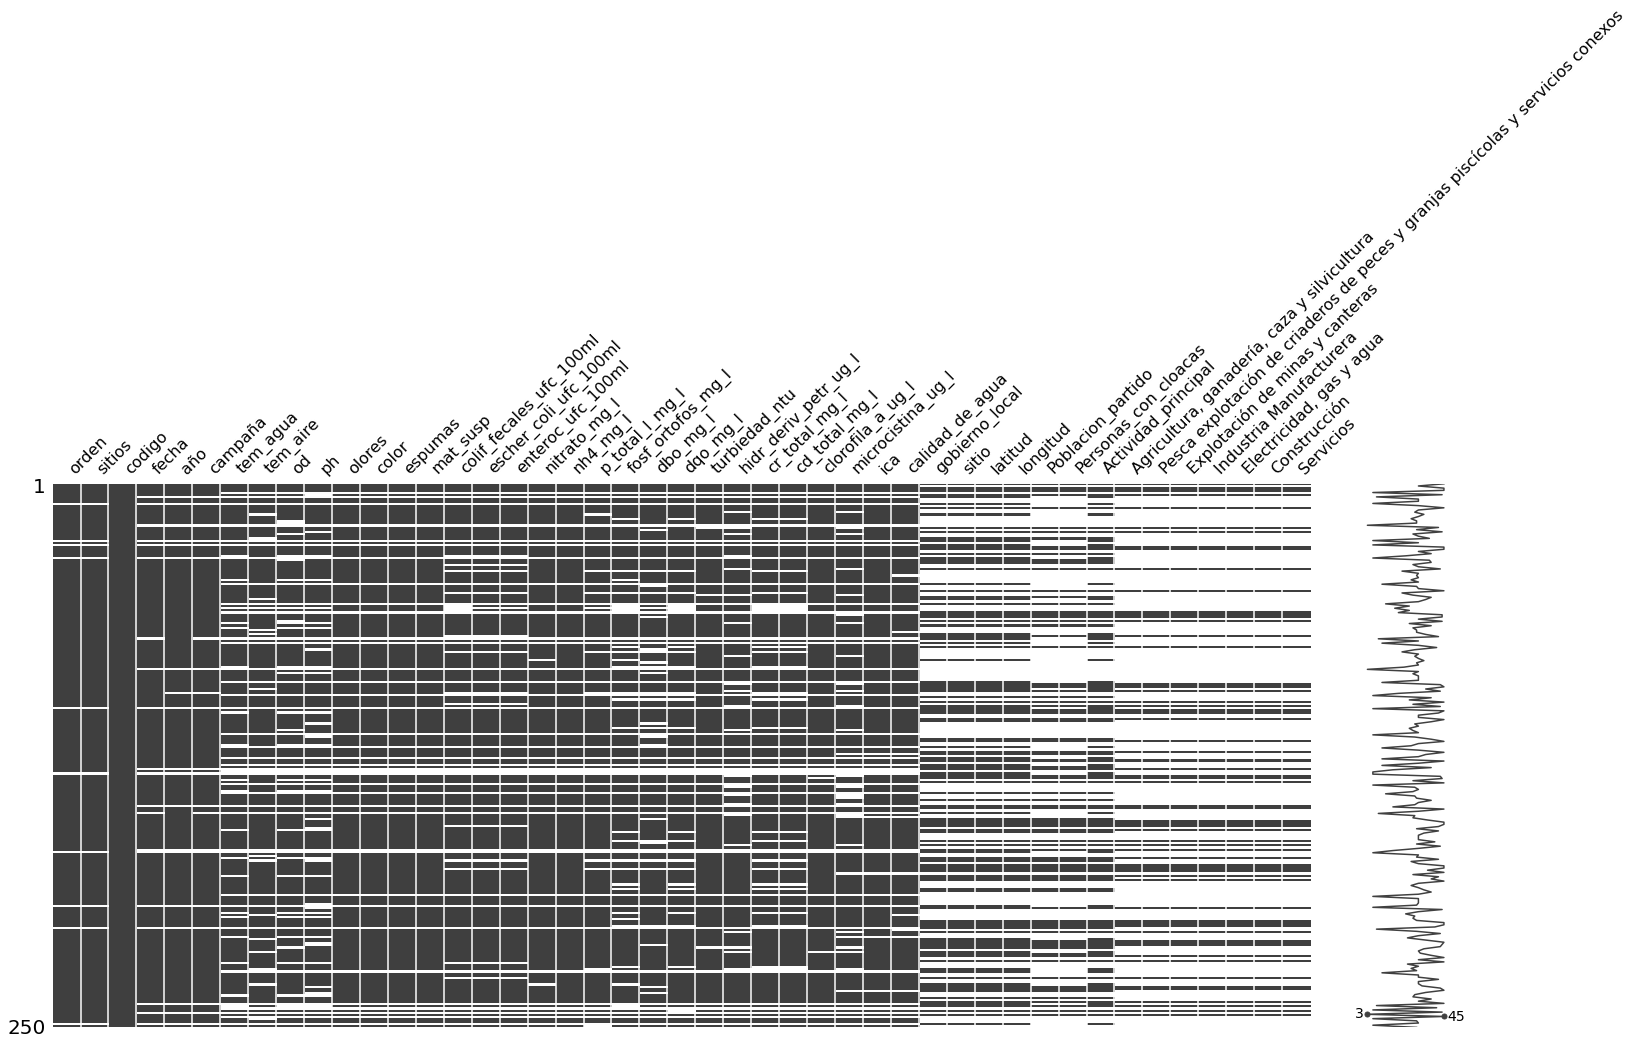

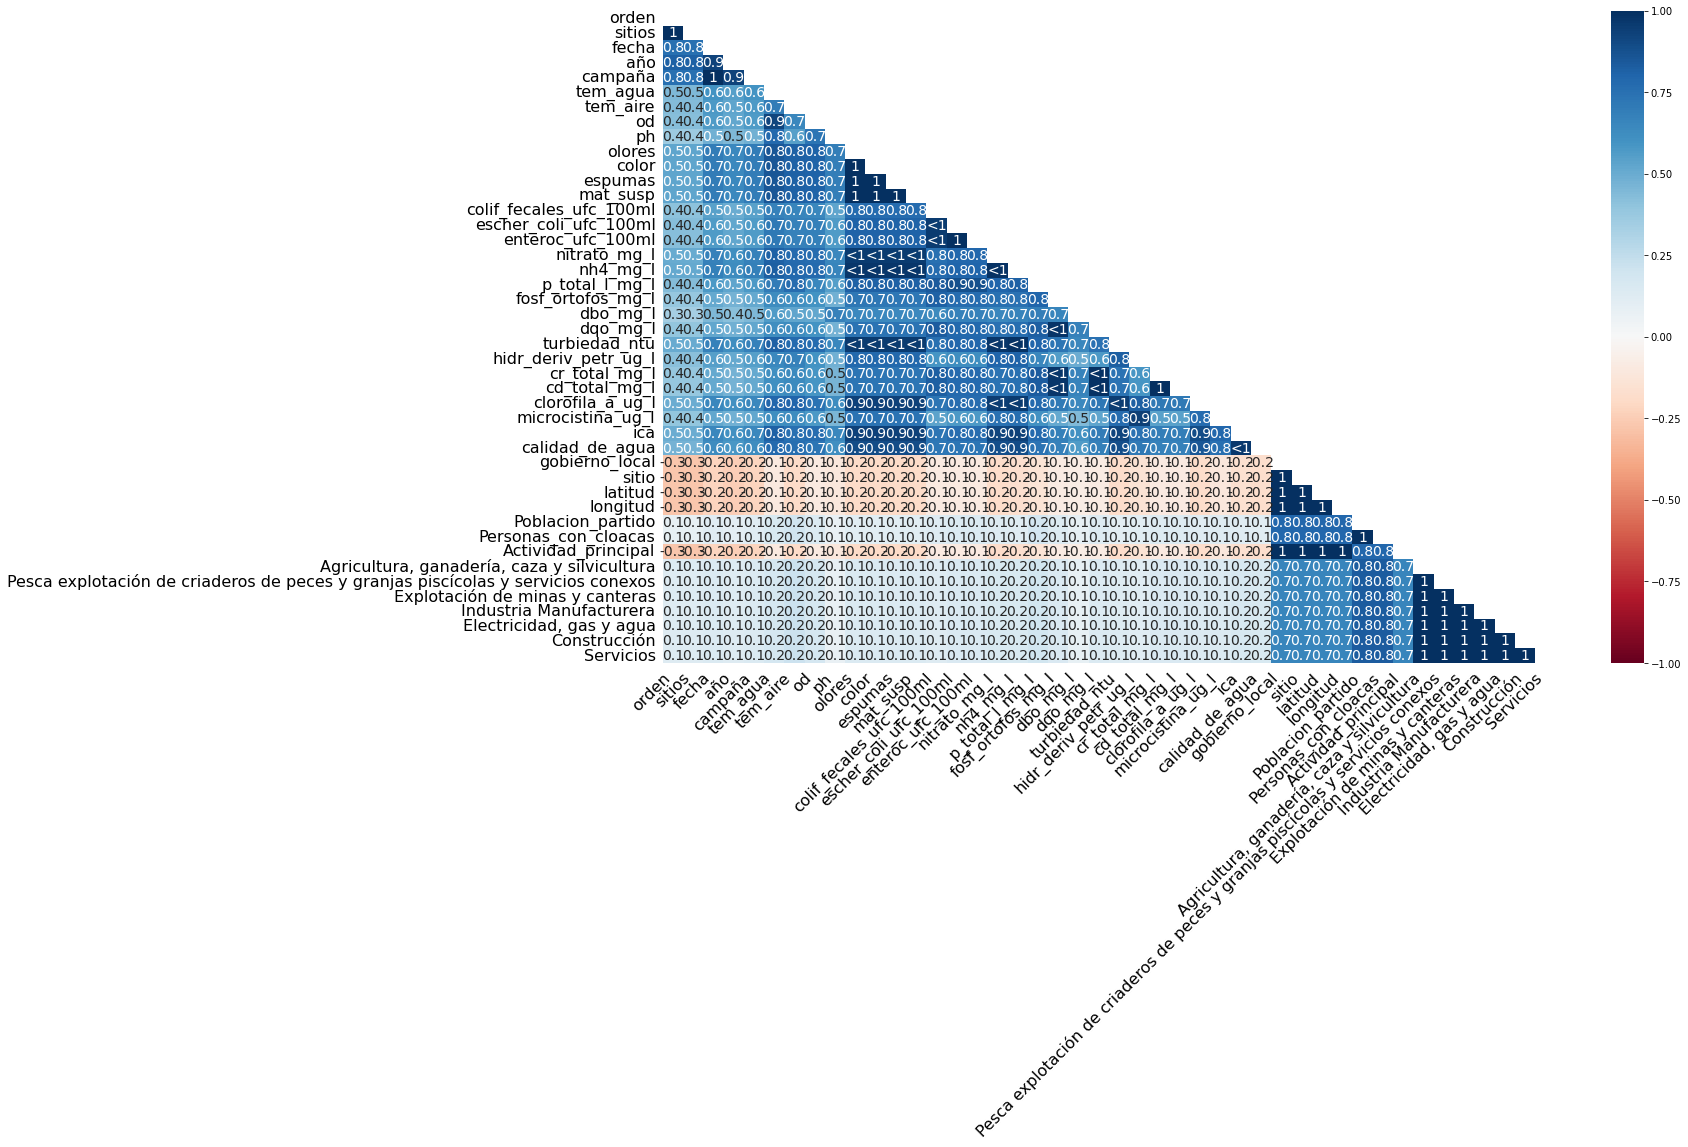

In [193]:
matrix(df7.sample(250))
heatmap(df7.sample(250))

Se observa una fuerte correlación entre datos faltantes. En particular, se ve que hay fuerte correlación entre los datos faltantes de las variables provistas por el Ministerio de Ambiente y Desarrollo Sostenible y entre los datos faltantes de las variables del CENSO y del Programa de Estudios del Conurbano.

**Resumen estadistico**

Al ejecutar el resumen estadístico del dataset, el objetivo principal es obtener una visión general cuantitativa y cualitativa de cada variable. Esto incluye información como: la cantidad de datos disponibles, los valores únicos, la moda, la media, la mediana, los cuartiles, el mínimo y el máximo, así como la desviación estándar para las variables numéricas.

Este análisis permite identificar rápidamente la distribución y características principales de los datos, detectar posibles valores atípicos, entender la diversidad o repetición en variables categóricas, y evaluar la calidad y completitud de la información.

In [135]:
# Resumen estadistico
resumen = df7.describe(include='all')

# Renombrar índices al español
resumen.rename(index={
    'count': 'Cantidad de datos',
    'unique': 'Valores únicos',
    'top': 'Valor más frecuente',
    'freq': 'Frecuencia',
    'mean': 'Promedio',
    'std': 'Desviación estándar',
    'min': 'Mínimo',
    '25%': 'Percentil 25',
    '50%': 'Mediana (Percentil 50)',
    '75%': 'Percentil 75',
    'max': 'Máximo'
}, inplace=True)

# Función para alternar colores en filas
def estilo_tabla(s):
    colores = ['#f9f9f9', '#e0f7fa']
    return ['background-color: {}'.format(colores[i % 2]) for i in range(len(s))]

# Aplicar estilo y mostrar
styled_resumen = resumen.style.apply(estilo_tabla, axis=0)\
                             .set_properties(**{'font-weight': 'bold'}, subset=pd.IndexSlice[['Cantidad de datos', 'Valores únicos', 'Frecuencia', 'Desviación estándar'], :])\
                             .set_table_styles([{
                                'selector': 'th',
                                'props': [('background-color', '#00796b'), ('color', 'white'), ('font-weight', 'bold')]
                             }])

print("\nResumen estadístico")
display(styled_resumen)

ImportError: Pandas requires version '3.1.2' or newer of 'jinja2' (version '3.0.3' currently installed).

Al observar el resumen estadístico del dataset, se puede observar que algunas columnas tienen una cantidad menor de datos registrados, lo que indica la presencia de valores faltantes. Por ejemplo, mientras que variables como el código o la fecha cuentan con casi todos los datos, otras como las mediciones químicas o físicas tienen menos registros completos.

Se destaca que algunas columnas contienen valores categóricos, como el nombre de los sitios, la campaña o la estación del año, donde el valor más frecuente se repite muchas veces, reflejando condiciones comunes o datos estándar (como “invierno” o “Ausencia” en ciertas mediciones).

En las columnas numéricas, el promedio, la desviación estándar y los percentiles muestran la distribución de los datos cuando están presentes, pero muchos valores son nulos, lo que implica que será necesario realizar un tratamiento especial para estos datos faltantes antes de hacer un análisis más profundo.

**Distribucion de las variables**

Los gráfico de histogramas muestra cómo se distribuyen los valores de cada variable numérica en el dataset. Permite visualizar si los datos están concentrados alrededor de ciertos rangos, si presentan sesgos hacia un extremo, o si existen valores atípicos o outliers. Además, ayuda a identificar la forma de la distribución por ejemplo, si es normal, sesgada o multimodal.

Iniciamos graficando histogramas para variables numéricas. Para cada variable usaremos 3 histogramas: El del df original, el de df7, con las correcciones señaladas arriba, y un tercer histograma con un df8, en el que se cambiarán las imputaciones de los valores de forma '<x' por x.

In [194]:
df8 = df7.copy(deep=True)

for col in numericas:
    # Extraer y convertir los valores numéricos (incluyendo "<x")
    valores = (
        df[col]
        .astype(str)  # Convertir todo a string para manejar consistentemente
        .str.extract(r'<?(\d+\.?\d*)', expand=False)  # Extraer la parte numérica (ignorando "<")
        .astype(float)  # Convertir a float (maneja enteros y decimales)
    )
    df8[col] = valores

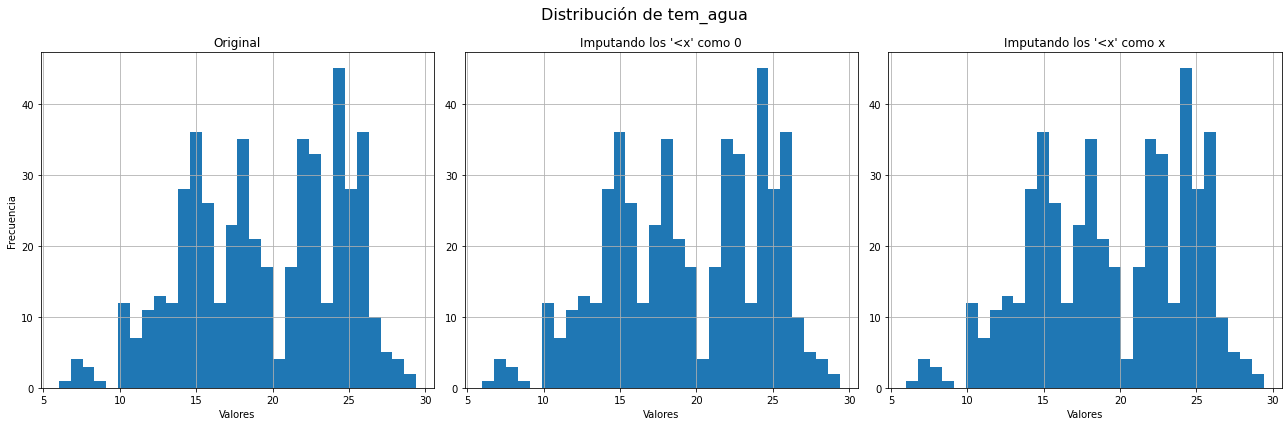

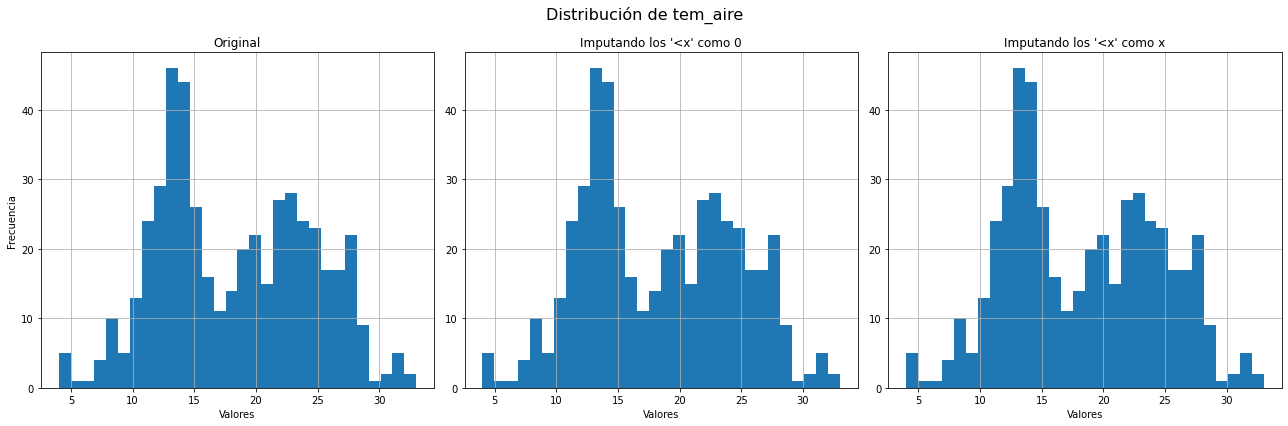

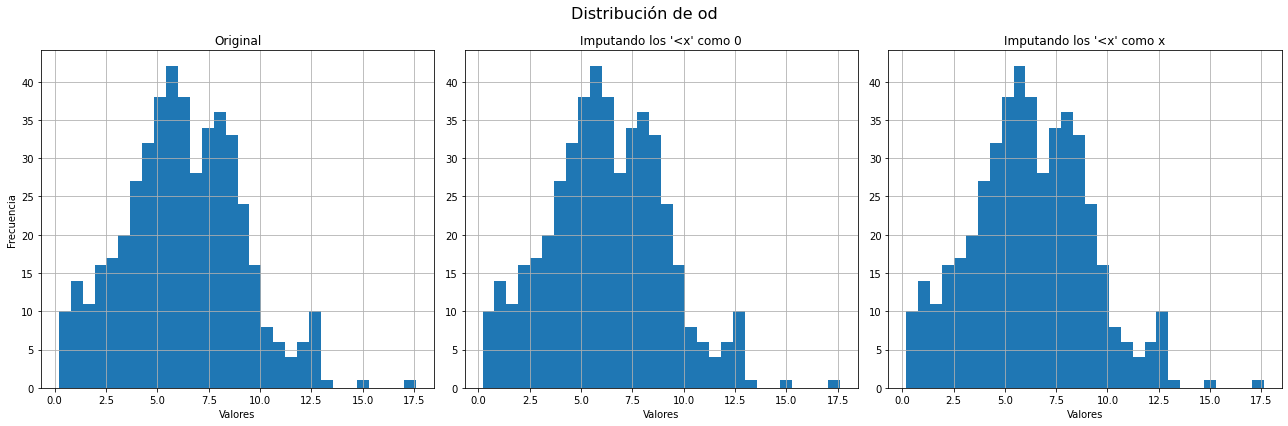

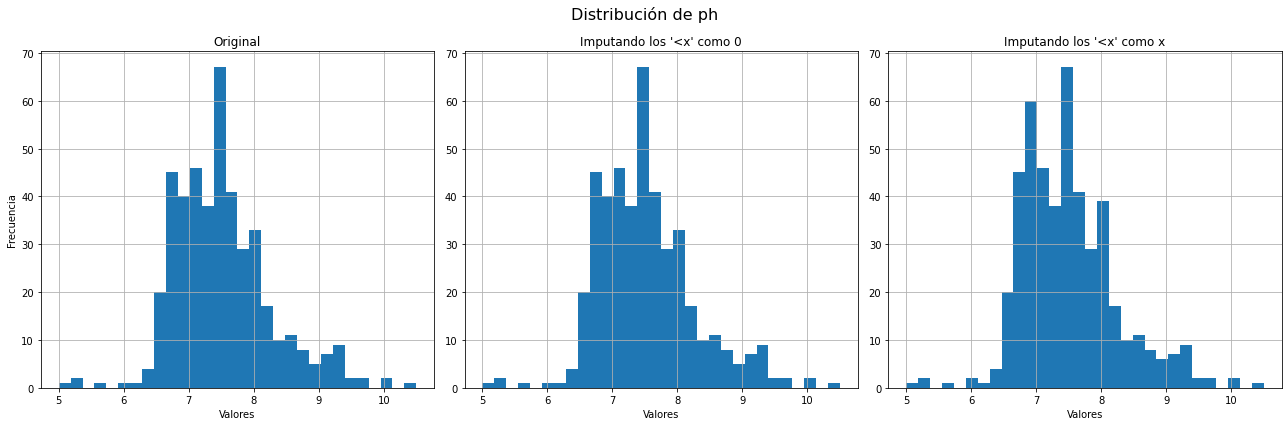

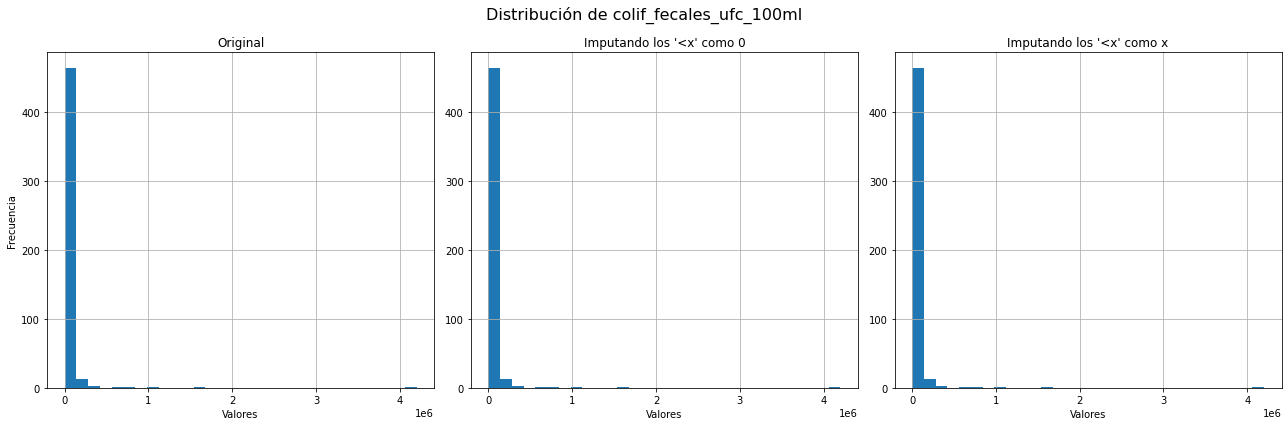

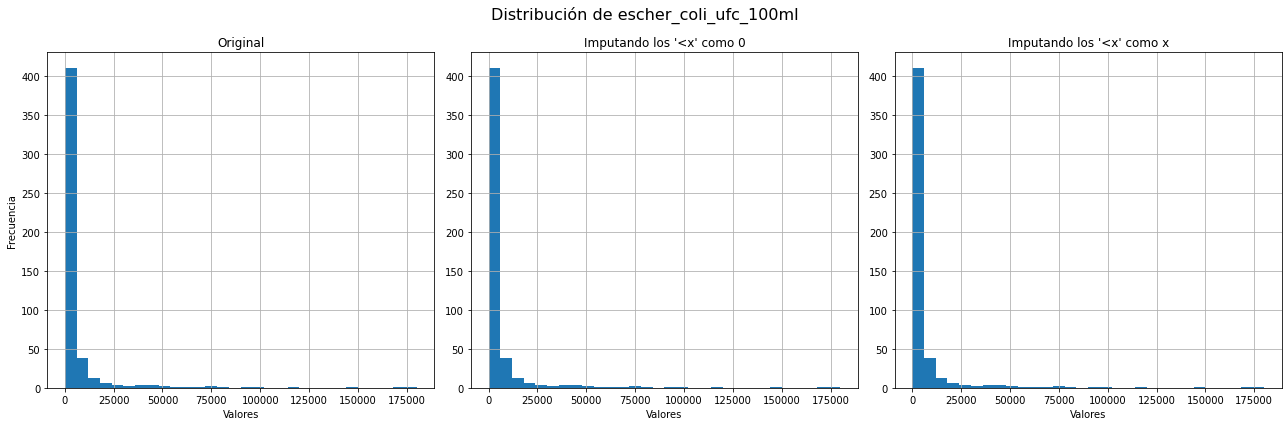

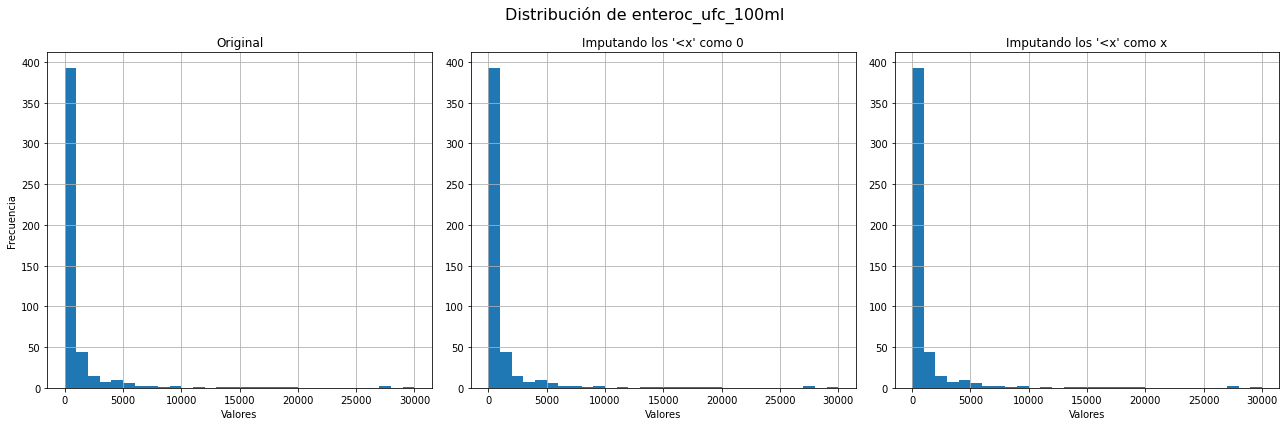

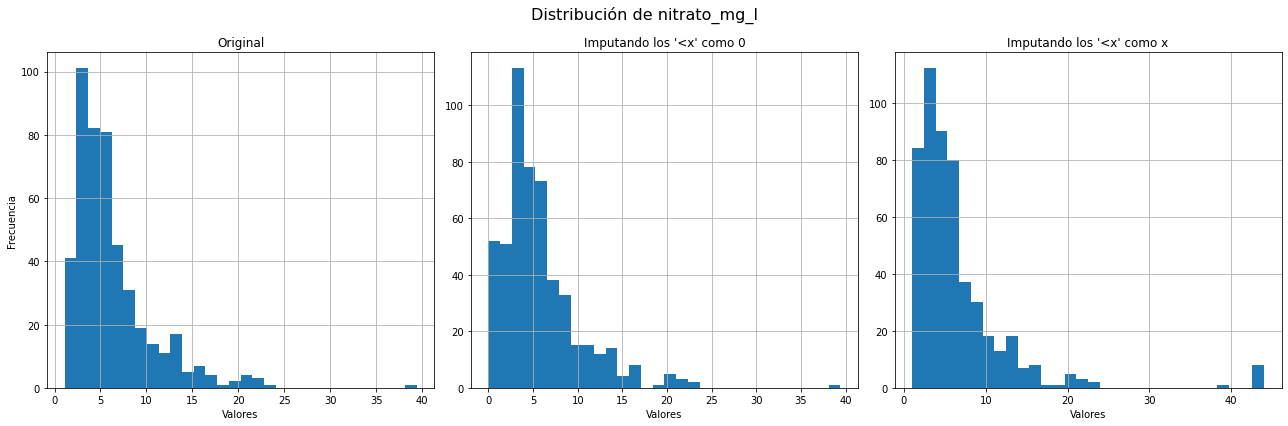

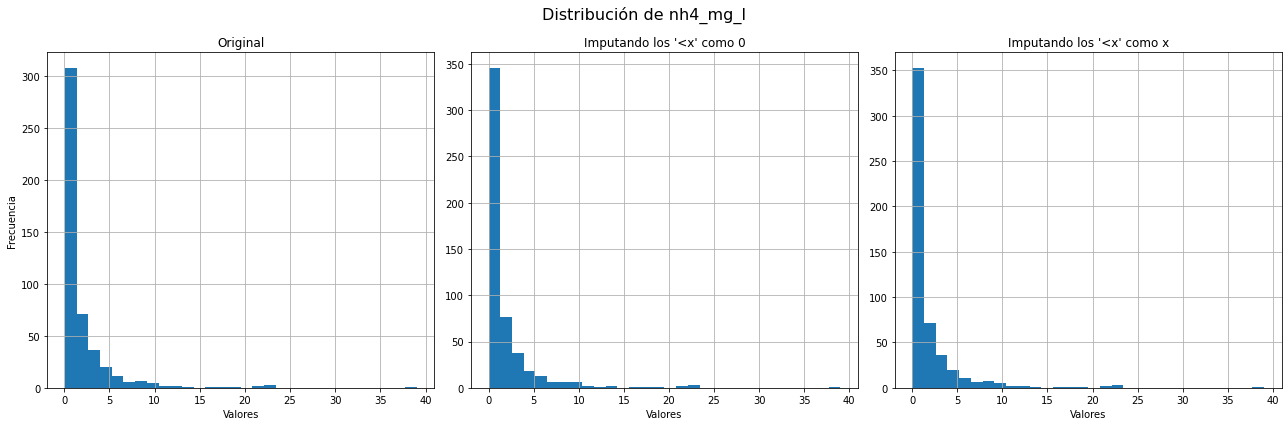

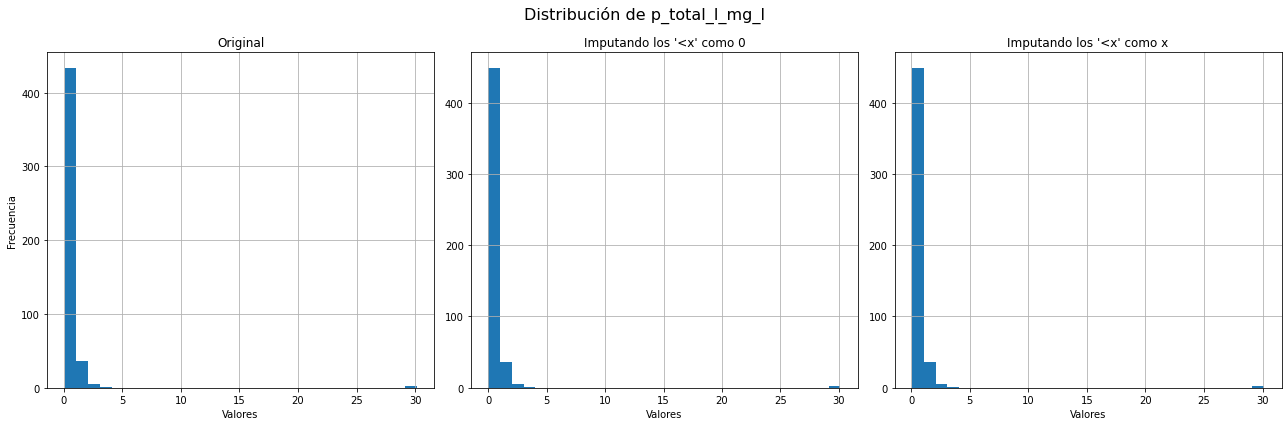

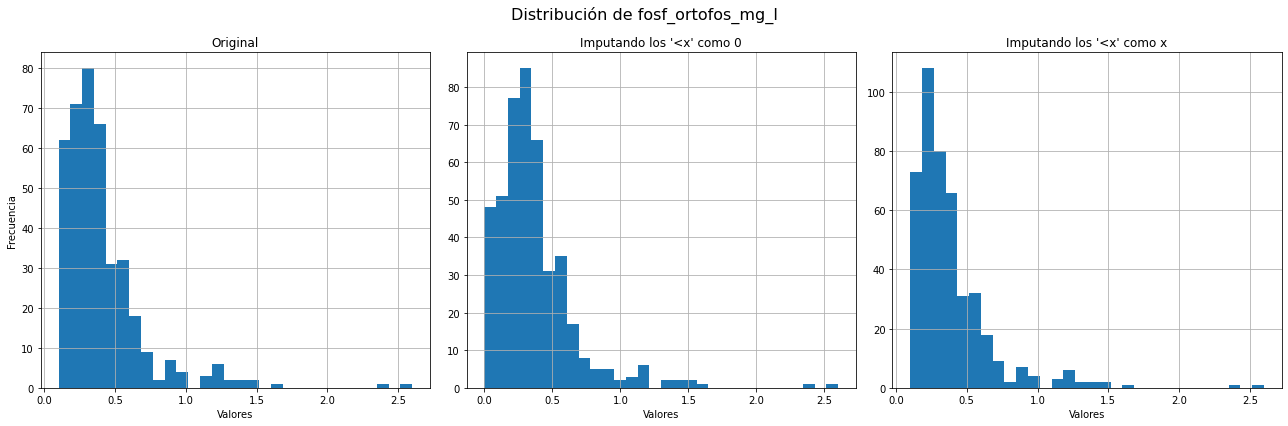

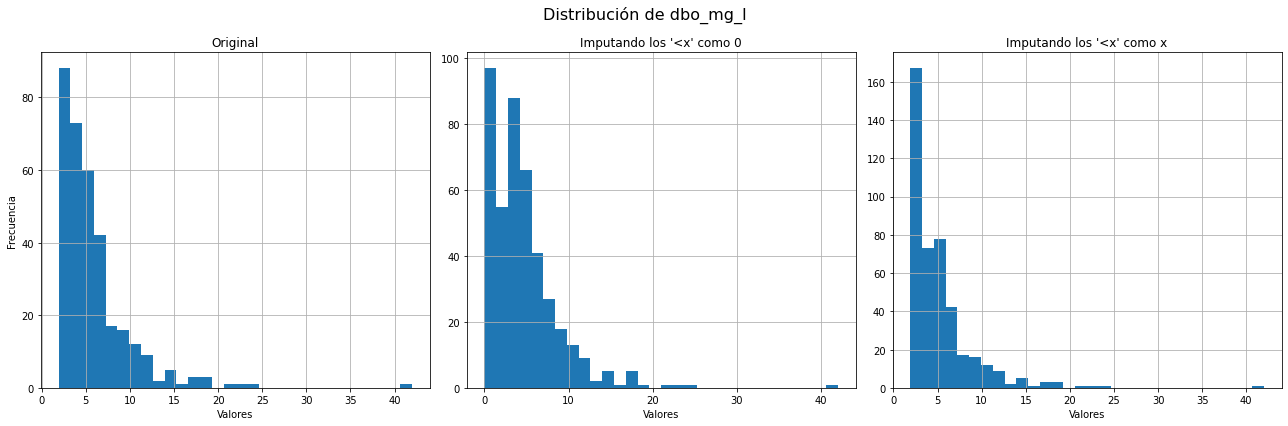

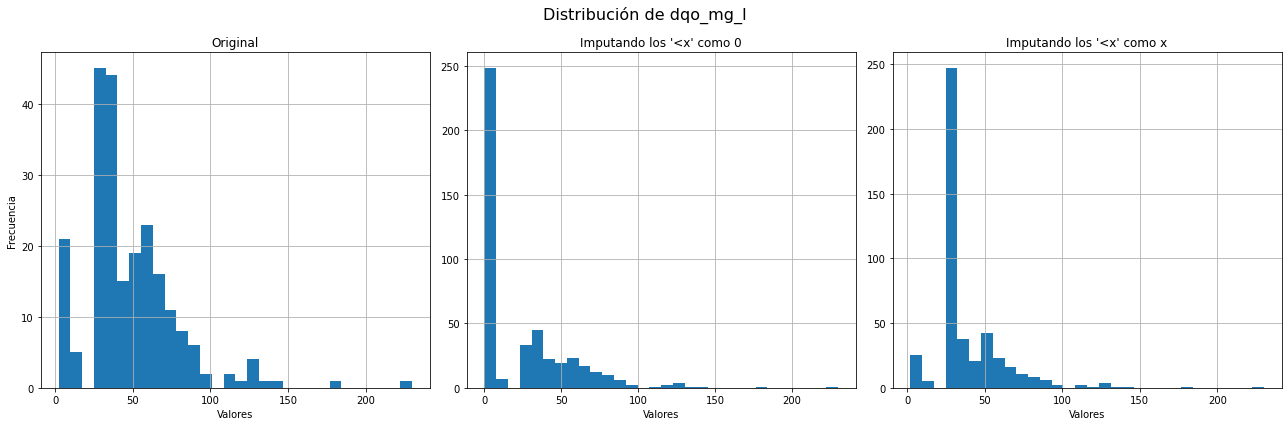

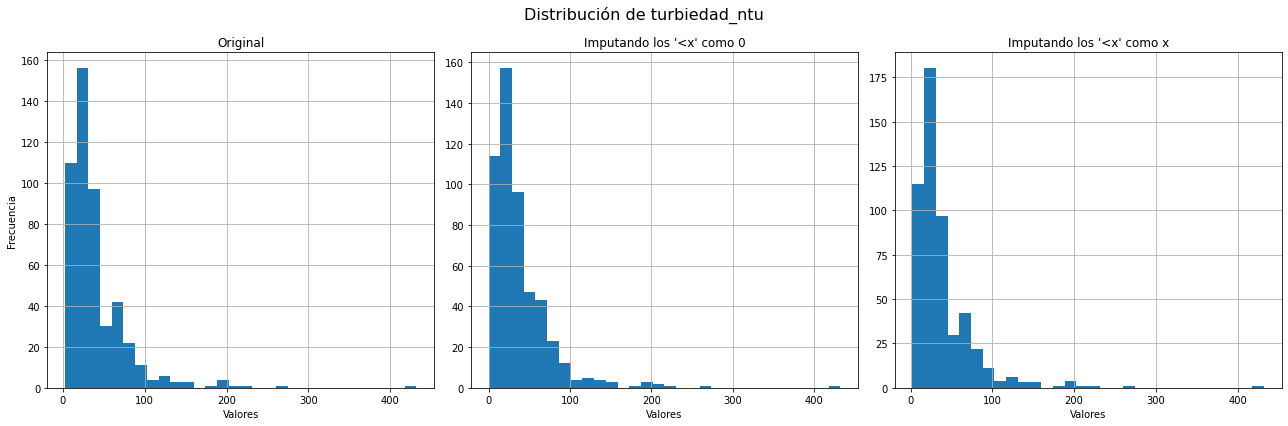

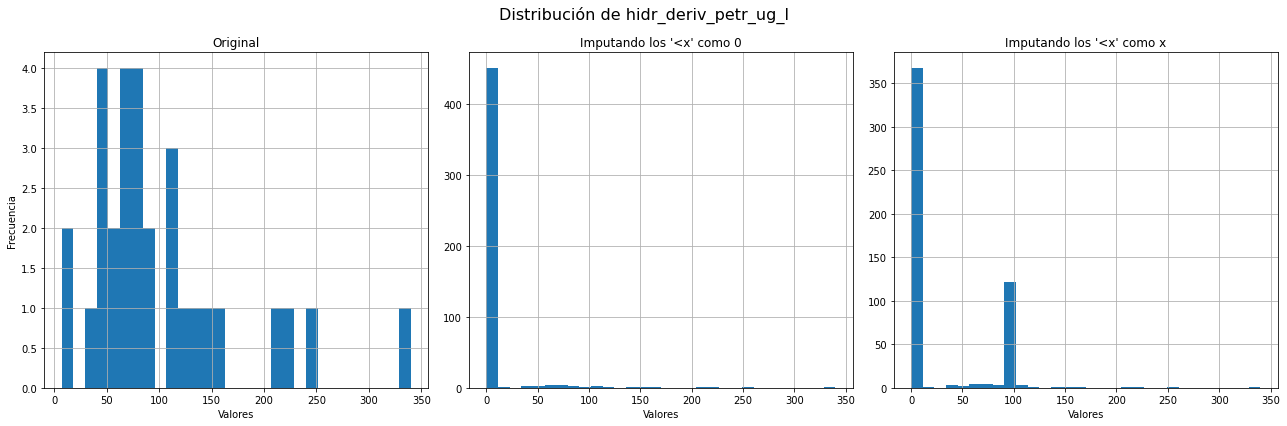

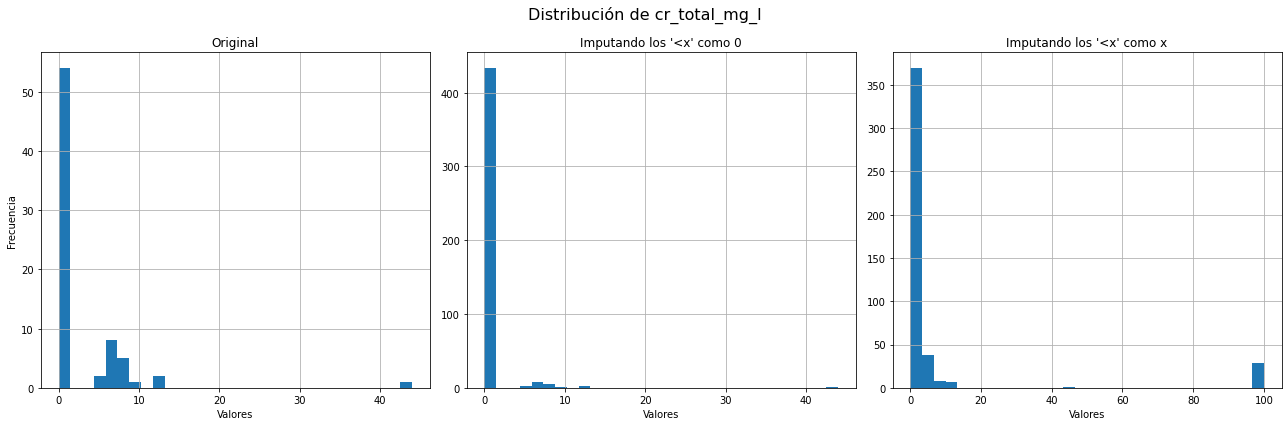

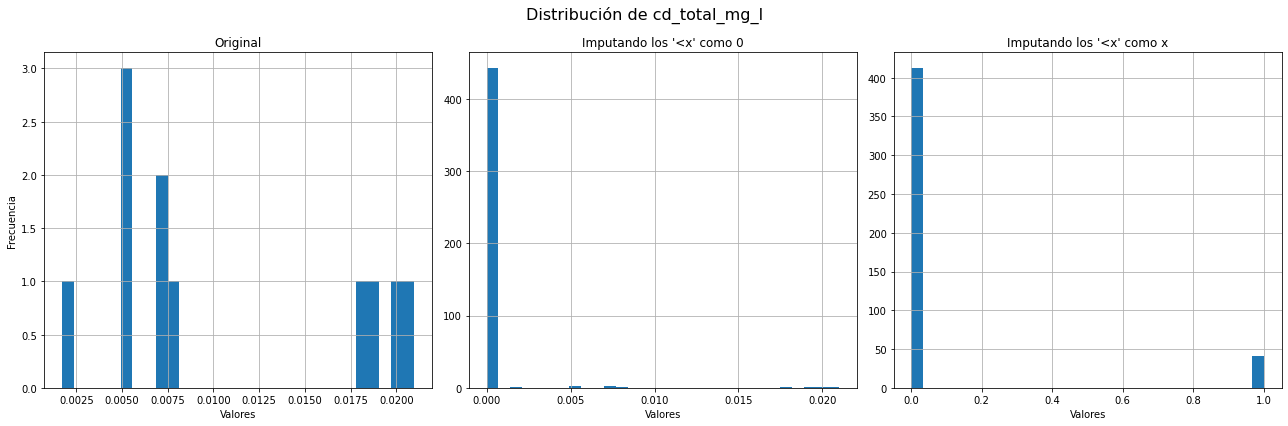

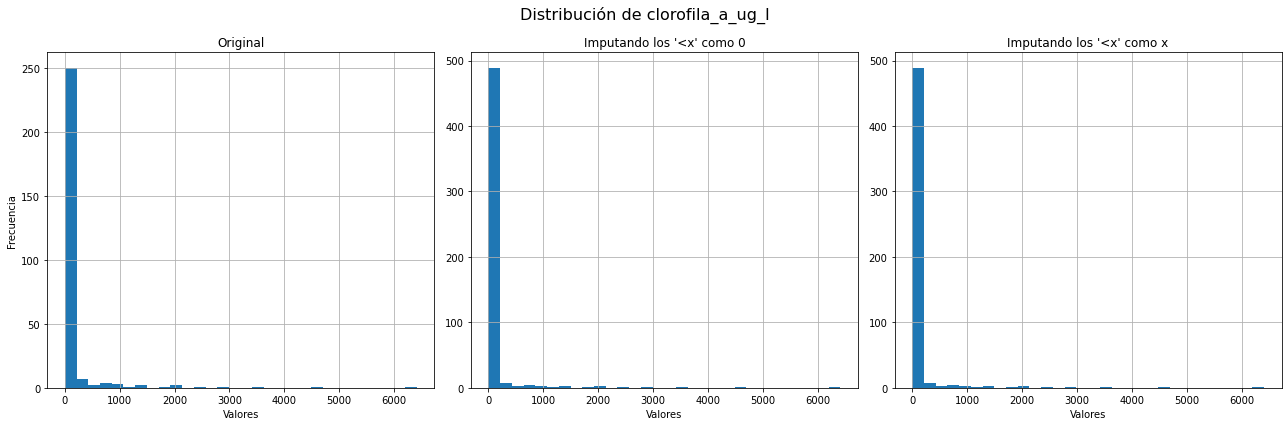

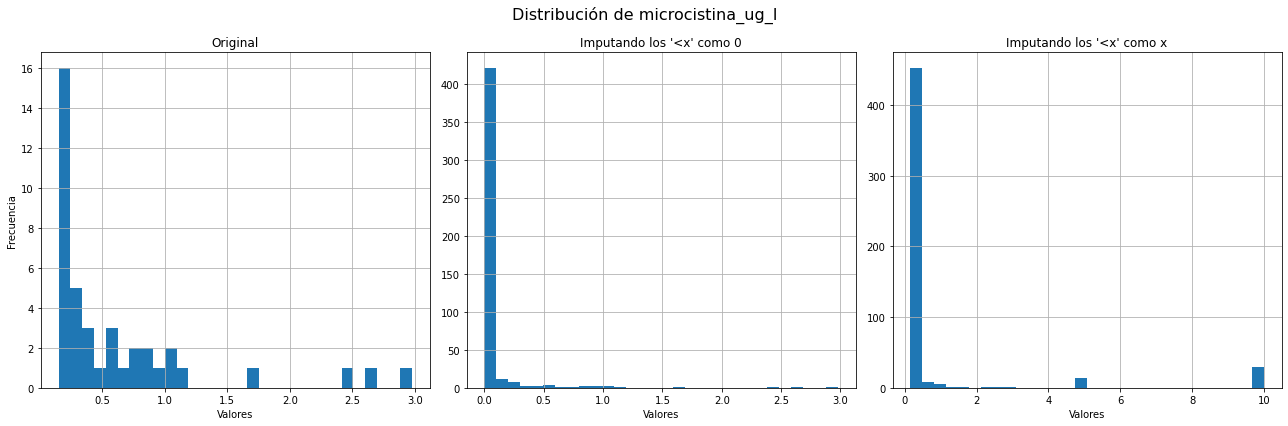

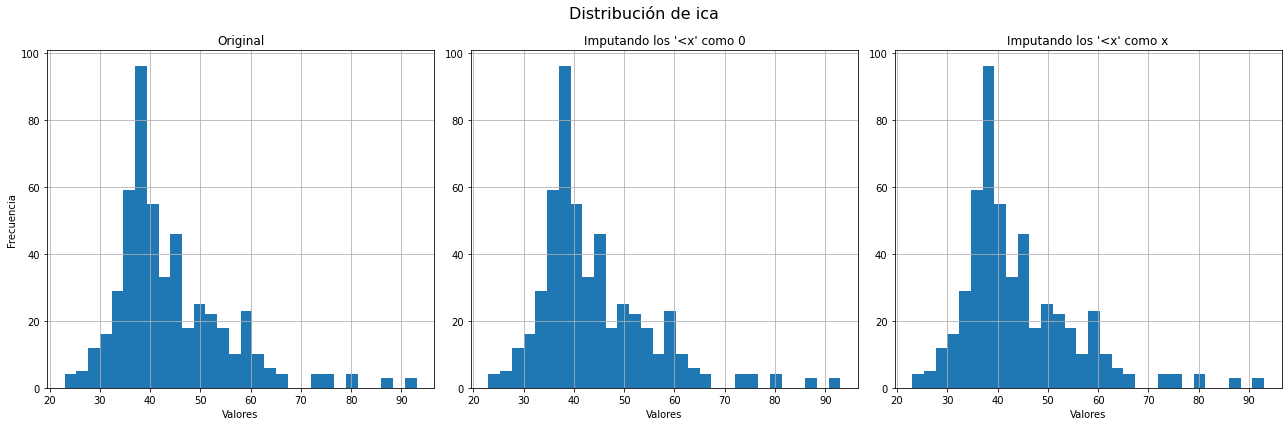

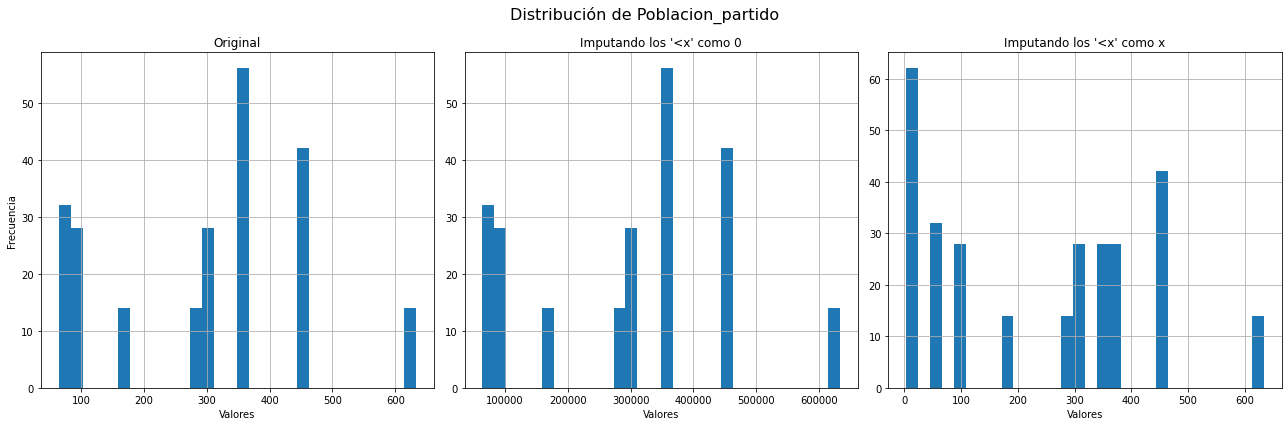

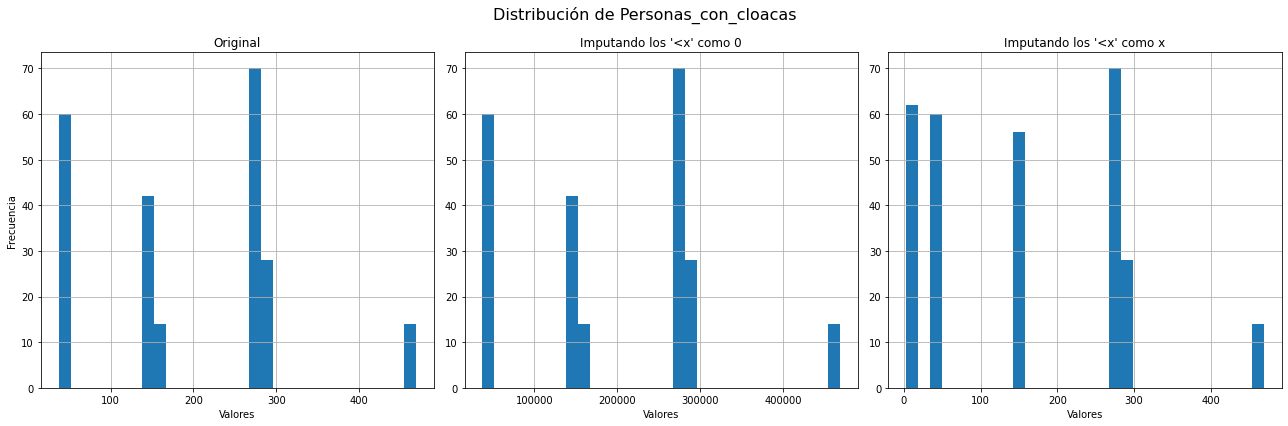

In [195]:
for col in numericas:
    # Crear figura y subgráficos (1 fila, 3 columnas)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(f"Distribución de {col}", fontsize=16)
    
    # Creo copia de df original asegurando que en las variables numéricas se tengan sólo valores numéricos
        # (Se imputan como NaN todos los no numéricos, inclusive los '<x')
    df_copy = df.copy(deep=True)
    df_copy[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Lista de DataFrames y títulos para cada subgráfico
    dataframes = [df_copy, df7, df8]
    titles = ['Original', 'Imputando los \'<x\' como 0', 'Imputando los \'<x\' como x']

    # Graficar histogramas para cada DataFrame
    for i, (data, ax, title) in enumerate(zip(dataframes, axes, titles)):
        data[col].hist(bins=30, ax=ax)  # Usar ax=ax para dirigir al subgráfico correcto
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Valores")
        if i == 0:  # Solo añadir etiqueta Y al primer subgráfico para evitar redundancia
            ax.set_ylabel("Frecuencia")

    # Ajustar layout y mostrar
    plt.tight_layout()
    plt.show()

Veamos histogramas de variables categóricas

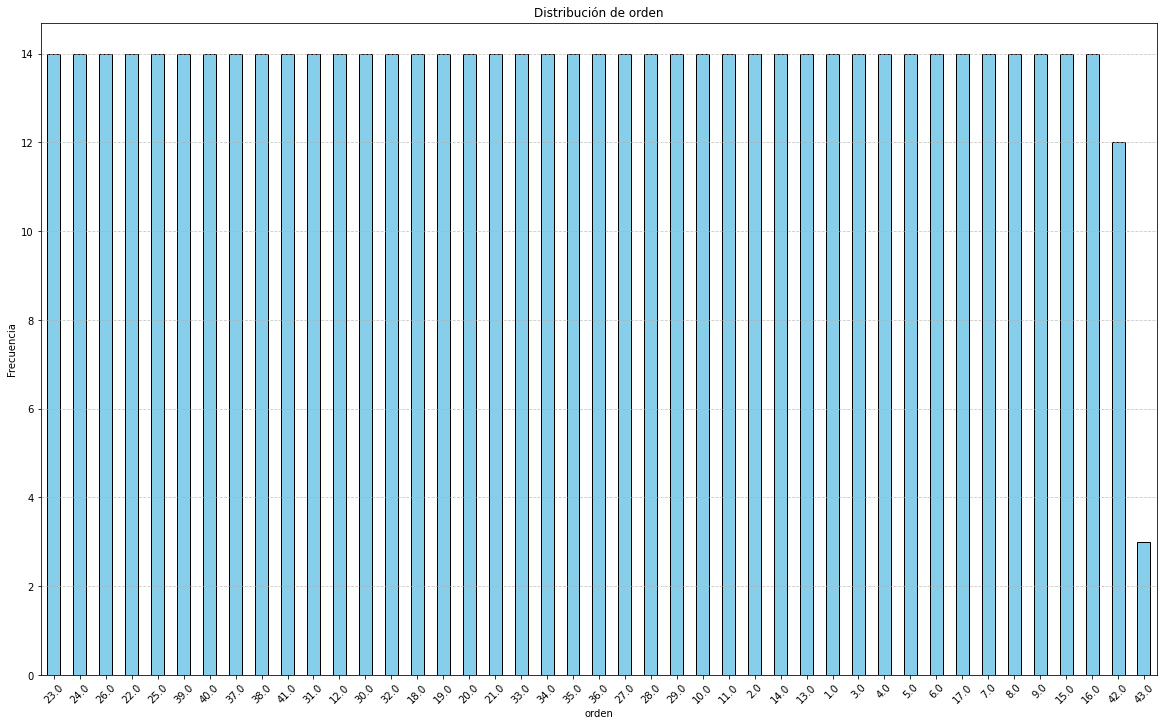

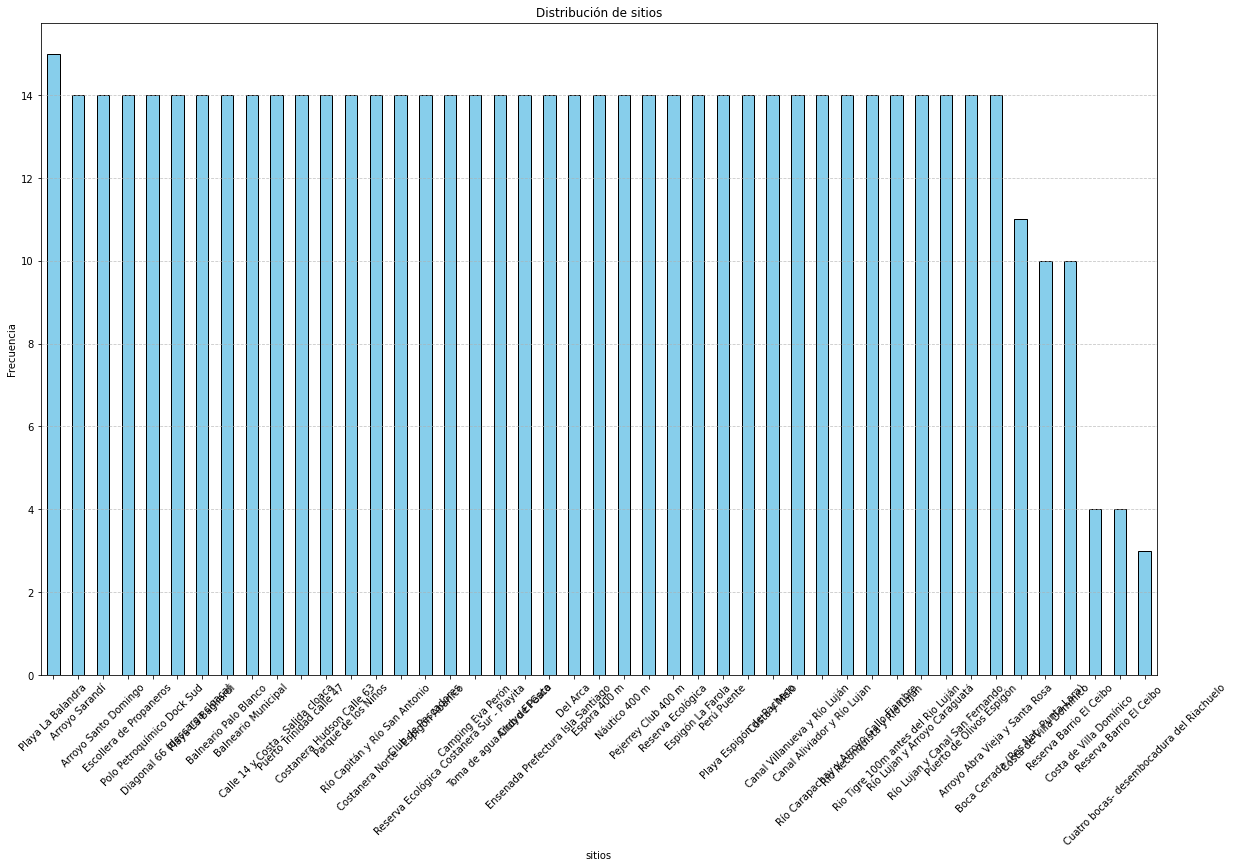

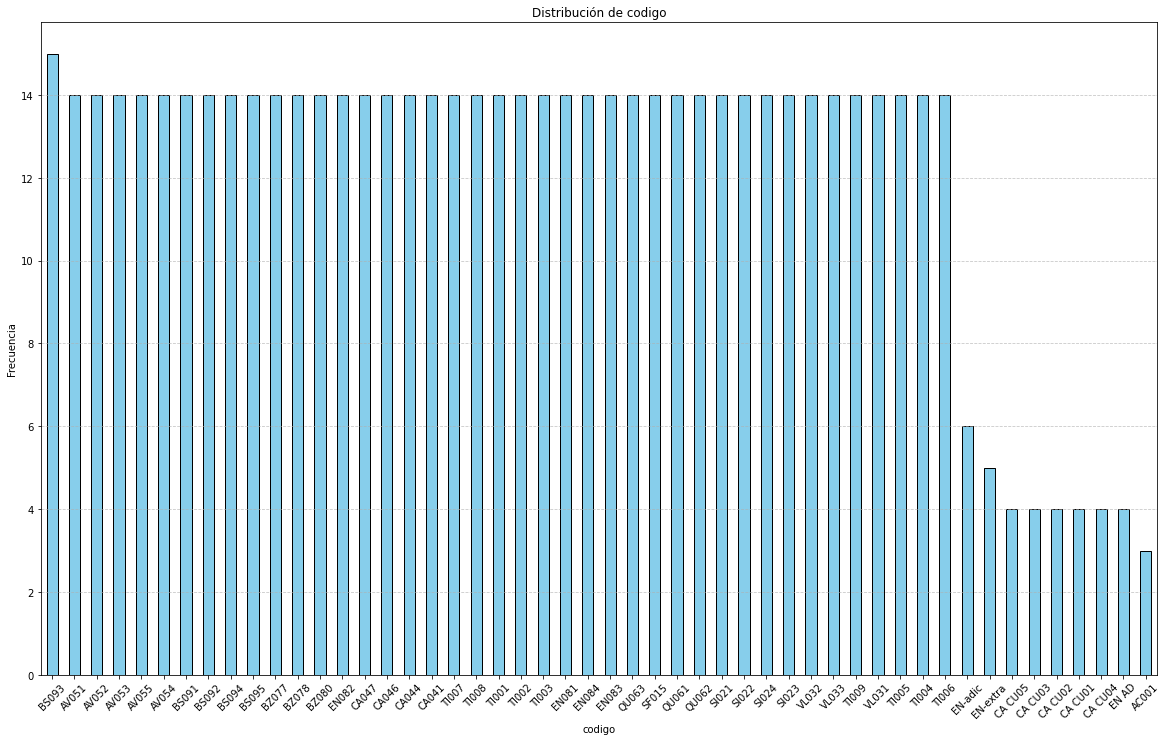

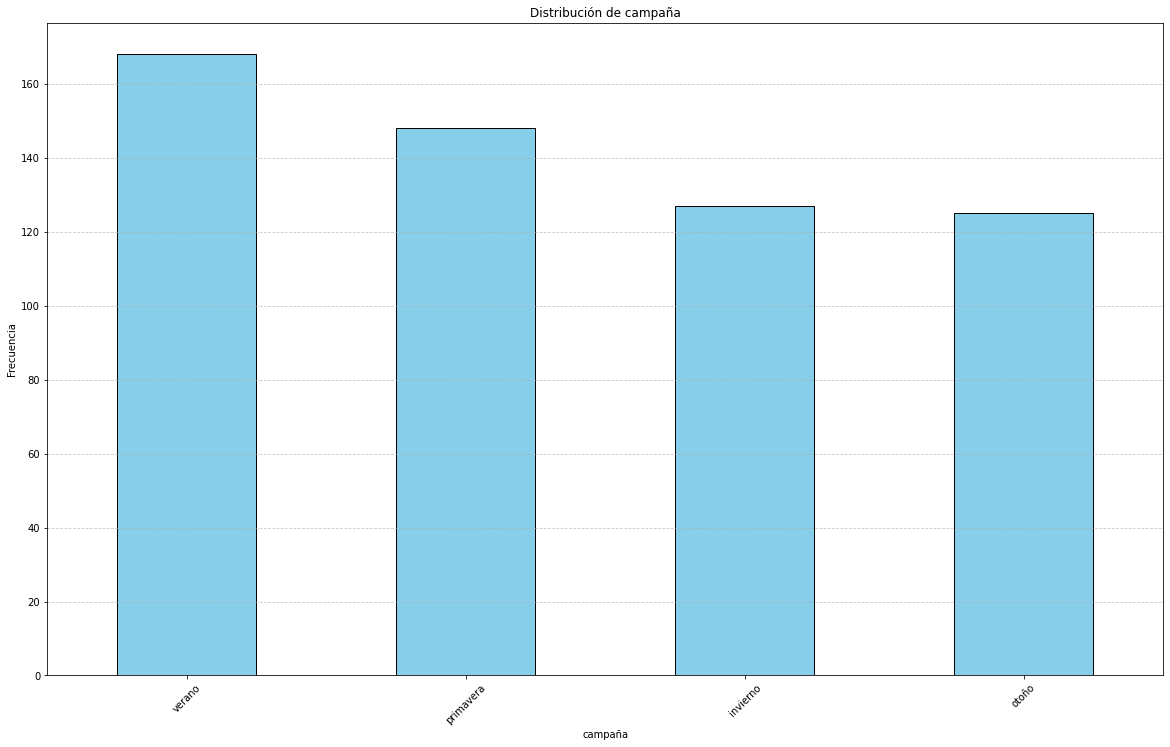

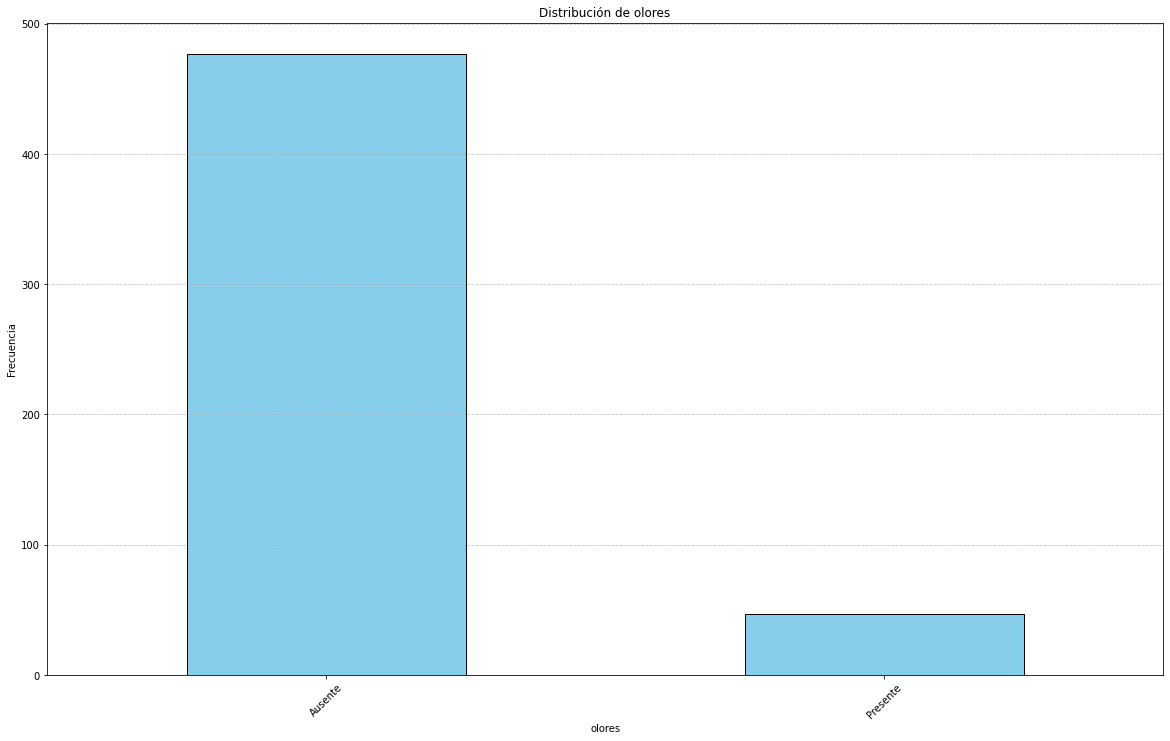

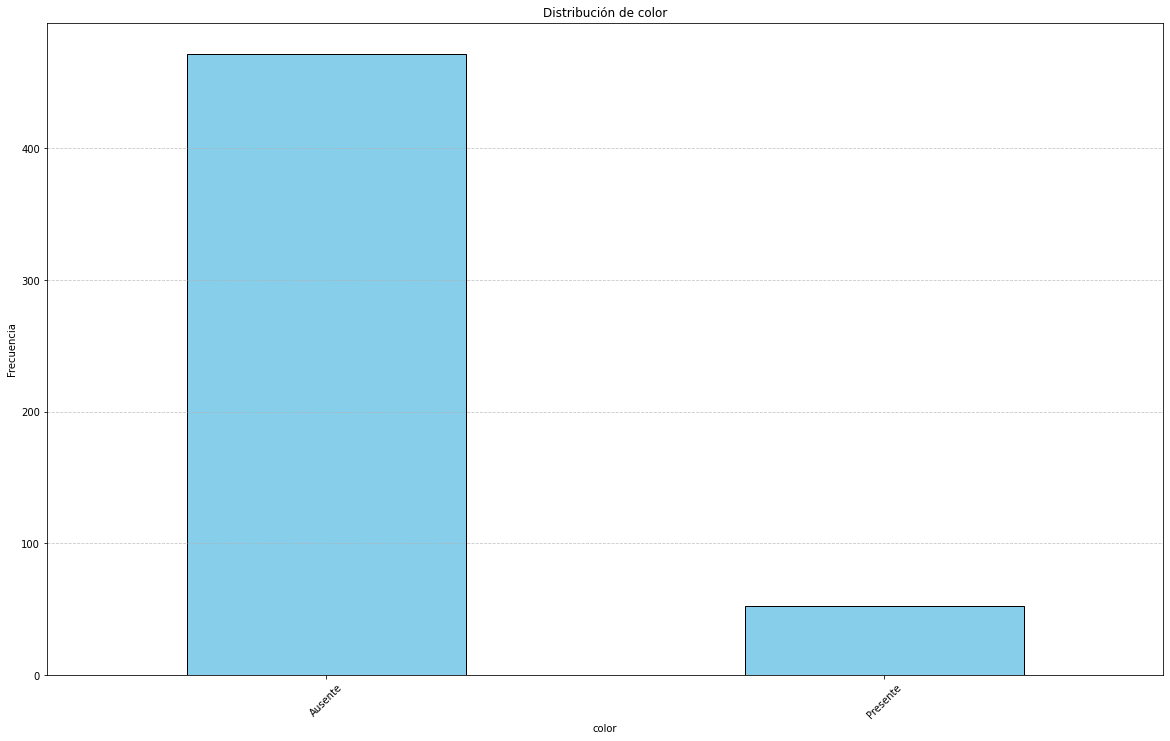

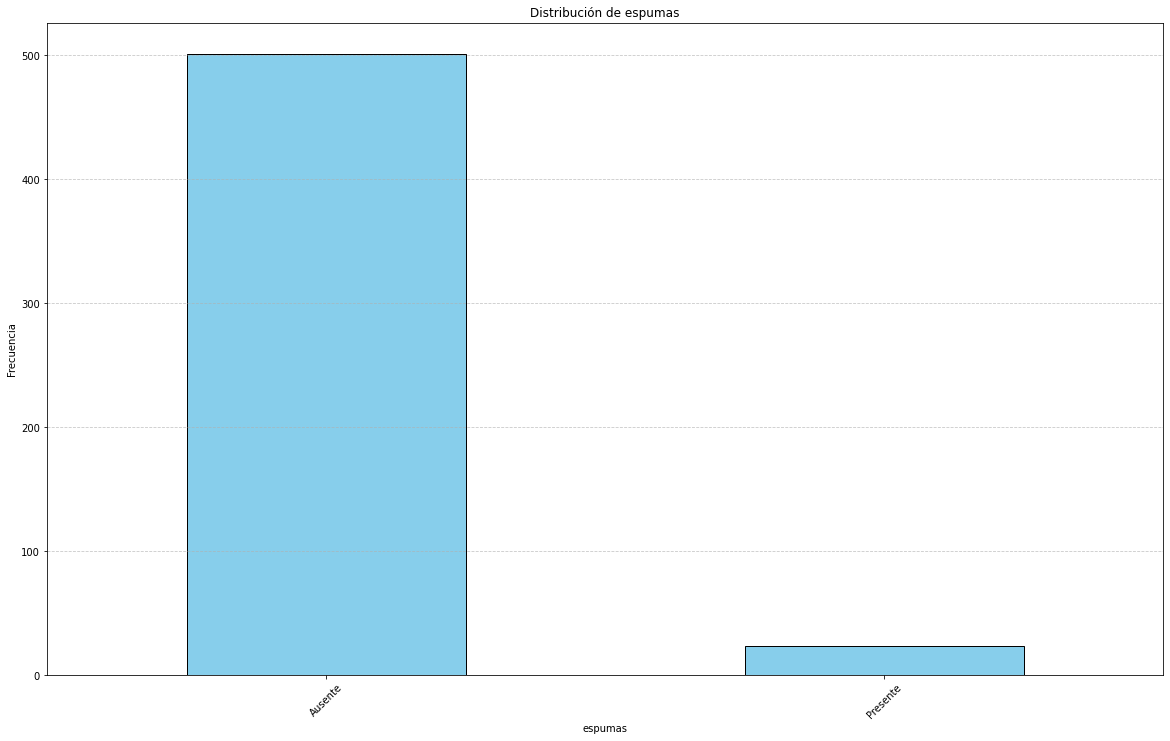

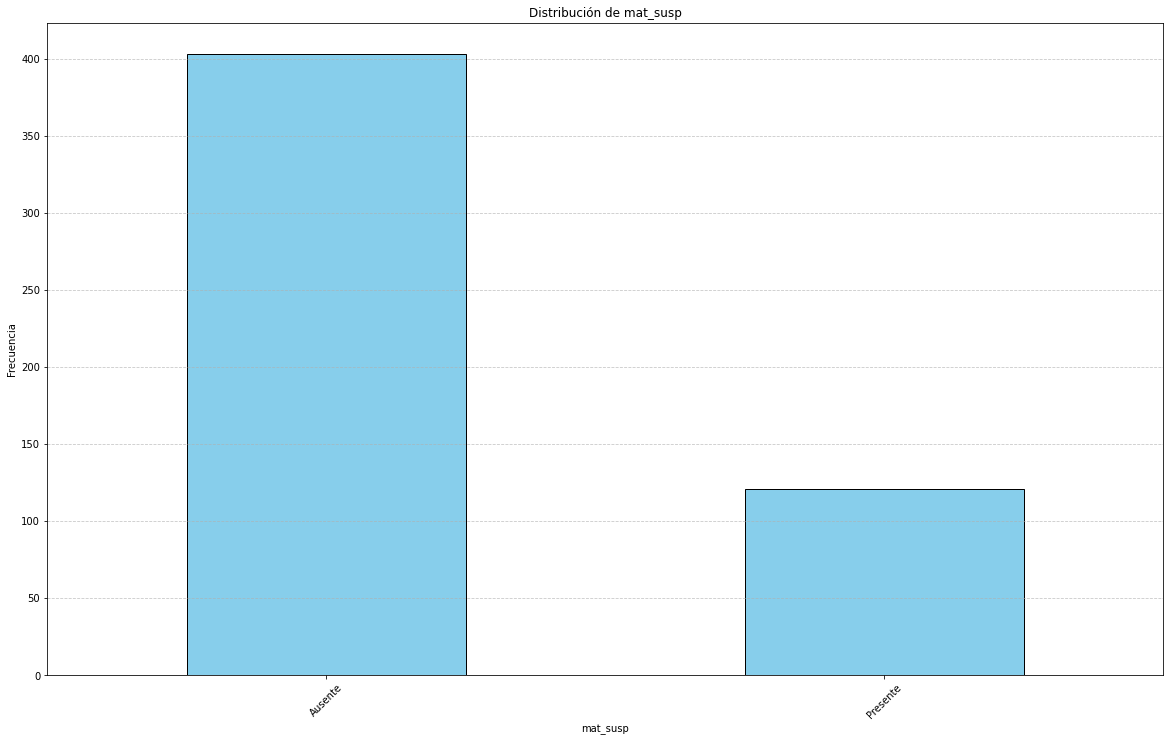

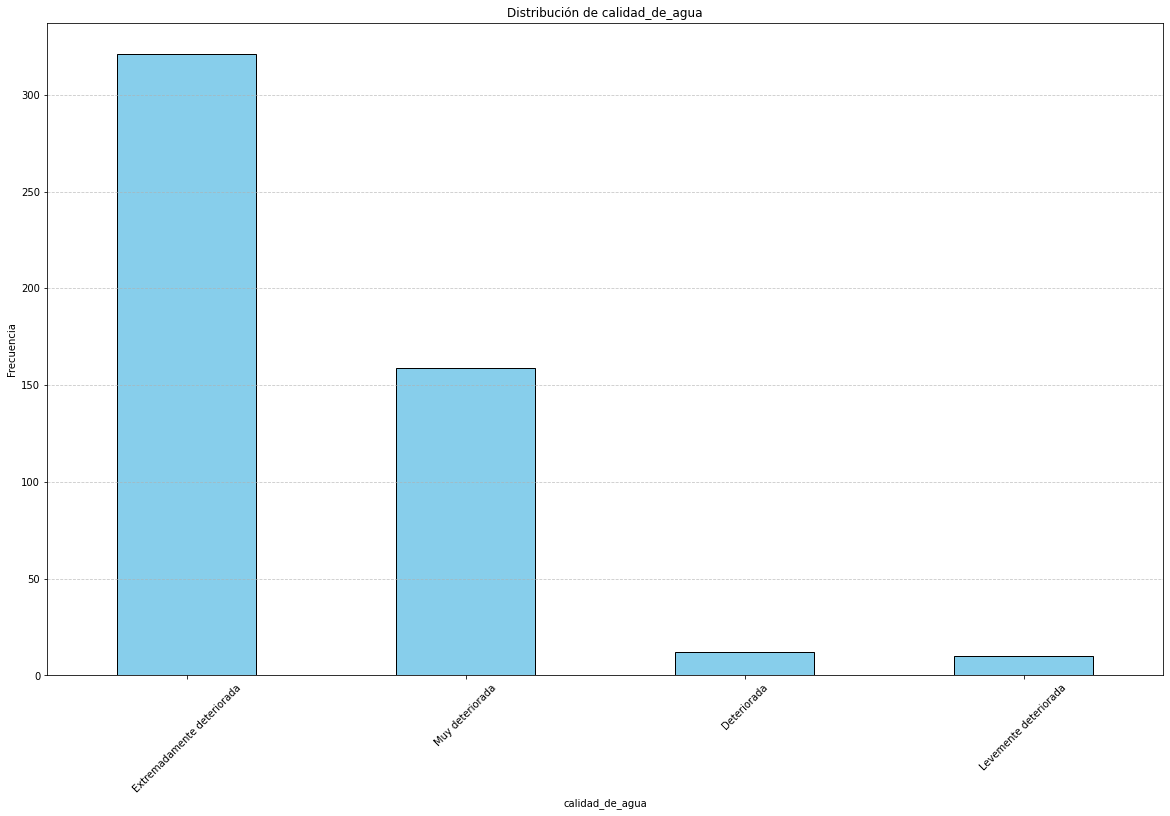

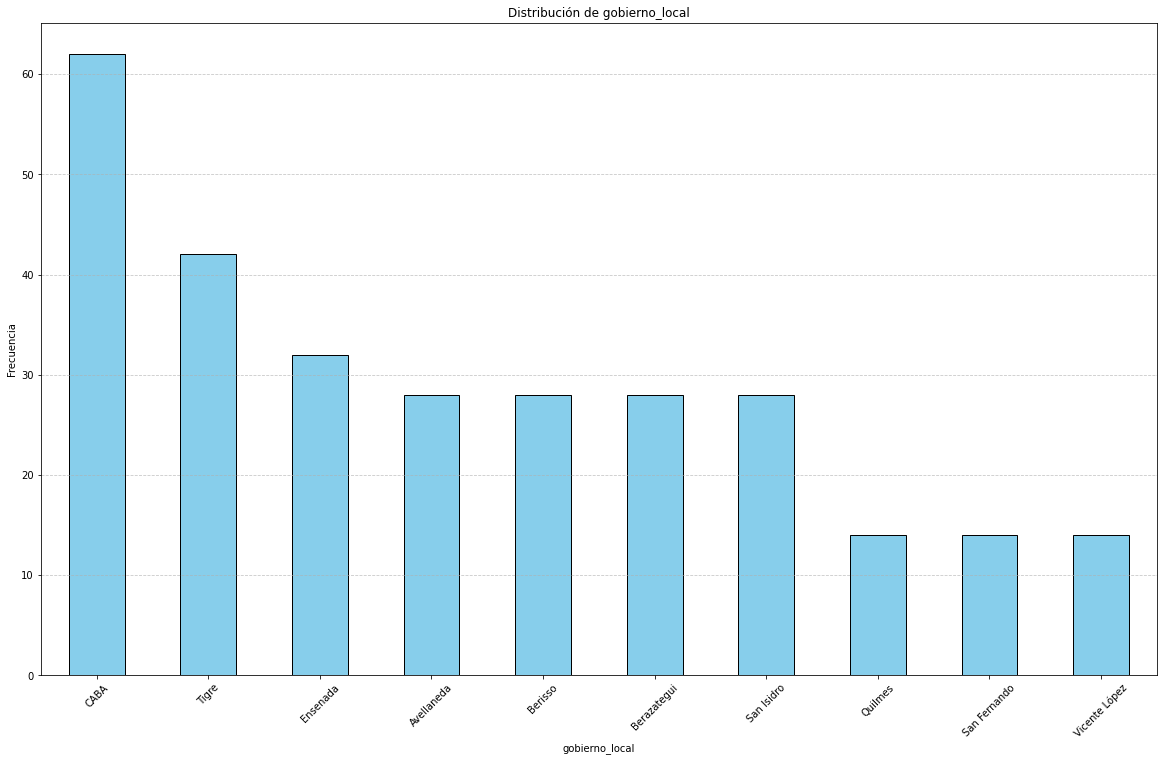

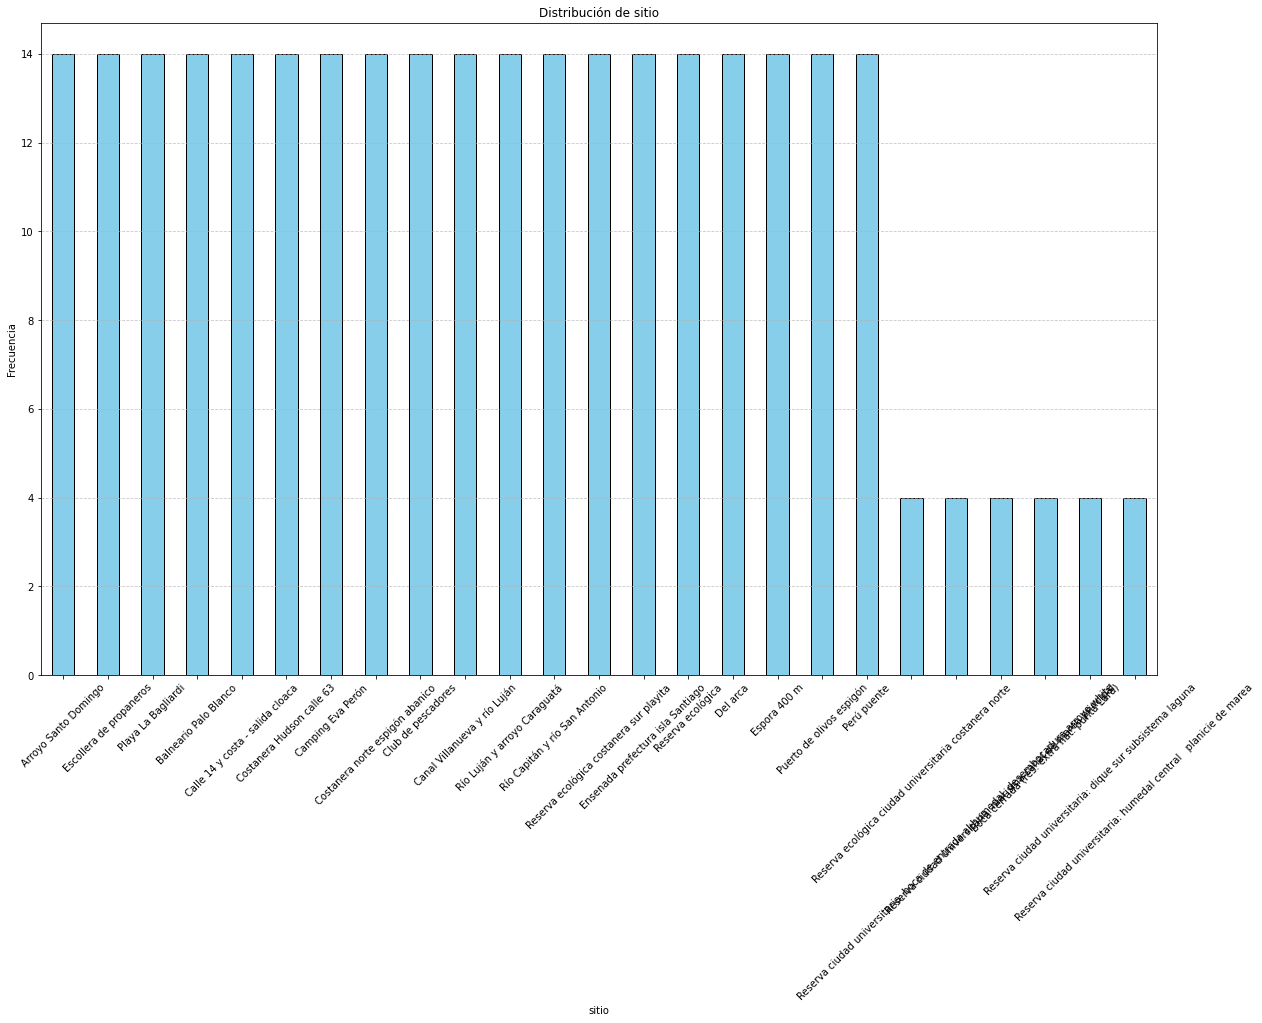

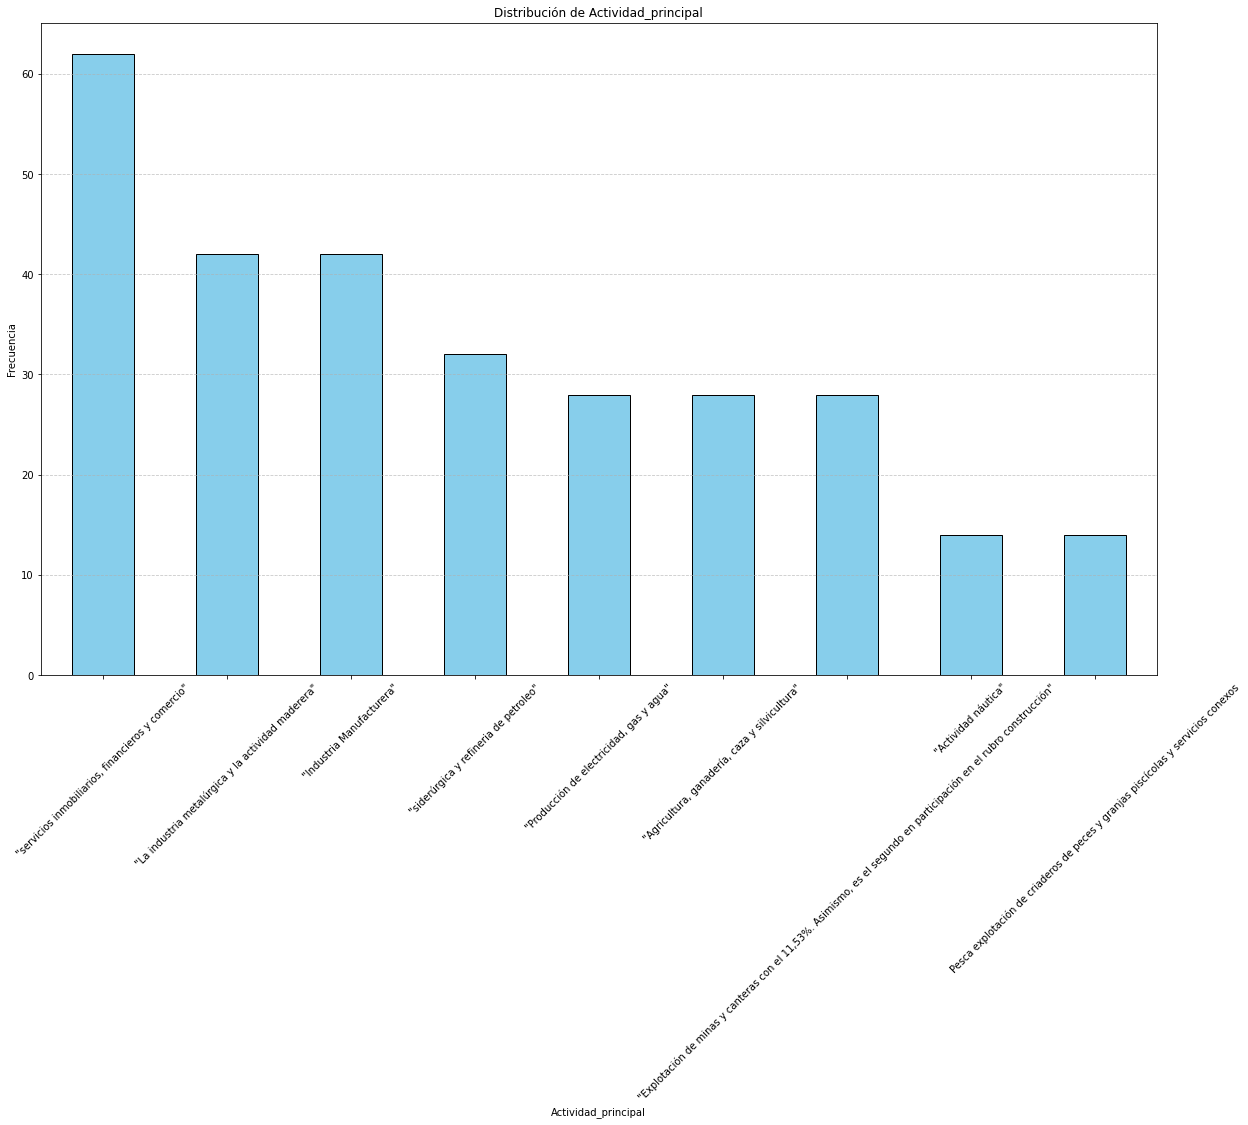

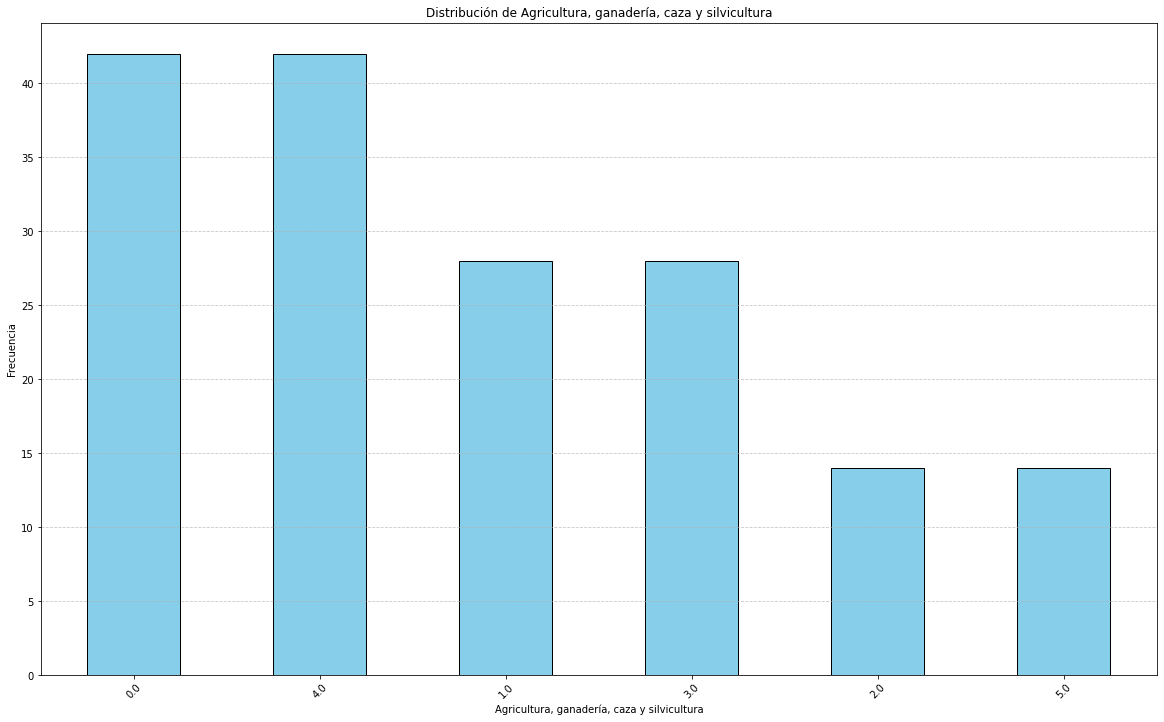

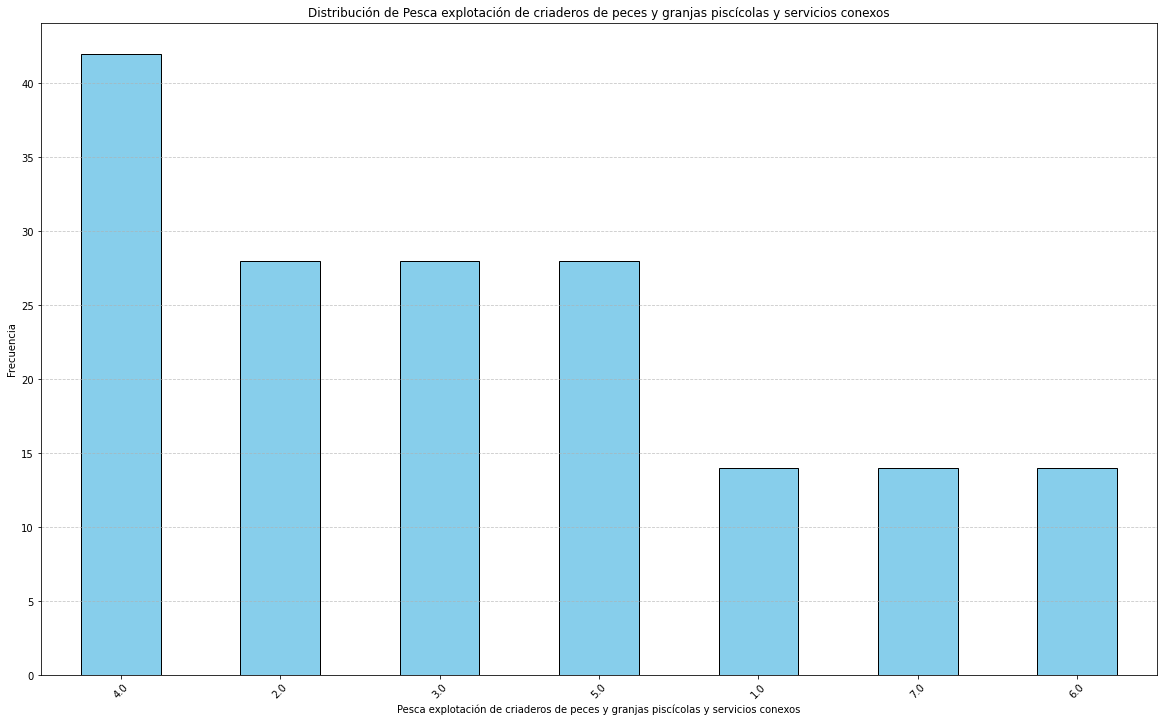

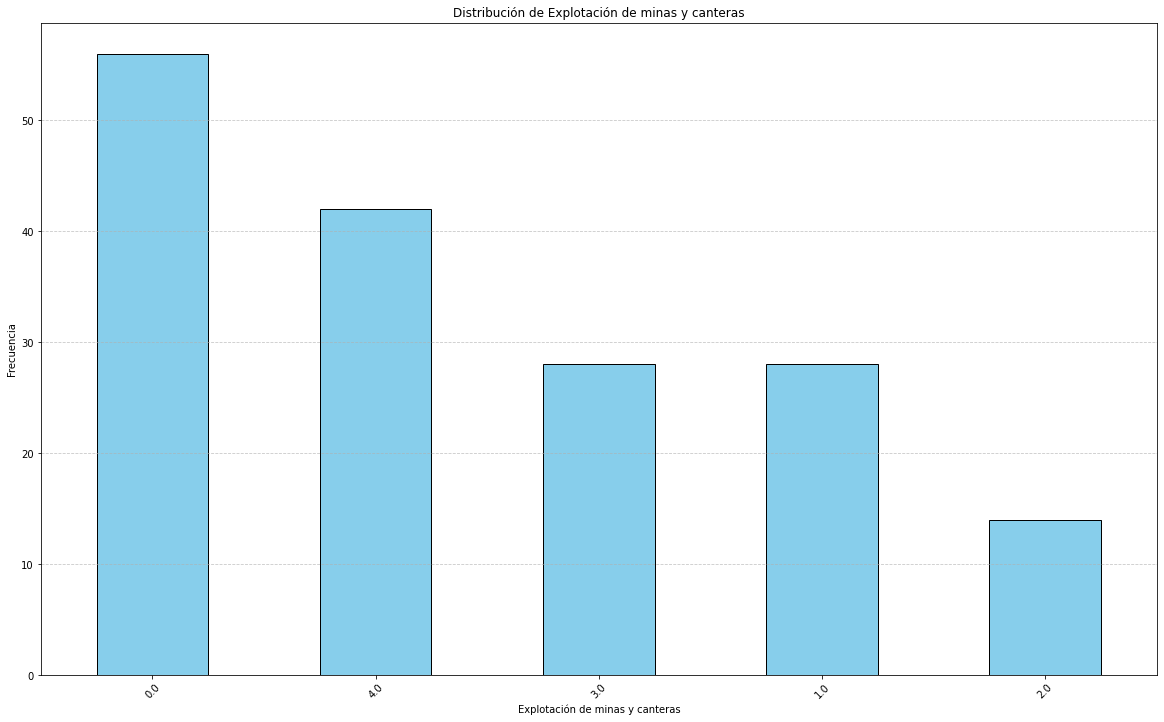

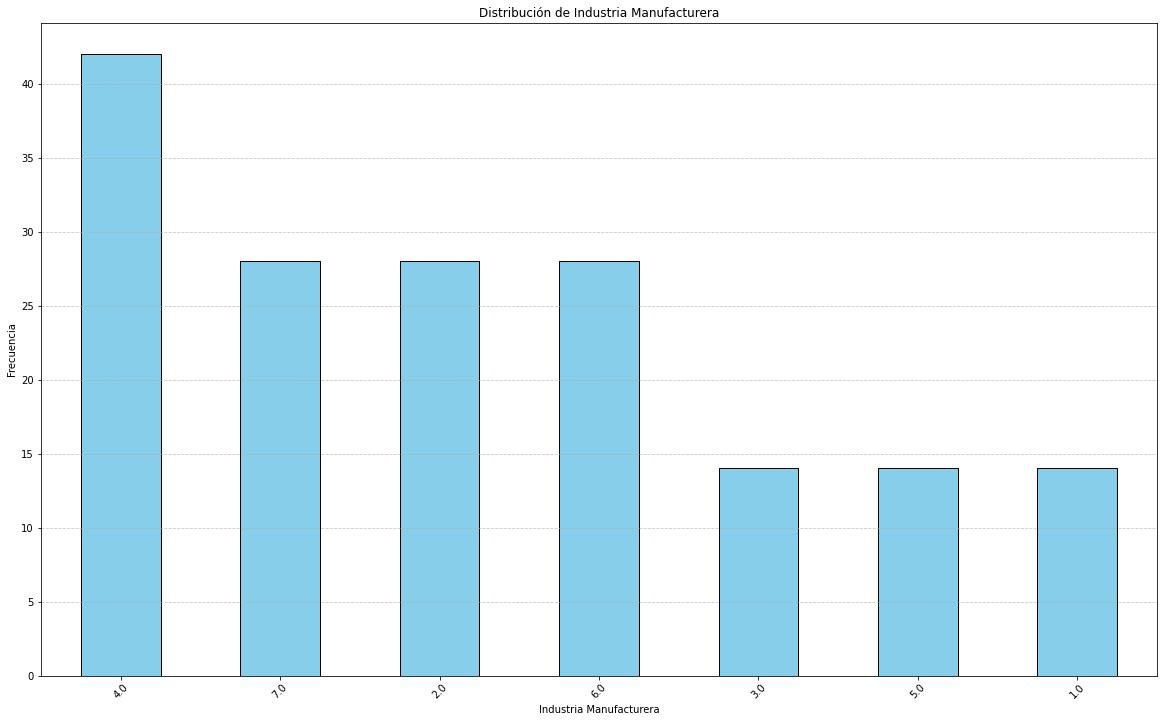

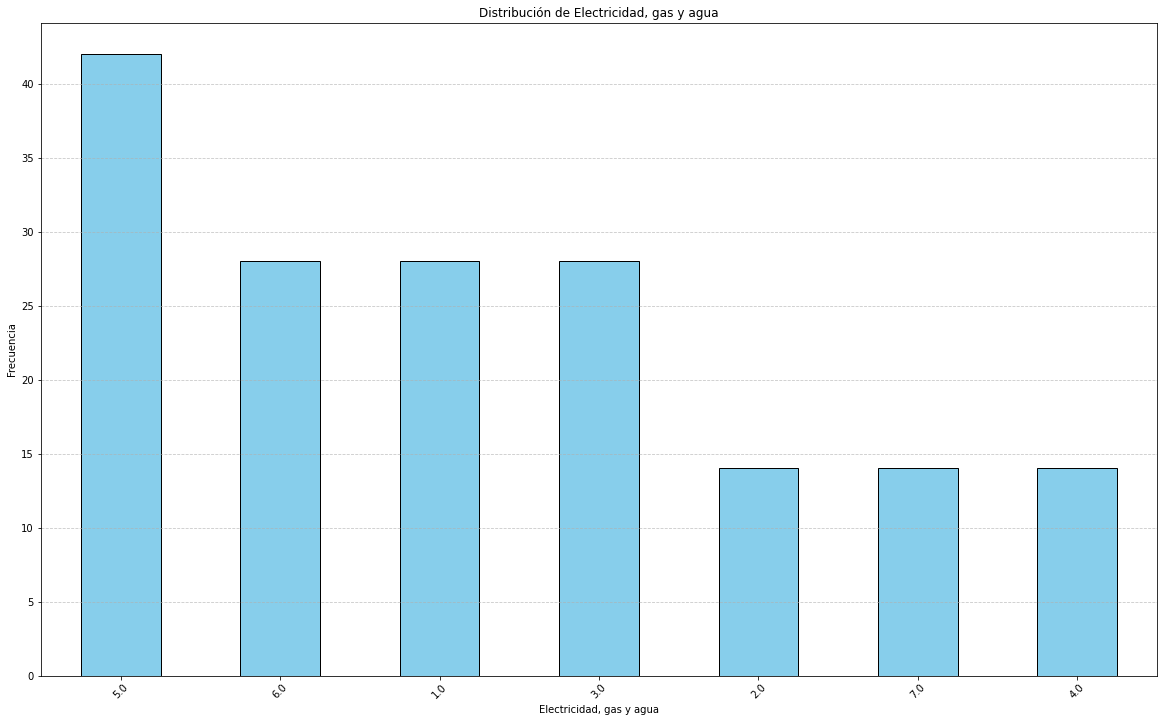

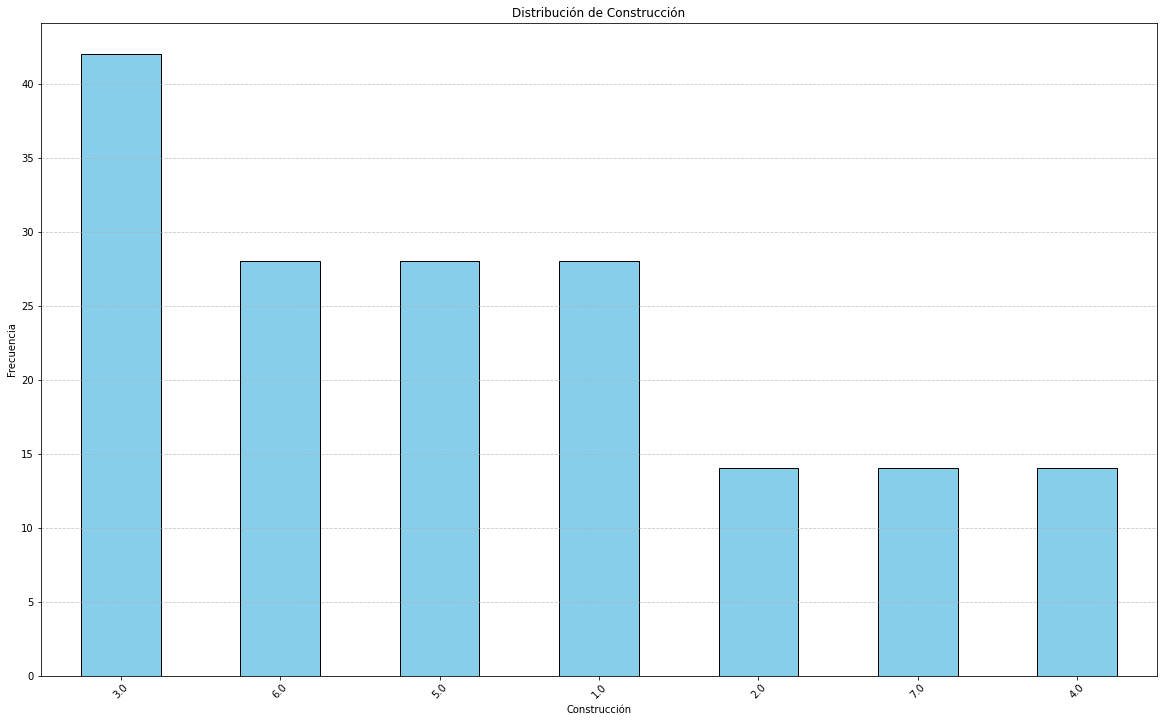

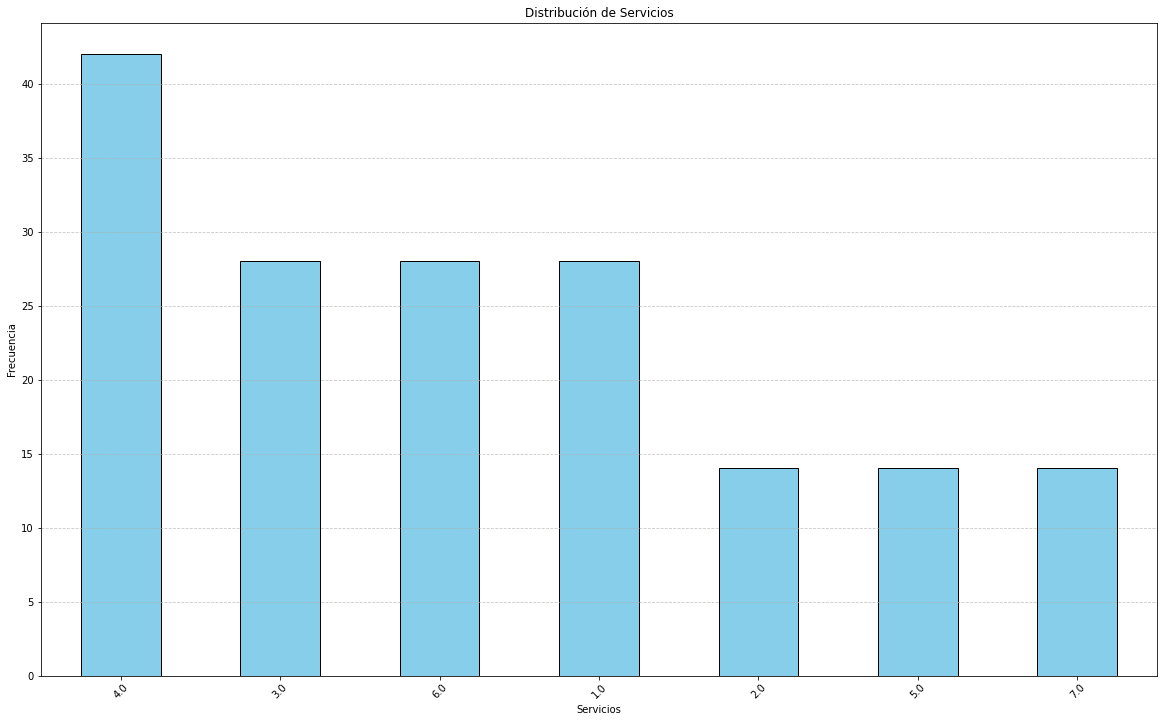

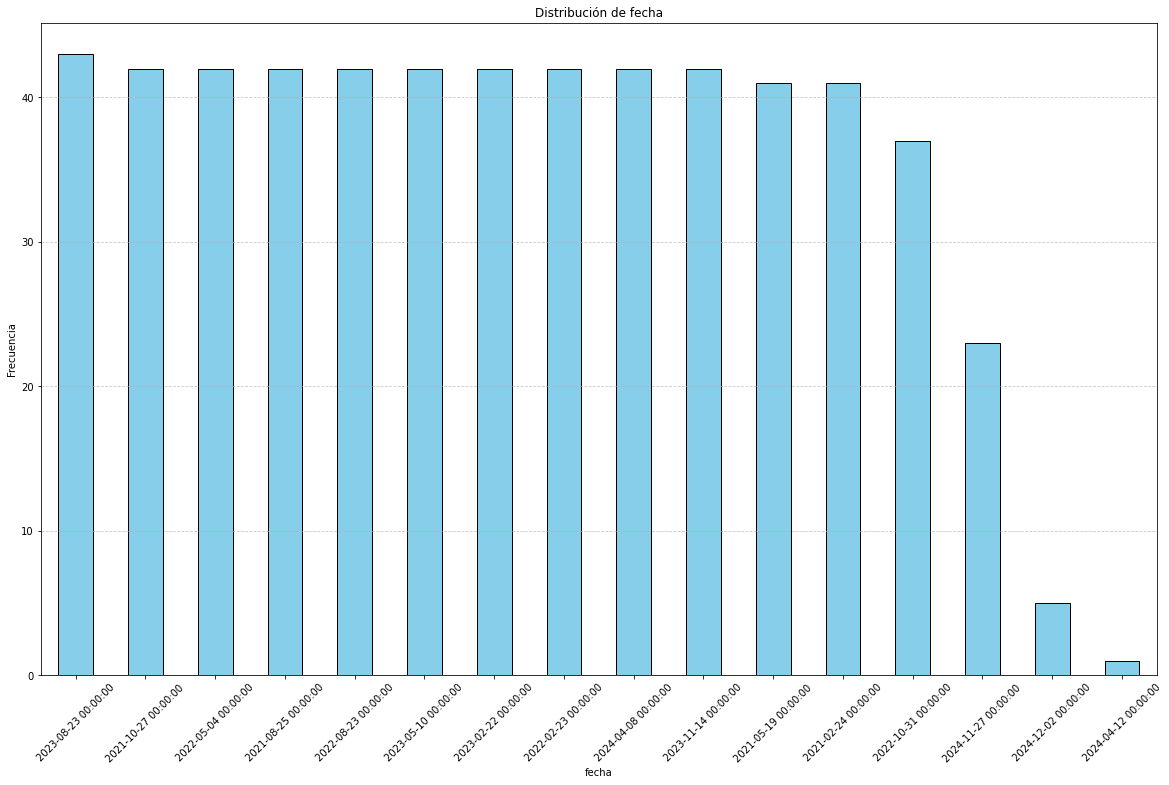

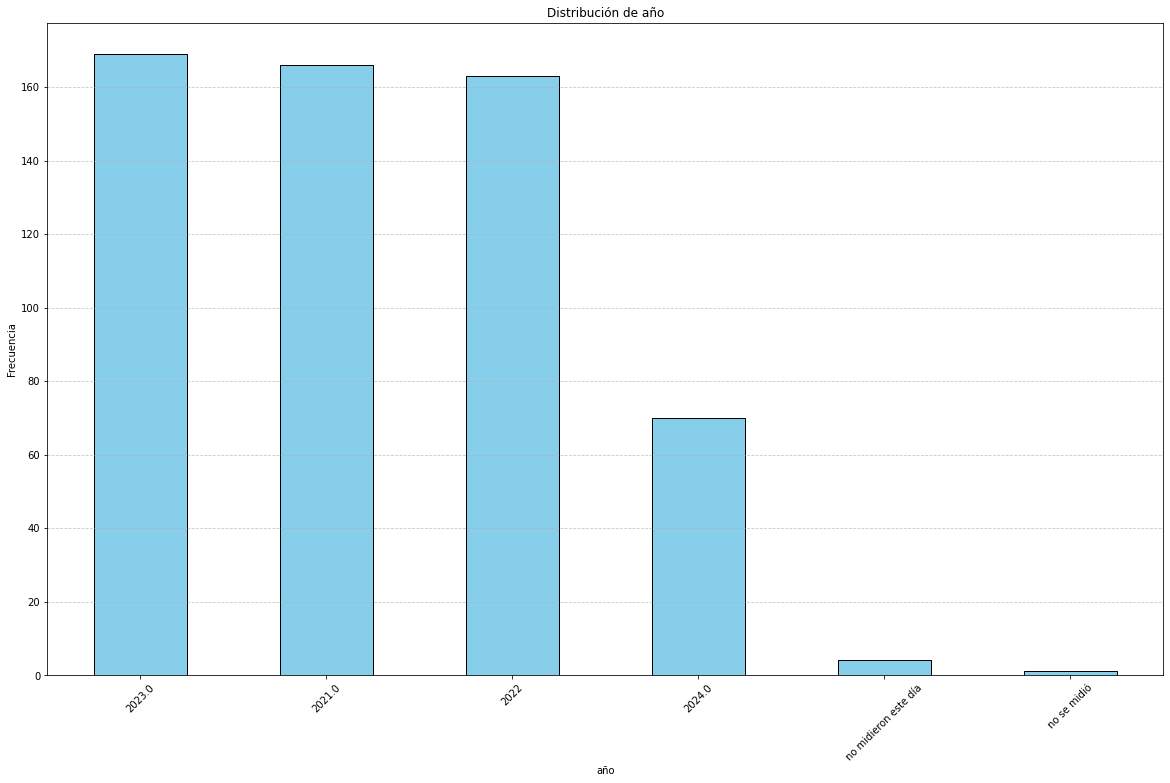

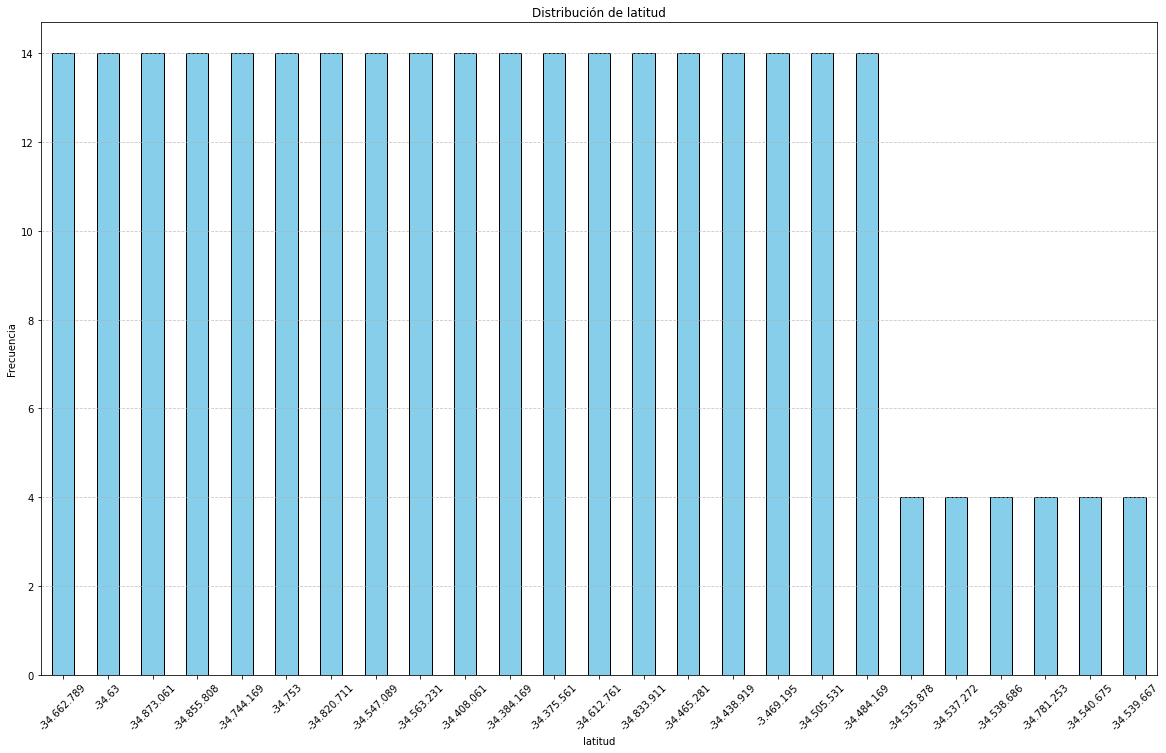

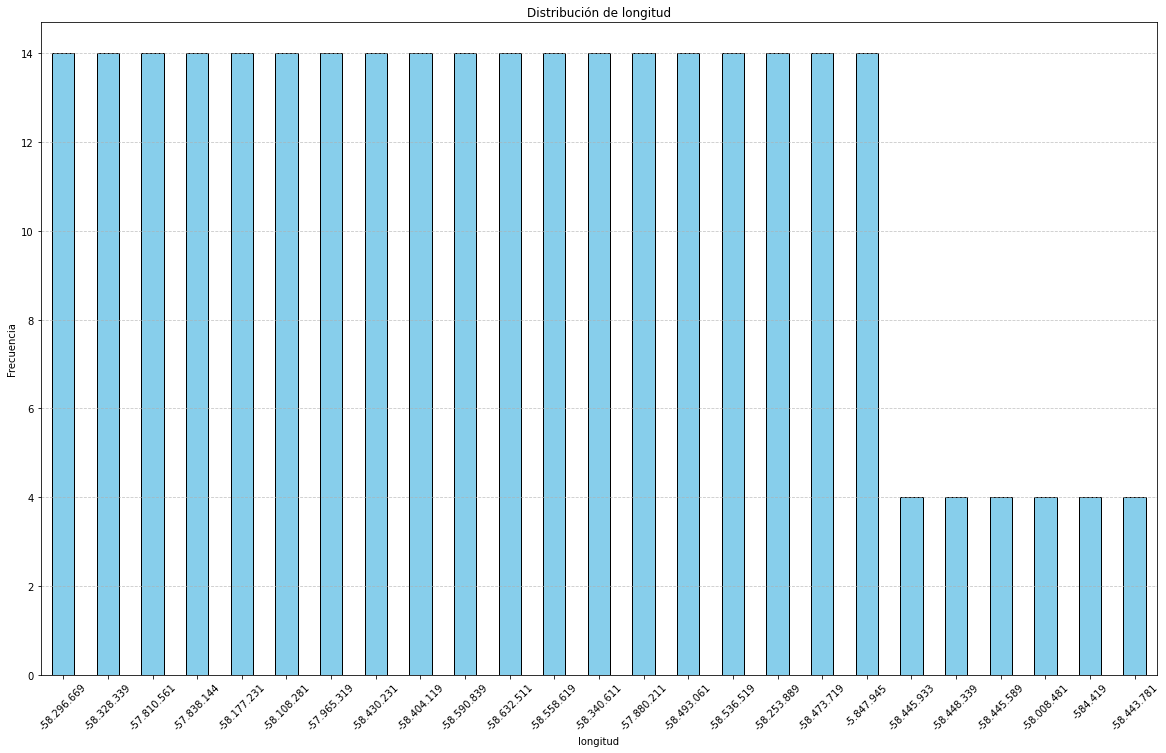

In [198]:
for col in categoricas:
    plt.figure(figsize=(20, 12))
    df7[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

En Agricultura, ganadería, caza y silvicultura, las categorías 0 y 4 son las más frecuentes, con una presencia destacada también de las categorías 1 y 3. Esto indica que ciertas actividades o subsectores dentro de esta área son más comunes en los datos.

En el sector de Pesca y explotación de criaderos de peces y granjas piscícolas, la categoría 4 tiene la mayor frecuencia, seguida por las categorías 2, 3 y 5, mostrando una concentración significativa en estas actividades específicas.

Para la Explotación de minas y canteras, la categoría 0 es la que domina ampliamente, con la categoría 4 también teniendo un peso considerable. Esto refleja una concentración en ciertas actividades mineras o extractivas dentro del dataset.

En la Industria manufacturera, la categoría 4 es claramente la más frecuente, seguida por las categorías 2, 6 y 7, lo que señala que una parte importante de la industria representada se centra en esos subsectores.

En el sector de Electricidad, gas y agua, la categoría 5 destaca por su alta frecuencia, con presencia moderada de las categorías 1, 3 y 6, reflejando la distribución de actividades en servicios públicos.

En Construcción, la categoría 3 tiene la mayor frecuencia, seguida por las categorías 1, 5 y 6, mostrando una variedad de subsectores con una concentración significativa en ciertos tipos de construcción.

Finalmente, en Servicios, la categoría 4 es la más común, con las categorías 1, 3 y 6 también presentes en proporciones relevantes, indicando la diversidad dentro del sector servicios y ciertos subgrupos predominantes.





**Datos atipicos**

Vemos gráficos boxplot para analizar la presencia de datos atípicos. Seguimos un esquema similar al realizado para los histogramas de las variables numéricas

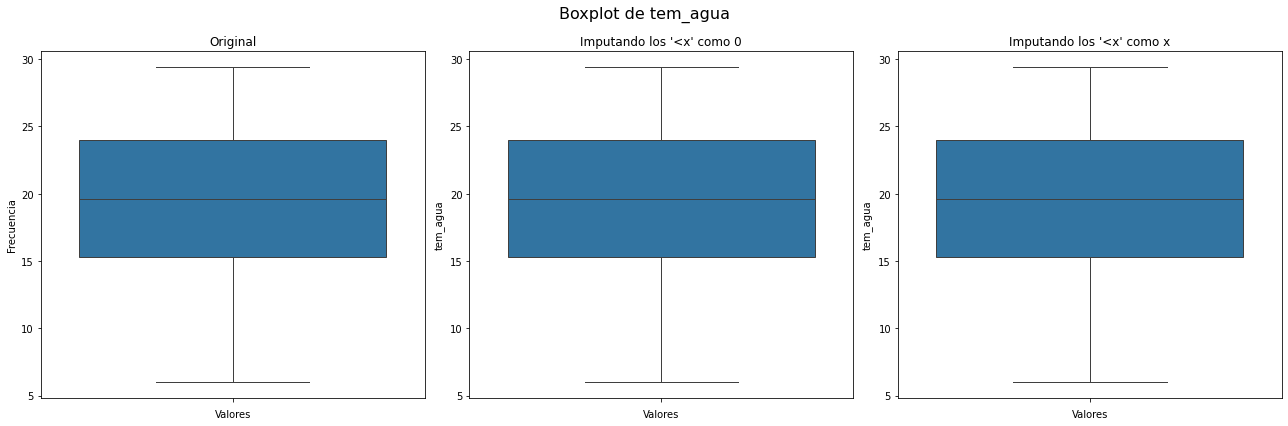

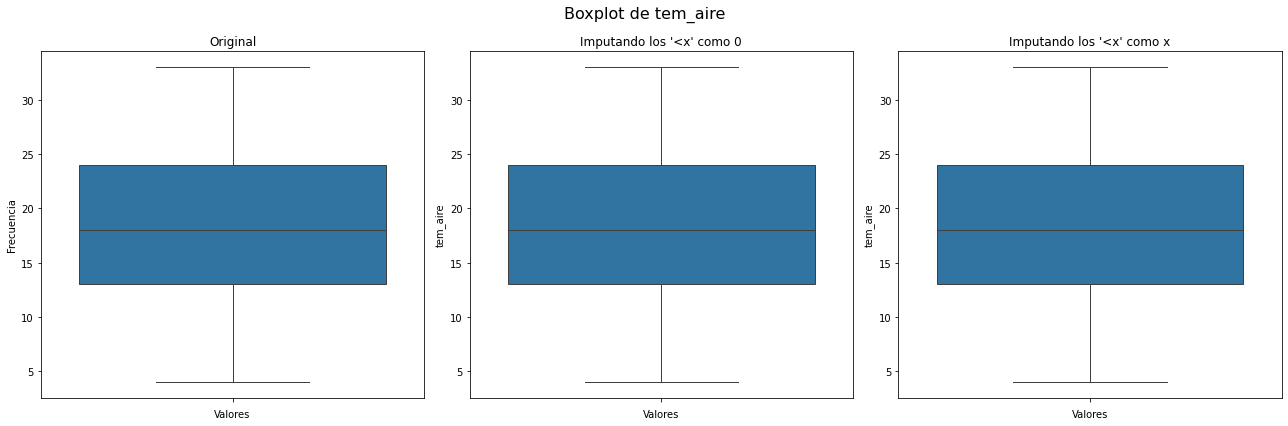

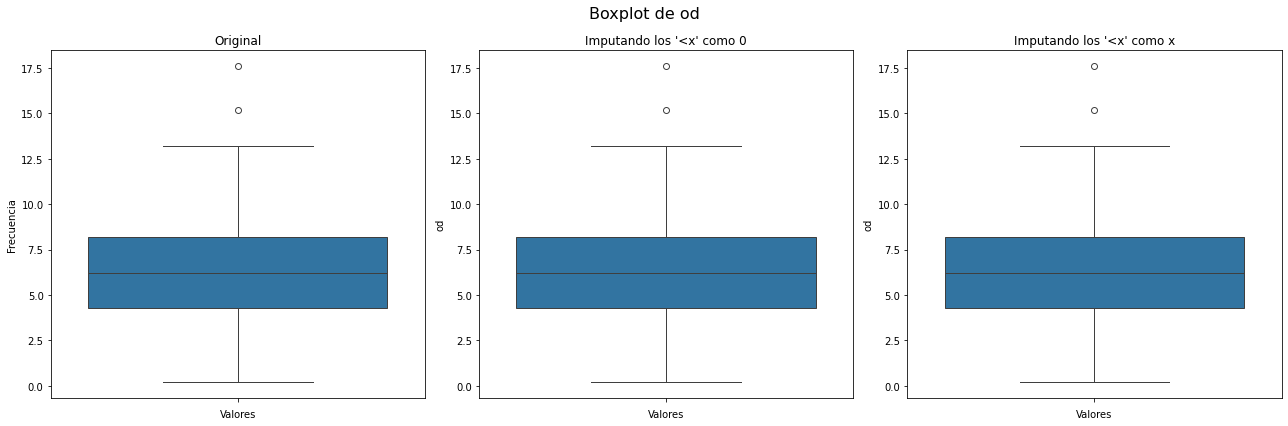

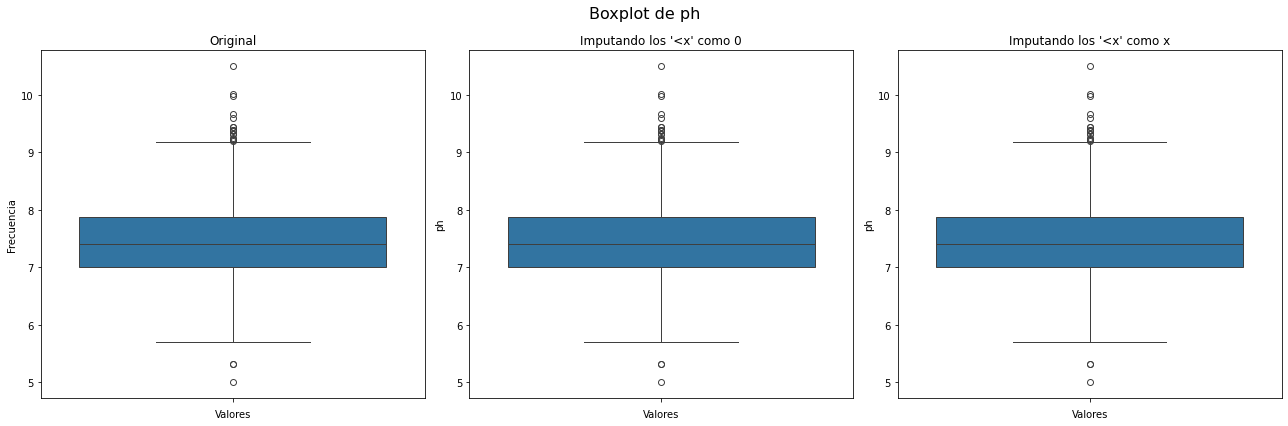

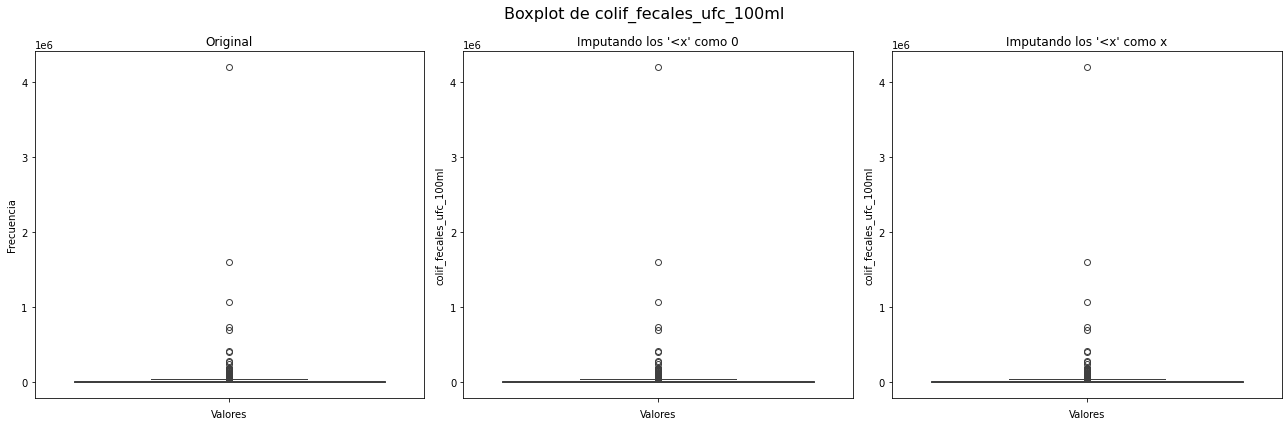

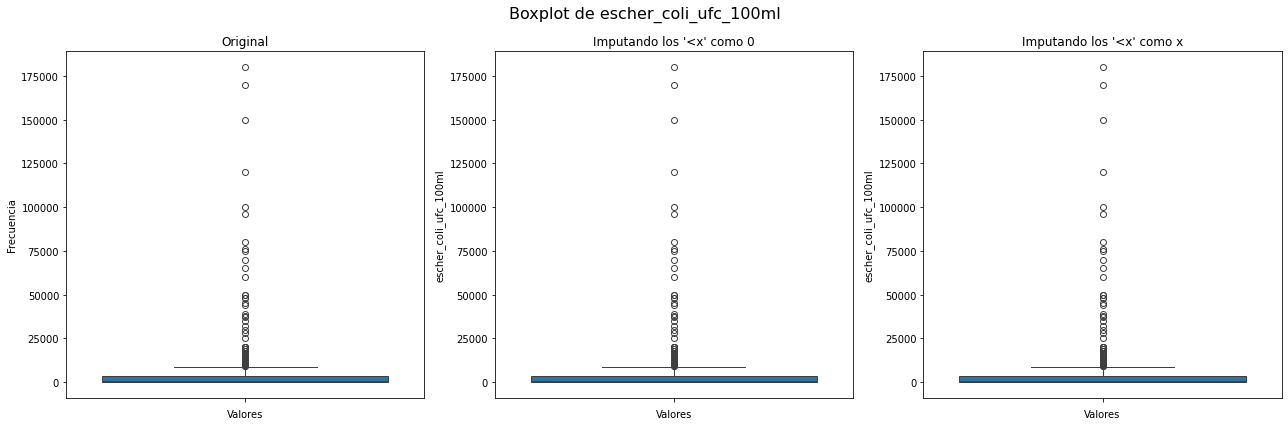

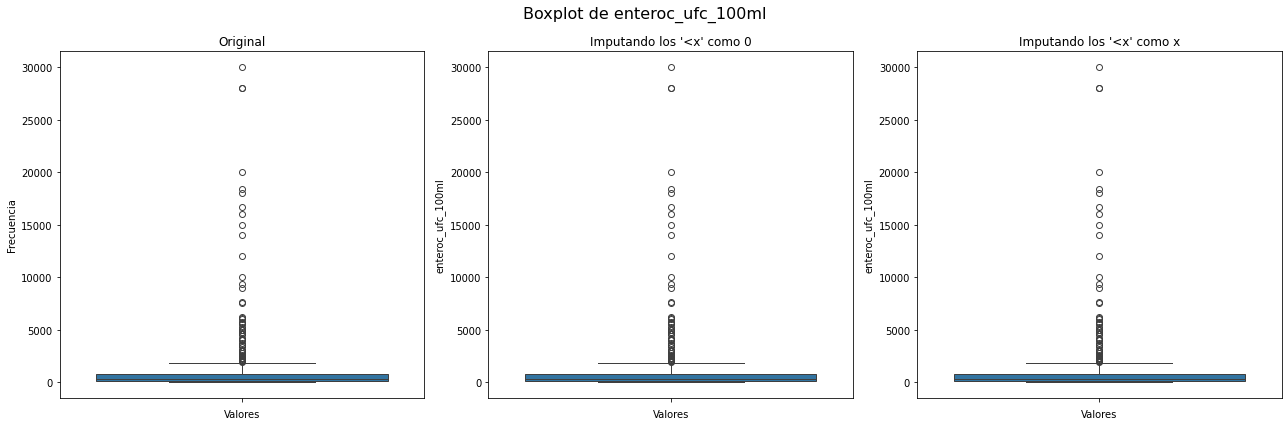

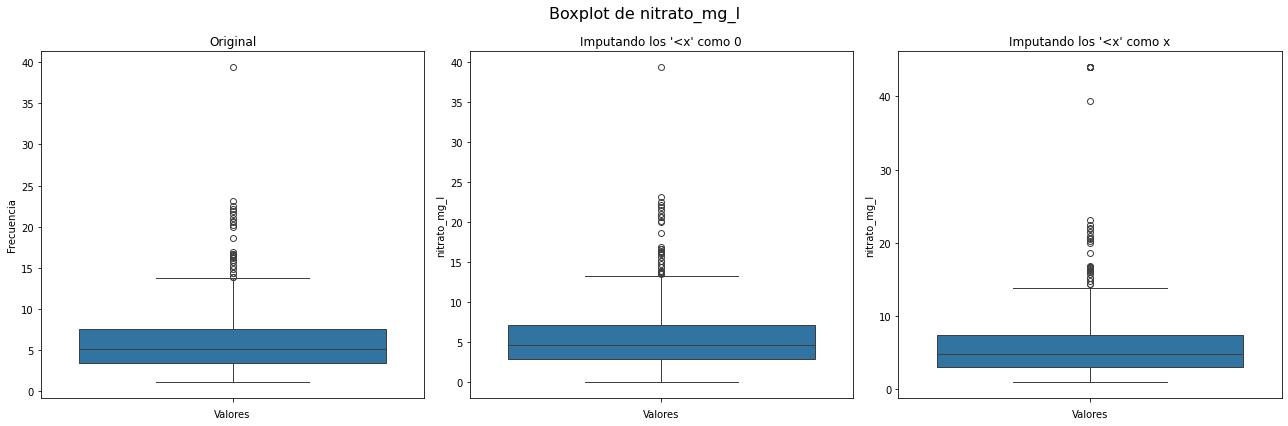

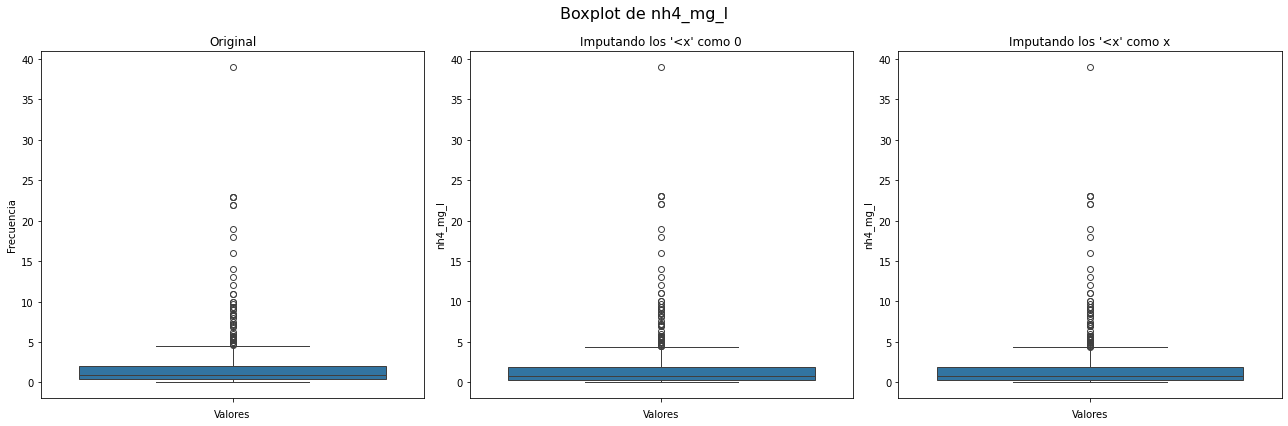

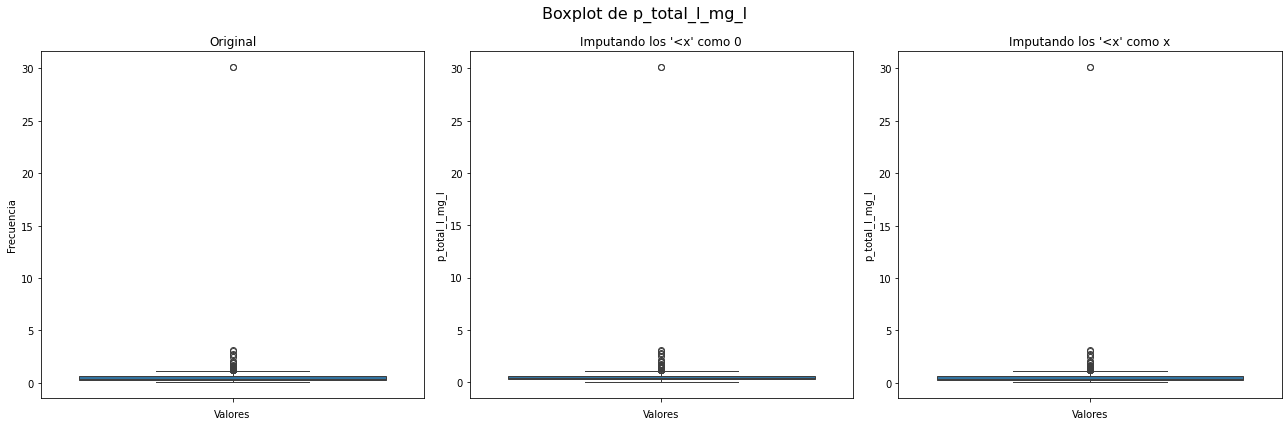

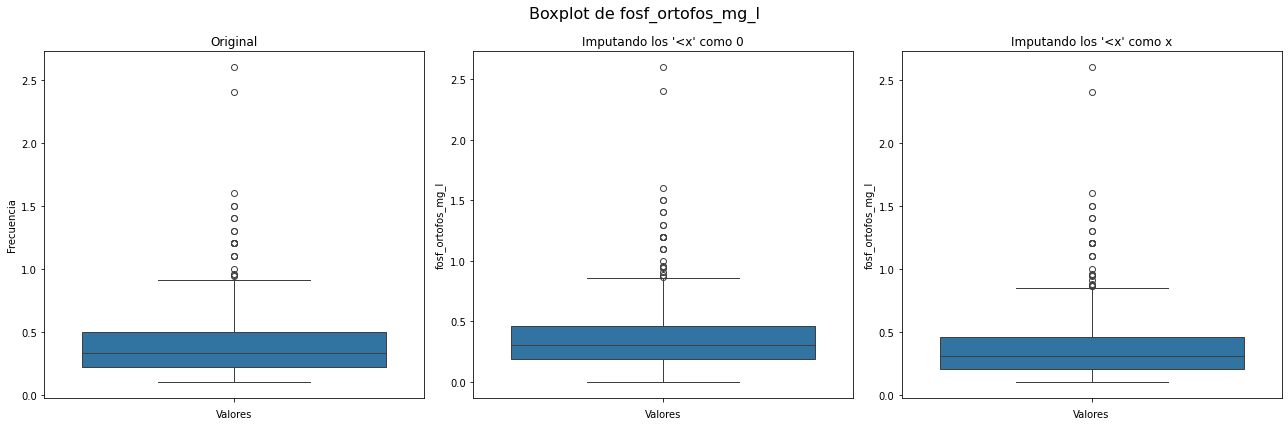

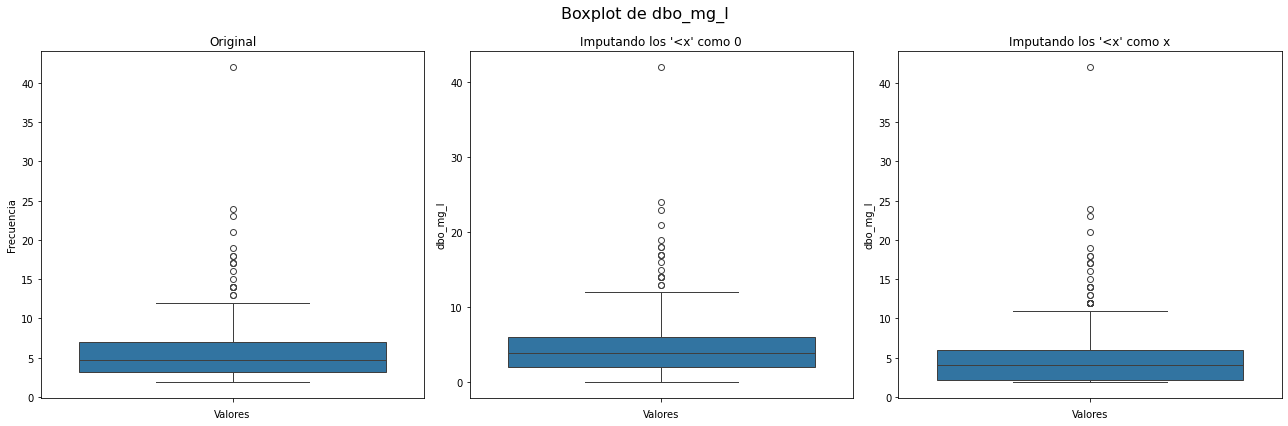

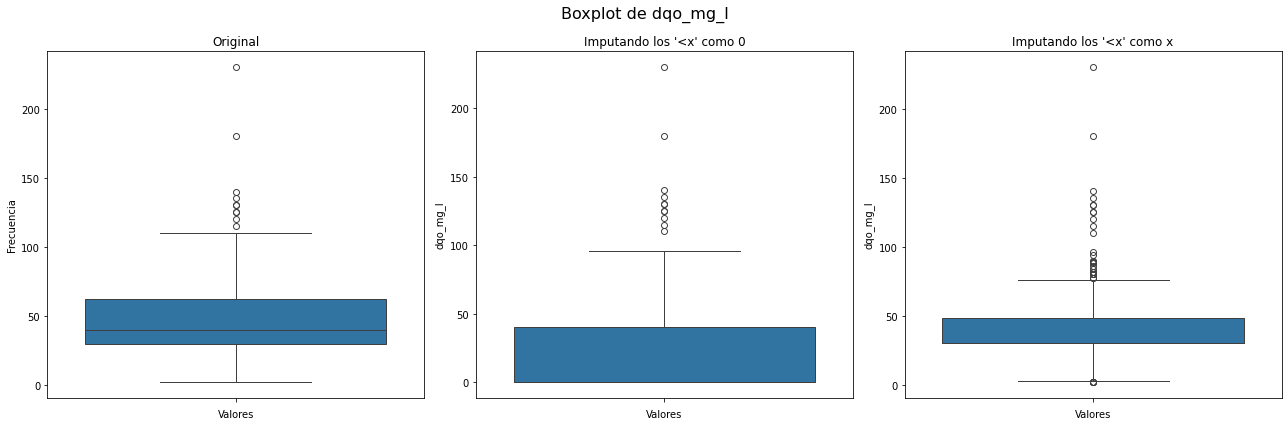

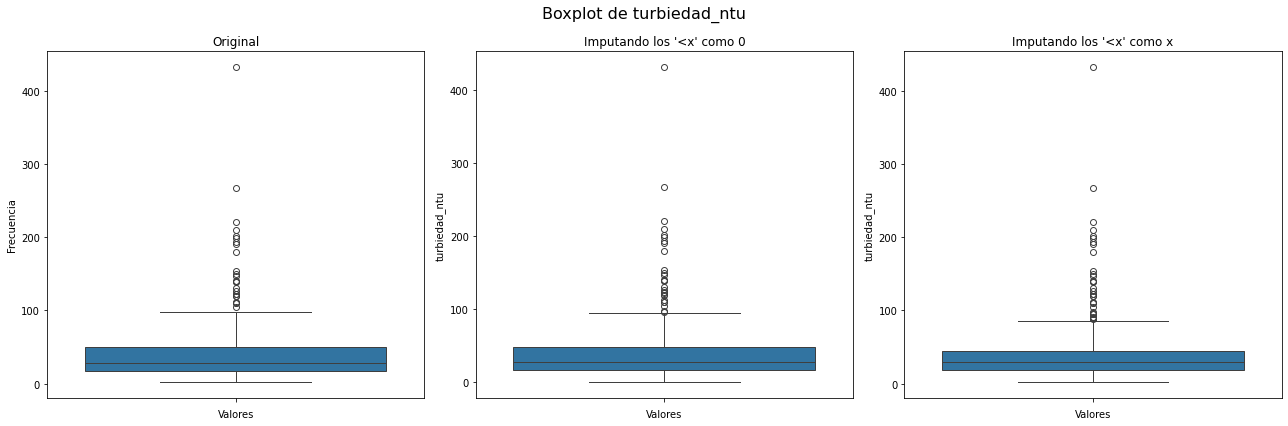

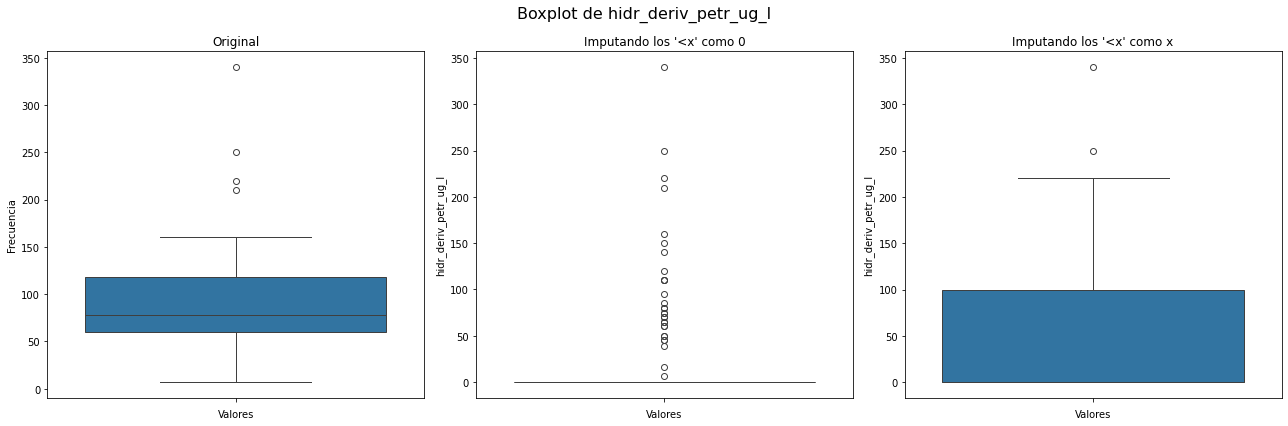

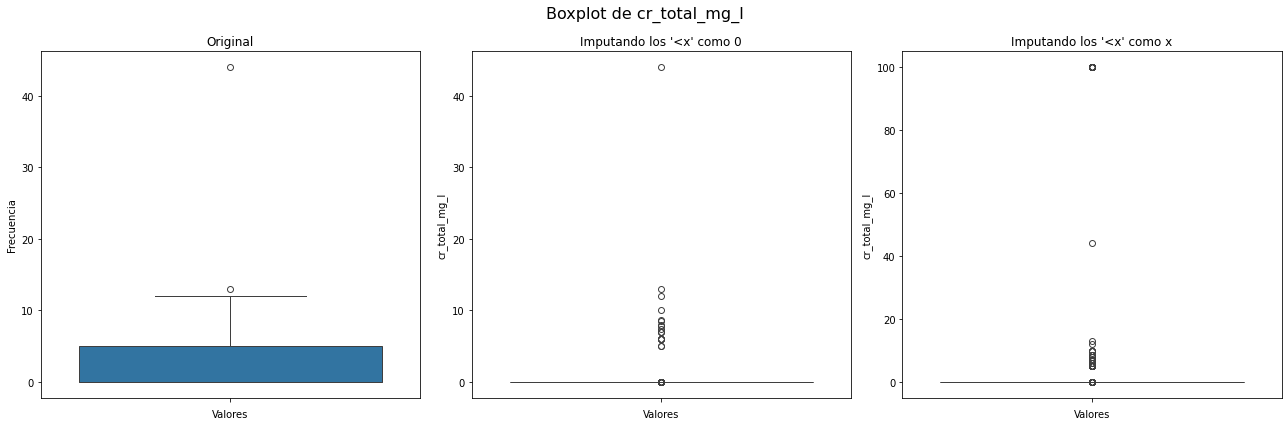

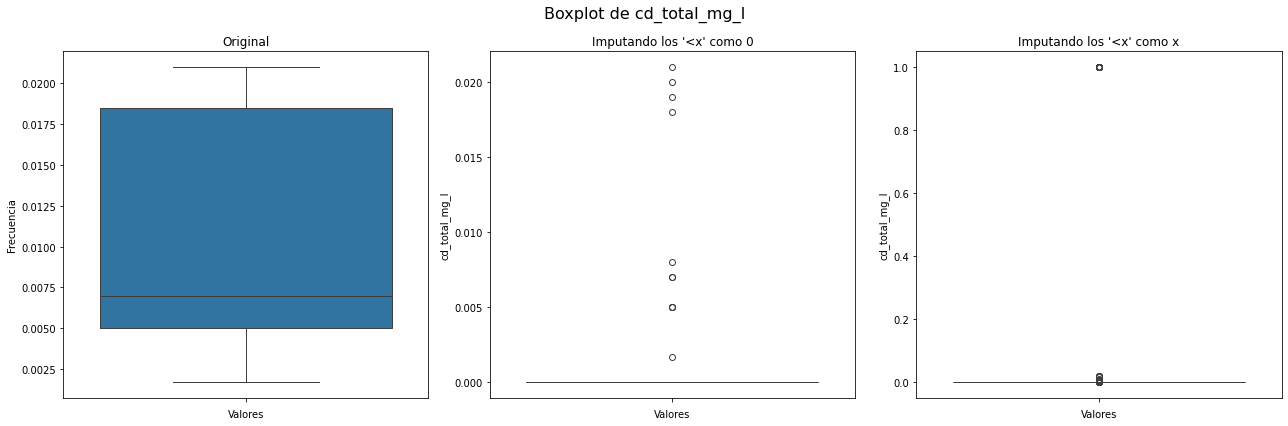

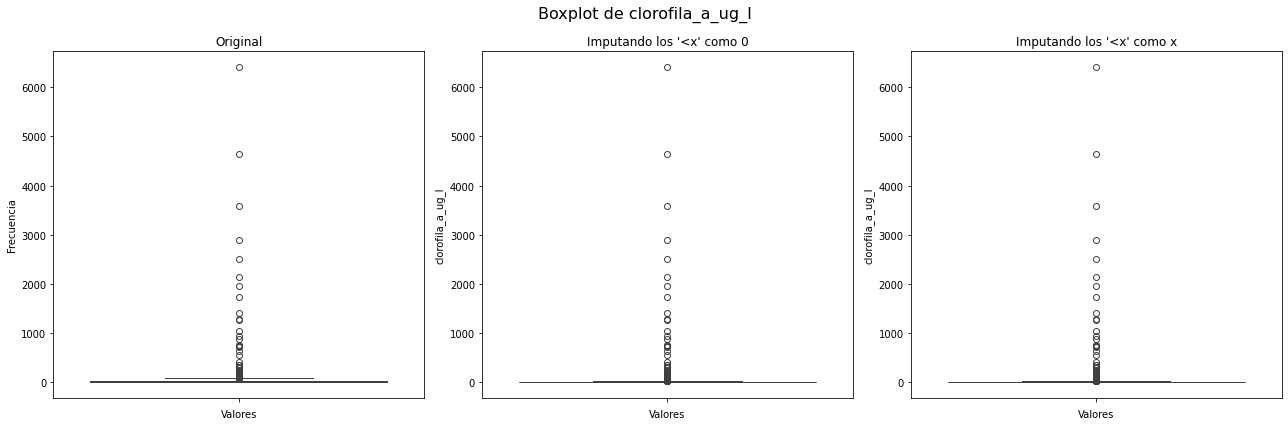

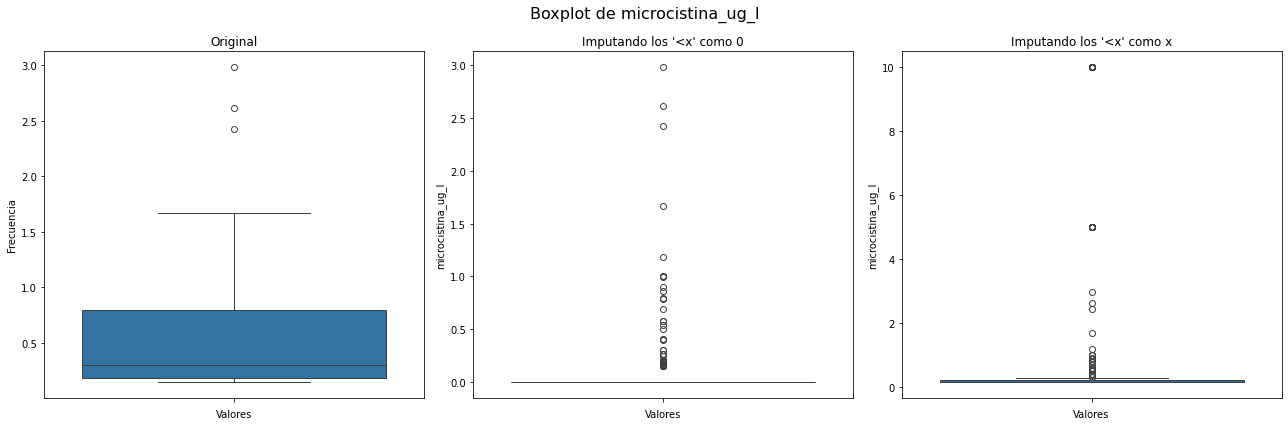

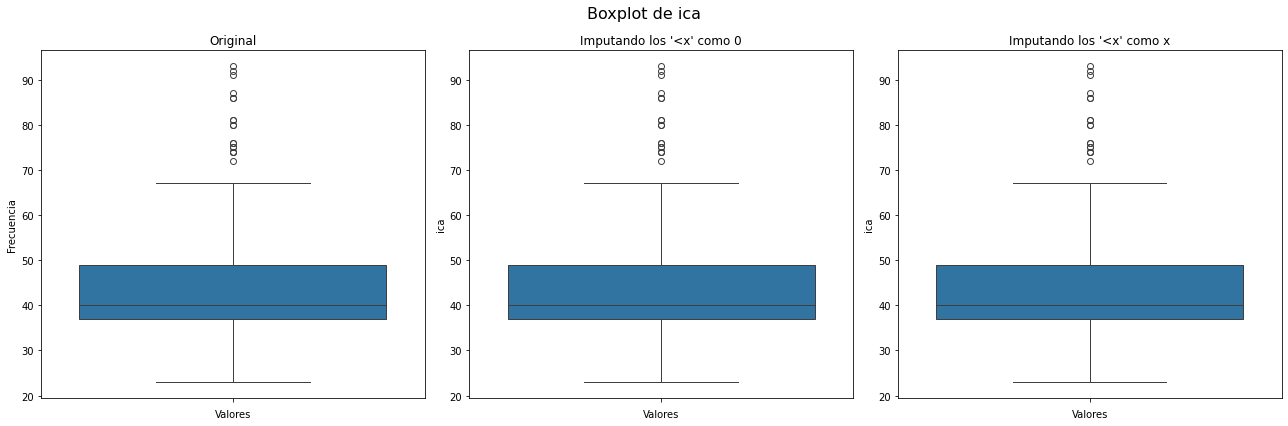

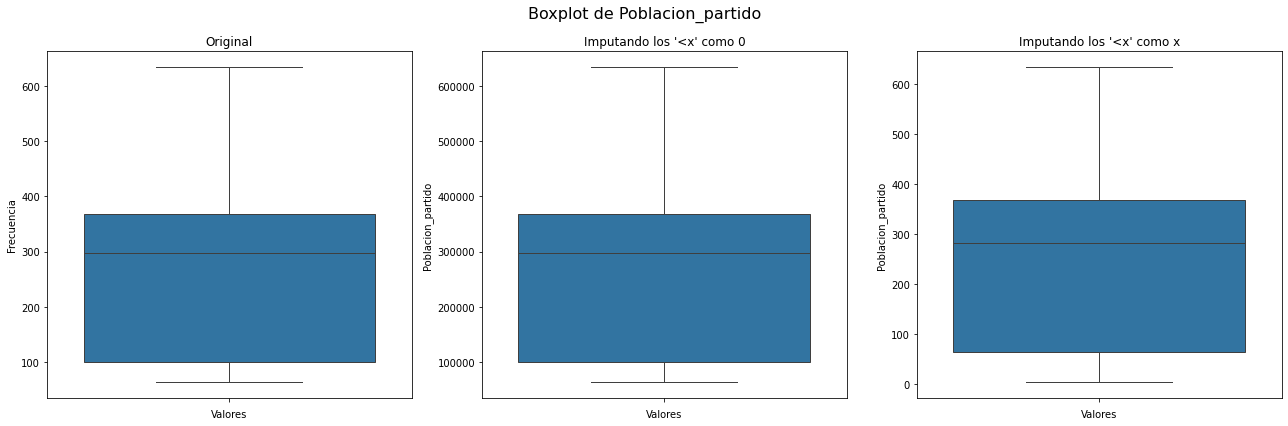

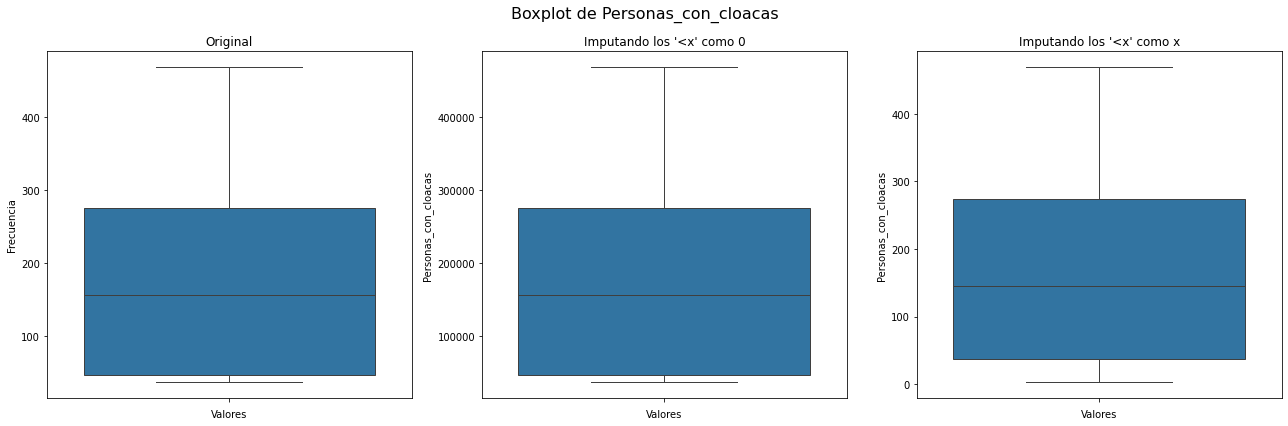

In [200]:
for col in numericas:
    # Crear figura y subgráficos (1 fila, 3 columnas)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(f"Boxplot de {col}", fontsize=16)
    
    # Creo copia de df original asegurando que en las variables numéricas se tengan sólo valores numéricos
        # (Se imputan como NaN todos los no numéricos, inclusive los '<x')
    df_copy = df.copy(deep=True)
    df_copy[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Lista de DataFrames y títulos para cada subgráfico
    dataframes = [df_copy, df7, df8]
    titles = ['Original', 'Imputando los \'<x\' como 0', 'Imputando los \'<x\' como x']

    # Graficar histogramas para cada DataFrame
    for i, (data, ax, title) in enumerate(zip(dataframes, axes, titles)):
        sns.boxplot(data=data[col], ax=ax)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Valores")
        if i == 0:  # Solo añadir etiqueta Y al primer subgráfico para evitar redundancia
            ax.set_ylabel("Frecuencia")

    # Ajustar layout y mostrar
    plt.tight_layout()
    plt.show()

El gráfico de cajas muestra la distribución de varias variables numéricas del dataset y permite identificar la presencia de outliers.

Se observan muchas variables con puntos fuera de los bigotes, lo que indica la presencia de outliers evidentes.

**Correlacion de variables**

Se muestra una matriz de correlación entre las variables numéricas del dataset, permitiendo visualizar qué tan relacionadas están entre sí. Los valores anotados indican la fuerza y dirección de la relación: valores cercanos a 1 o -1 muestran correlaciones fuertes positivas o negativas, respectivamente, mientras que valores cercanos a 0 indican poca o ninguna correlación.

Se ven las variables numéricas y algunas categóricas que se expresan mediante números, teniendo especial interés las relacionadas con las actividades económicas.

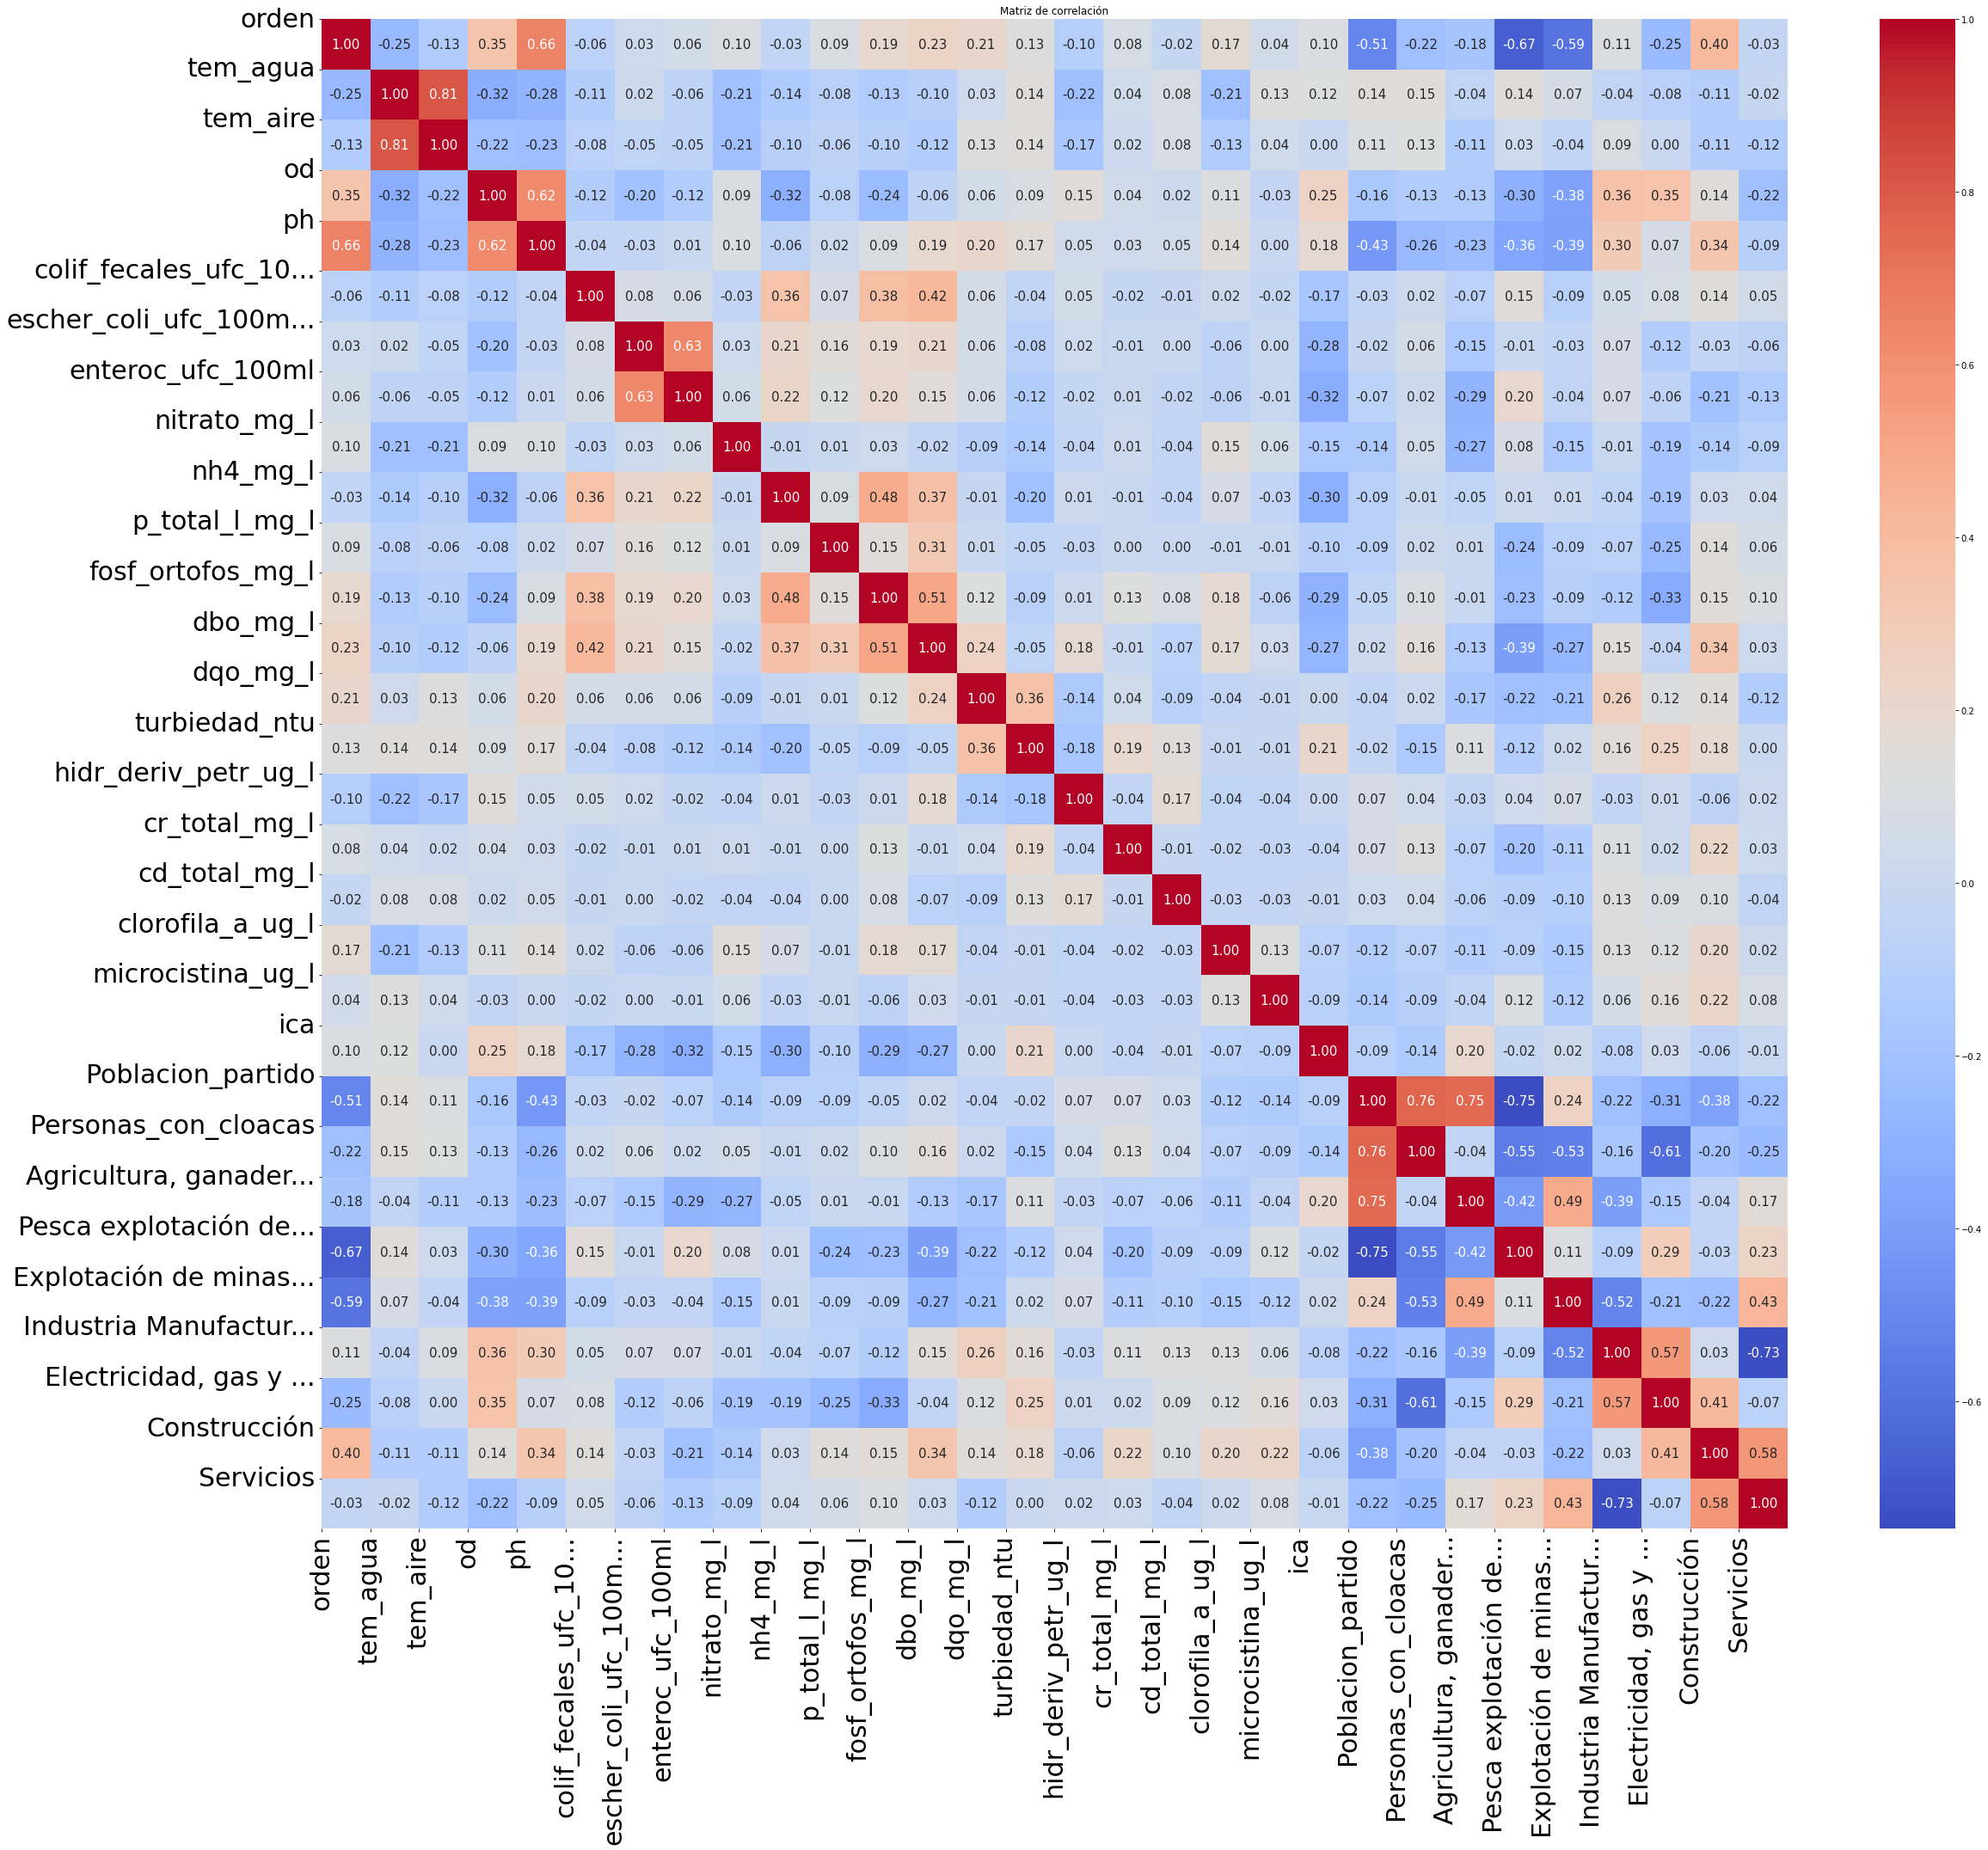

In [229]:
# Correlacion entre variables
truncated_labels = [label[:20] + '...' if len(label) > 20 else label for label in df7.select_dtypes(include=['int64', 'float64']).columns.tolist()]

plt.figure(figsize=(35, 30))
sns.heatmap(df7.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 15})
plt.title("Matriz de correlación")
plt.yticks(ticks=range(len(truncated_labels)), labels=truncated_labels, rotation=0, fontsize=30)
plt.xticks(ticks=range(len(truncated_labels)), labels=truncated_labels, rotation=90, fontsize=30)
plt.tight_layout()
plt.show()

En esta matriz se observa que algunas variables, como “Industria Manufacturera” y “Electricidad, gas y agua”, tienen una correlación positiva moderada (0.57), lo que indica que estas dos actividades tienden a aumentar o disminuir juntas. Por otro lado, “Industria Manufacturera” y “Servicios” muestran una correlación negativa fuerte (-0.73), lo que sugiere que cuando una variable aumenta, la otra tiende a disminuir.

También destaca que “Explotación de minas y canteras” tiene una correlación positiva moderada con “Servicios” (0.43) y una correlación negativa con “Industria Manufacturera” (-0.52), lo que puede reflejar diferencias en la dinámica económica entre estos sectores.

**Correlacion entre Gobierno local y codigo**
Tabla de contingencia muestra cómo se distribuyen las observaciones según las categorías combinadas

In [223]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df7['codigo'], df7['gobierno_local'])

print("Tabla de contingencia entre 'codigo' y 'gobierno_local':")
display(contingency_table)

# Calcular Chi-cuadrado
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Calcular coeficiente de Cramér
n = contingency_table.sum().sum()
cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))

print(f"\nEstadístico Chi-cuadrado: {chi2:.4f}")
print(f"Valor p: {p:.4f}")
print(f"Grados de libertad: {dof}")
print(f"Coeficiente de Cramér: {cramer_v:.4f}")

Tabla de contingencia entre 'codigo' y 'gobierno_local':


gobierno_local,Avellaneda,Berazategui,Berisso,CABA,Ensenada,Quilmes,San Fernando,San Isidro,Tigre,Vicente López
codigo,,,,,,,,,,
AV053,14,0,0,0,0,0,0,0,0,0
AV054,14,0,0,0,0,0,0,0,0,0
BS091,0,0,14,0,0,0,0,0,0,0
BS092,0,0,14,0,0,0,0,0,0,0
BZ078,0,14,0,0,0,0,0,0,0,0
BZ080,0,14,0,0,0,0,0,0,0,0
CA CU01,0,0,0,4,0,0,0,0,0,0
CA CU02,0,0,0,4,0,0,0,0,0,0
CA CU03,0,0,0,4,0,0,0,0,0,0



Estadístico Chi-cuadrado: 2610.0000
Valor p: 0.0000
Grados de libertad: 216
Coeficiente de Cramér: 1.0000


In [225]:
def tabla_contingencia(serie_x : pd.Series, serie_y : pd.Series, titulo : str = None, x_label: None | str = None, y_label: None | str = None, x_size : float = 20, y_size : float = 16):
    contingency_table = pd.crosstab(serie_y, serie_x)
    plt.figure(figsize=(x_size, y_size))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title(titulo)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

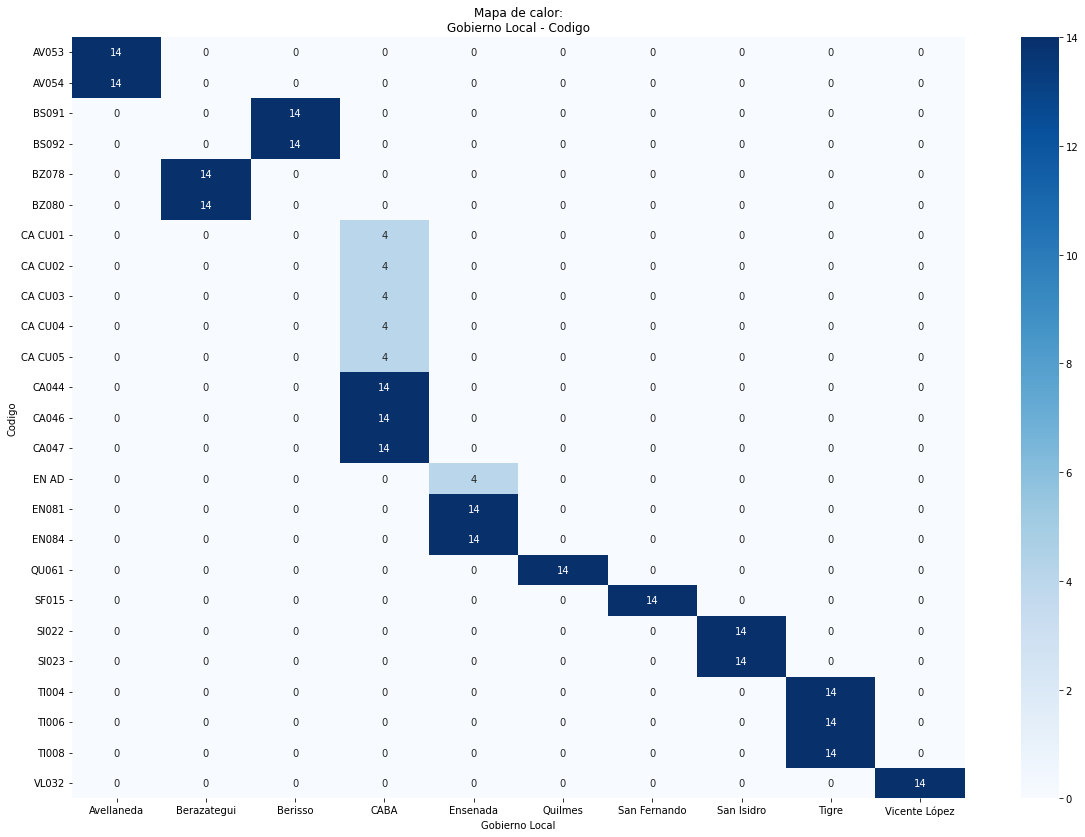

In [227]:
tabla_contingencia(df7['gobierno_local'], df7['codigo'], titulo = "Mapa de calor:\nGobierno Local - Codigo", x_label = "Gobierno Local", y_label = "Codigo", x_size = 20, y_size = 14)

Existe una asociación estadísticamente significativa y muy fuerte entre las variables codigo y gobierno_local. Esto significa que cada código está asociado de manera casi exclusiva con un gobierno local específico, lo cual es coherente si los códigos representan sitios o unidades que pertenecen a un solo gobierno local.

## CONCLUSIONES

- El dataset contiene un total de 45 variables o features y 613 entradas o registros. Estas variables incluyen tanto datos numéricos como categóricos.

- Tenemos 22 variables numéricas, de las que identificamos 3 discretas y 19 continuas.
- Identificamos 23 variables categóricas, de las cuales 11 son ordinales (relacionadas con la posición, actividad económica, tiempo y calidad del agua) y 4 binarias (relacionada con la presencia o ausencia de cierta característica observable en el agua)

- En cuanto al tipo de datos, la mayoría de las columnas están clasificadas como objetos (object). Esto ocurre en las columnas categóricas, pero también en la mayoría de las numéricas. Esto último se debe a que tenemos valores almacenados en formato texto que representan datos faltantes, o mediciones en las que se detectaron determinadas características físicas o químicas pero en cantidades por debajo del LOQ. Fue necesario, para estos casos, realizar conversiones para trabajar con datos cuantitativos continuos o discretos y estudiar la estructura de sus datos faltantes.

- Se exploró dos formas de imputar las mediciones por debajo del LOQ: imputando por cero o por el valor que representa el límite inferior de cuantificación. Se vió que en muchas variables cada una de estas formas pueden alterar apreciablemente la distribución de los datos, por lo que en una instancia futura de curación de los datos se deberá estudiar cuidadosamente como proseguir con estos casos.

- Se detectaron algunas filas duplicadas, aunque en cantidad limitada, y también valores repetidos dentro de columnas, lo cual es común en datos categóricos pero debe ser evaluado en variables numéricas para evitar redundancias. La mayoría de estas filas repetidas tienen todos sus valores de interés nulos, por lo que deberán ser eliminadas en el futuro.

- Se estudió la estructura de los valores faltantes para cada categoría. Se observan variables con muchos datos faltantes, como las relacionadas con la concentración de metales pesados (apreciable luego de la corrección implementada sobre las variables numéricas), lo que sugiere descartarlas en el futuro. Otras variables relacionadas con los datos del Censo y el Programa de Estudios del Conurbano tienen muchos datos faltantes, pero gracias a la correlación con las variables relacionadas con la posición, puede imputarse sus valores faltantes.

- Respecto a los datos para ubicar la posición de la estación de medición, se verifica que la variable código no tiene valores faltantes, por lo que puede usarse esta para identificar las posiciones de lor registros e imputar los datos faltantes de las variables provenientes del censo y del Programa de Estudios del Conurbano.

- Se observan colas importantes en las distribuciones de muchas variables numéricas, lo que se evidencia con la presencia de outliers en sus respectivos boxplot. Es necesario estudiar cada uno de estos casos con mayor detenimiento.

- La matriz de correlación indicó relaciones positivas y negativas entre ciertas variables, por ejemplo, una correlación positiva moderada entre “Industria Manufacturera” y “Electricidad, gas y agua”, y una correlación negativa fuerte entre “Industria Manufacturera” y “Servicios”. Estas relaciones ayudan a entender la interacción entre variables, identificar redundancias y seleccionar aquellas más relevantes para modelar o interpretar. 

- Respecto a las unidades, es importante revisar y estandarizar aquellas variables numéricas que puedan estar expresadas en diferentes escalas o formatos, para evitar sesgos en el análisis o modelado.